### Import Packages

In [1]:
import pandas as pd
import numpy as np
import sklearn
import math
import random
import os
import string
import spacy
import ast
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer
nlp_spacy_core_web_lg = en_core_web_sm.load()


### Write Methods

In [2]:
def create_dict(df):
    feats = ['text', 'text_low', 'pos', 'lemma', 'lemma_low', 'tag', 'dep', 'shape', 'is_alpha', 'is_stop', 'has_vec', 'glove_vec300', 
         'glove_vec300_norm', 'is_oov','morph', 'order', 'tf_idf', 'is_ne', 'ne_label'
         , 'negative', 'positive', 'bias_lex_r', 'bias_lex_h', 'liwc']
    feats_C1 = [a + b for a, b in zip(feats, len(feats)*['_c1'])]
    feats_C2 = [a + b for a, b in zip(feats, len(feats)*['_c2'])]
    feats_C3 = [a + b for a, b in zip(feats, len(feats)*['_c3'])]
    feats_C4 = [a + b for a, b in zip(feats, len(feats)*['_c4'])]
    for index, row in df.iterrows():
        sent_tokens = []
        entities = [] # create list of named entities
        for ent in df["spacy_lg"][index].ents:
            ent_dict = {'text': ent.text,
                       'label': ent.label_}
            entities.append(ent_dict)

        order = 0
        for token in df['spacy_lg'][index]:
            if token.pos_ not in ['PUNCT', 'SPACE', 'SYM', 'CCONJ', 'PART', 'NUM']:
                order += 1    
                if token.text.lower() in list(tf_idf):
                    tfidf_temp = tf_idf[token.text.lower()][index]
                else:
                    tfidf_temp = None 
                token_dict = {'text':token.text,
                        'text_low': token.text.lower(),
                        'pos': token.pos_,
                        'lemma': token.lemma_,
                        'lemma_low': token.lemma_.lower(),
                        'tag': token.tag_,
                        'dep': token.dep_,
                        'shape': token.shape_,
                        'is_alpha': token.is_alpha,
                        'is_stop': token.is_stop,
                        'has_vec':token.has_vector,
                        'glove_vec300':token.vector,
                        'glove_vec300_norm':token.vector_norm,
                        'is_oov':token.is_oov,
                        'morph': token.morph,
                        'order': (order - 1),
                        'tf_idf': tfidf_temp}
                for ent in entities:
                    if token.text in ent['text']:
                        token_dict['is_ne']=True
                        token_dict['ne_label']=ent['label']
                if 'is_ne' not in token_dict:
                    token_dict['is_ne']=False
                    token_dict['ne_label']=None

                # LIWC2015 FEATURES
                if token.text.lower() in list(liwc):
                    token_dict['liwc'] = list(liwc[token.text.lower()])
                elif token.lemma_ in list(liwc):
                    token_dict['liwc'] = list(liwc[token.lemma_])
                else:
                    token_dict['liwc'] = []

                # negative opinion
                if token.text.lower() in negative:
                    token_dict['negative'] = 1
                elif token.lemma_.lower() in negative:
                    token_dict['negative'] = 1
                else:
                    token_dict['negative'] = 0

                # positive opinion
                if token.text.lower() in positive:
                    token_dict['positive'] = 1
                elif token.lemma_.lower() in positive:
                    token_dict['positive'] = 1
                else:
                    token_dict['positive'] = 0

               # bias lexicon hube
                if token.text.lower() in bias_lex_hube:
                    token_dict['bias_lex_h'] = 1
                elif token.lemma_.lower() in bias_lex_hube:
                    token_dict['bias_lex_h'] = 1
                else:
                    token_dict['bias_lex_h'] = 0

                # bias lexicon recasens
                if token.text.lower() in bias_lex_recasens:
                    token_dict['bias_lex_r'] = 1
                elif token.lemma_.lower() in bias_lex_recasens:
                    token_dict['bias_lex_r'] = 1
                else:
                    token_dict['bias_lex_r'] = 0

                sent_tokens.append(token_dict)

        for token in sent_tokens:
            # the 1st word in the sentence
            if token['order'] == 0:
                for feat in feats_C1: # context word -2
                    token[feat]=None
                for feat in feats_C2: # context word -1
                    token[feat]=None
                for i, feat in enumerate(feats_C3): # context word +1
                    token[feat]=sent_tokens[token['order']+1][feats[i]]
                for i, feat in enumerate(feats_C4): # context word +2
                    token[feat]=sent_tokens[token['order']+2][feats[i]]
            # the 2nd word in the sentence
            elif token['order'] == 1:
                for feat in feats_C1: # context word -2
                    token[feat]=None
                for i, feat in enumerate(feats_C2): # context word -1
                    token[feat]=sent_tokens[token['order']-1][feats[i]]
                for i, feat in enumerate(feats_C3): # context word +1
                    token[feat]=sent_tokens[token['order']+1][feats[i]]
                for i, feat in enumerate(feats_C4): # context word +2
                    token[feat]=sent_tokens[token['order']+2][feats[i]]
            # the pre-last word in the sentence
            elif token['order'] == (len(sent_tokens)-2):
                for i, feat in enumerate(feats_C1): # context word -2
                    token[feat]=sent_tokens[token['order']-2][feats[i]]
                for i, feat in enumerate(feats_C2): # context word -1
                    token[feat]=sent_tokens[token['order']-1][feats[i]]
                for i, feat in enumerate(feats_C3): # context word +1
                    token[feat]=sent_tokens[token['order']+1][feats[i]]
                for i, feat in enumerate(feats_C4): # context word +2
                    token[feat]=None
            # the last word in the sentence
            elif token['order'] == (len(sent_tokens)-1):
                for i, feat in enumerate(feats_C1): # context word -2
                    token[feat]=sent_tokens[token['order']-2][feats[i]]
                for i, feat in enumerate(feats_C2): # context word -1
                    token[feat]=sent_tokens[token['order']-1][feats[i]]
                for i, feat in enumerate(feats_C3): # context word +1
                    token[feat]=None
                for i, feat in enumerate(feats_C4): # context word +2
                    token[feat]=None
            # in other cases:
            else:
                for i, feat in enumerate(feats_C1): # context word -2
                    token[feat]=sent_tokens[token['order']-2][feats[i]]
                for i, feat in enumerate(feats_C2): # context word -1
                    token[feat]=sent_tokens[token['order']-1][feats[i]]
                for i, feat in enumerate(feats_C3): # context word +1
                    token[feat]=sent_tokens[token['order']+1][feats[i]]
                for i, feat in enumerate(feats_C4): # context word +2
                    token[feat]=sent_tokens[token['order']+2][feats[i]]            


        # update column spacy_lg_dict
        df.at[index,'spacy_lg_dict'] = sent_tokens
        
    return df

In [3]:
def add_windows(df):
# add windows of -4 and +4 words and lemmas
    for index, row in df.iterrows():

        if len(row.spacy_lg_dict) >= 8:
            for i, token in enumerate(row.spacy_lg_dict):

                if i == 0:

                    token['window_text'] = [None, None, None, None, token['text_low'],
                                            row.spacy_lg_dict[i+1]['text_low'],row.spacy_lg_dict[i+2]['text_low'],
                                            row.spacy_lg_dict[i+3]['text_low'],row.spacy_lg_dict[i+4]['text_low']]
                    token['window_lemma'] = [None, None, None, None, token['lemma_low'],
                                            row.spacy_lg_dict[i+1]['lemma_low'],row.spacy_lg_dict[i+2]['lemma_low'],
                                            row.spacy_lg_dict[i+3]['lemma_low'],row.spacy_lg_dict[i+4]['lemma_low']]
                elif i == 1:

                    token['window_text'] = [None, None, None, row.spacy_lg_dict[i-1]['text_low'], token['text_low'],
                                            row.spacy_lg_dict[i+1]['text_low'],row.spacy_lg_dict[i+2]['text_low'],
                                            row.spacy_lg_dict[i+3]['text_low'],row.spacy_lg_dict[i+4]['text_low']]
                    token['window_lemma'] = [None, None, None, row.spacy_lg_dict[i-1]['lemma_low'], token['lemma_low'],
                                            row.spacy_lg_dict[i+1]['lemma_low'],row.spacy_lg_dict[i+2]['lemma_low'],
                                            row.spacy_lg_dict[i+3]['lemma_low'],row.spacy_lg_dict[i+4]['lemma_low']]
                elif i == 2:

                    token['window_text'] = [None, None, row.spacy_lg_dict[i-2]['text_low'],
                                            row.spacy_lg_dict[i-1]['text_low'],token['text_low'],
                                            row.spacy_lg_dict[i+1]['text_low'],row.spacy_lg_dict[i+2]['text_low'],
                                            row.spacy_lg_dict[i+3]['text_low'],row.spacy_lg_dict[i+4]['text_low']]
                    token['window_lemma'] = [None, None, row.spacy_lg_dict[i-2]['lemma_low'],
                                             row.spacy_lg_dict[i-1]['lemma_low'],token['lemma_low'],
                                            row.spacy_lg_dict[i+1]['lemma_low'],row.spacy_lg_dict[i+2]['lemma_low'],
                                            row.spacy_lg_dict[i+3]['lemma_low'],row.spacy_lg_dict[i+4]['lemma_low']]
                elif i == 3:

                    token['window_text'] = [None, row.spacy_lg_dict[i-3]['text_low'], row.spacy_lg_dict[i-2]['text_low'],
                                            row.spacy_lg_dict[i-1]['text_low'],token['text_low'],
                                            row.spacy_lg_dict[i+1]['text_low'],row.spacy_lg_dict[i+2]['text_low'],
                                            row.spacy_lg_dict[i+3]['text_low'],row.spacy_lg_dict[i+4]['text_low']]
                    token['window_lemma'] = [None, row.spacy_lg_dict[i-3]['lemma_low'], row.spacy_lg_dict[i-2]['lemma_low'],
                                             row.spacy_lg_dict[i-1]['lemma_low'],token['lemma_low'],
                                            row.spacy_lg_dict[i+1]['lemma_low'],row.spacy_lg_dict[i+2]['lemma_low'],
                                            row.spacy_lg_dict[i+3]['lemma_low'],row.spacy_lg_dict[i+4]['lemma_low']]
                elif i == (len(row.spacy_lg_dict)-4):

                    token['window_text'] = [row.spacy_lg_dict[i-4]['text_low'], row.spacy_lg_dict[i-3]['text_low'],
                                            row.spacy_lg_dict[i-2]['text_low'], row.spacy_lg_dict[i-1]['text_low'],
                                            token['text_low'],
                                            row.spacy_lg_dict[i+1]['text_low'],row.spacy_lg_dict[i+2]['text_low'],
                                            row.spacy_lg_dict[i+3]['text_low'],None]
                    token['window_lemma'] = [row.spacy_lg_dict[i-4]['lemma_low'], row.spacy_lg_dict[i-3]['lemma_low'],
                                             row.spacy_lg_dict[i-2]['lemma_low'], row.spacy_lg_dict[i-1]['lemma_low'],
                                             token['lemma_low'],
                                            row.spacy_lg_dict[i+1]['lemma_low'],row.spacy_lg_dict[i+2]['lemma_low'],
                                            row.spacy_lg_dict[i+3]['lemma_low'],None]
                elif i == (len(row.spacy_lg_dict)-3):

                    token['window_text'] = [row.spacy_lg_dict[i-4]['text_low'], row.spacy_lg_dict[i-3]['text_low'],
                                            row.spacy_lg_dict[i-2]['text_low'], row.spacy_lg_dict[i-1]['text_low'],
                                            token['text_low'],
                                            row.spacy_lg_dict[i+1]['text_low'],row.spacy_lg_dict[i+2]['text_low'],
                                            None,None]
                    token['window_lemma'] = [row.spacy_lg_dict[i-4]['lemma_low'], row.spacy_lg_dict[i-3]['lemma_low'],
                                             row.spacy_lg_dict[i-2]['lemma_low'], row.spacy_lg_dict[i-1]['lemma_low'],
                                             token['lemma_low'],
                                            row.spacy_lg_dict[i+1]['lemma_low'],row.spacy_lg_dict[i+2]['lemma_low'],
                                             None,None]
                elif i == (len(row.spacy_lg_dict)-2):

                    token['window_text'] = [row.spacy_lg_dict[i-4]['text_low'], row.spacy_lg_dict[i-3]['text_low'],
                                            row.spacy_lg_dict[i-2]['text_low'], row.spacy_lg_dict[i-1]['text_low'],
                                            token['text_low'],row.spacy_lg_dict[i+1]['text_low'],None,None,None]
                    token['window_lemma'] = [row.spacy_lg_dict[i-4]['lemma_low'], row.spacy_lg_dict[i-3]['lemma_low'],
                                             row.spacy_lg_dict[i-2]['lemma_low'], row.spacy_lg_dict[i-1]['lemma_low'],
                                             token['lemma_low'],row.spacy_lg_dict[i+1]['lemma_low'],None,None,None]
                elif i == (len(row.spacy_lg_dict)-1):

                    token['window_text'] = [row.spacy_lg_dict[i-4]['text_low'], row.spacy_lg_dict[i-3]['text_low'],
                                            row.spacy_lg_dict[i-2]['text_low'], row.spacy_lg_dict[i-1]['text_low'],
                                            token['text_low'],None,None,None,None]
                    token['window_lemma'] = [row.spacy_lg_dict[i-4]['lemma_low'], row.spacy_lg_dict[i-3]['lemma_low'],
                                             row.spacy_lg_dict[i-2]['lemma_low'], row.spacy_lg_dict[i-1]['lemma_low'],
                                             token['lemma_low'],None,None,None,None]
                else:

                    token['window_text'] = [row.spacy_lg_dict[i-4]['text_low'], row.spacy_lg_dict[i-3]['text_low'],
                                            row.spacy_lg_dict[i-2]['text_low'], row.spacy_lg_dict[i-1]['text_low'],
                                            token['text_low'],
                                            row.spacy_lg_dict[i+1]['text_low'],row.spacy_lg_dict[i+2]['text_low'],
                                            row.spacy_lg_dict[i+3]['text_low'],row.spacy_lg_dict[i+4]['text_low']]
                    token['window_lemma'] = [row.spacy_lg_dict[i-4]['lemma_low'], row.spacy_lg_dict[i-3]['lemma_low'],
                                             row.spacy_lg_dict[i-2]['lemma_low'], row.spacy_lg_dict[i-1]['lemma_low'],
                                             token['lemma_low'],
                                            row.spacy_lg_dict[i+1]['lemma_low'],row.spacy_lg_dict[i+2]['lemma_low'],
                                            row.spacy_lg_dict[i+3]['lemma_low'],row.spacy_lg_dict[i+4]['lemma_low']]


        else:
            for i, token in enumerate(row.spacy_lg_dict):
                token['window_text'] = None
                token['window_lemma'] = None
    return df

In [4]:
def fill_windows(df):
# token itself
    for index, row in df.iterrows():
        for i, token in enumerate(row.spacy_lg_dict):
            if token['window_text'] != None and token['window_lemma'] != None:
                window_text = token['window_text']
                window_lemma = token['window_lemma']

                # words
                c1, c2, c_m, c3, c4 = None, None, None, None, None
                if window_text[2] != None and window_text[3] != None:
                    c1 = window_text[2] + ' ' + window_text[3] + ' ' + token['text_low']
                if window_text[3] != None:
                    c2 = window_text[3] + ' ' + token['text_low']
                if window_text[3] != None and window_text[5] != None:
                    c_m = window_text[3] + ' ' + token['text_low'] + ' ' + window_text[5]
                if window_text[5] != None:
                    c3 = token['text_low'] + ' ' + window_text[5]
                if window_text[5] != None and window_text[6] != None:
                    c4 = token['text_low'] + ' ' + window_text[5] + ' ' + window_text[6]

                # lemmas
                c1l, c2l, c_ml, c3l, c4l = None, None, None, None, None
                if window_lemma[2] != None and window_lemma[3] != None:
                    c1l = window_lemma[2] + ' ' + window_lemma[3] + ' ' + token['lemma_low']
                if window_lemma[3] != None:
                    c2l = window_lemma[3] + ' ' + token['lemma_low']
                if window_lemma[3] != None and window_lemma[5] != None:
                    c_ml = window_lemma[3] + ' ' + token['lemma_low'] + ' ' + window_lemma[5]
                if window_lemma[5] != None:
                    c3l = token['lemma_low'] + ' ' + window_lemma[5]
                if window_lemma[5] != None and window_text[6] != None:
                    c4l = token['lemma_low'] + ' ' + window_lemma[5] + ' ' + window_lemma[6]

                # assertive verbs
                if token['text_low'] in assertives or c1 in assertives or c2 in assertives or \
                c_m in assertives or c3 in assertives or c4 in assertives or \
                token['lemma_low'] in assertives or c1l in assertives or c2l in assertives or \
                c_ml in assertives or c3l in assertives or c4l in assertives:
                    token['assertives'] = 1
                else:
                    token['assertives'] = 0   

                # factive verbs
                if token['text_low'] in factives or c1 in factives or c2 in factives or \
                c_m in factives or c3 in factives or c4 in factives or \
                token['lemma_low'] in factives or c1l in factives or c2l in factives or \
                c_ml in factives or c3l in factives or c4l in factives:
                    token['factives'] = 1
                else:
                    token['factives'] = 0   

                # report verbs
                if token['text_low'] in report_verbs or c1 in report_verbs or c2 in report_verbs or \
                c_m in report_verbs or c3 in report_verbs or c4 in report_verbs or \
                token['lemma_low'] in report_verbs or c1l in report_verbs or c2l in report_verbs or \
                c_ml in report_verbs or c3l in report_verbs or c4l in report_verbs:
                    token['report_verbs'] = 1
                else:
                    token['report_verbs'] = 0

                # hedges
                if token['text_low'] in hedges or c1 in hedges or c2 in hedges or \
                c_m in hedges or c3 in hedges or c4 in hedges or \
                token['lemma_low'] in hedges or c1l in hedges or c2l in hedges or \
                c_ml in hedges or c3l in hedges or c4l in hedges:
                    token['hedges'] = 1
                else:
                    token['hedges'] = 0

                # boosters
                #if token['text_low'] in boosters or c1 in boosters or c2 in boosters or \
                #c_m in boosters or c3 in boosters or c4 in boosters or \
                #token['lemma_low'] in boosters or c1l in boosters or c2l in boosters or \
                #c_ml in boosters or c3l in boosters or c4l in boosters:
                #    token['boosters'] = 1
                #else:
                #    token['boosters'] = 0

                # implicative verbs
                if token['text_low'] in implicatives or c1 in implicatives or c2 in implicatives or \
                c_m in implicatives or c3 in implicatives or c4 in implicatives or \
                token['lemma_low'] in implicatives or c1l in implicatives or c2l in implicatives or \
                c_ml in implicatives or c3l in implicatives or c4l in implicatives:
                    token['implicatives'] = 1
                else:
                    token['implicatives'] = 0


            else:
                # assertive verbs
                if token['text_low'] in assertives or token['lemma_low'] in assertives:
                    token['assertives'] = 1
                else:
                    token['assertives'] = 0 

                # factive verbs
                if token['text_low'] in factives or token['lemma_low'] in factives:
                    token['factives'] = 1
                else:
                    token['factives'] = 0   

                # report verbs
                if token['text_low'] in report_verbs or token['lemma_low'] in report_verbs:
                    token['report_verbs'] = 1
                else:
                    token['report_verbs'] = 0

                # hedges
                if token['text_low'] in hedges or token['lemma_low'] in hedges:
                    token['hedges'] = 1
                else:
                    token['hedges'] = 0

                # boosters
                #if token['text_low'] in boosters or token['lemma_low'] in boosters:
                #    token['boosters'] = 1
                #else:
                #    token['boosters'] = 0

                # implicative verbs
                if token['text_low'] in implicatives or token['lemma_low'] in implicatives:
                    token['implicatives'] = 1
                else:
                    token['implicatives'] = 0
    # c1
    for index, row in df.iterrows():
        for i, token in enumerate(row.spacy_lg_dict):
            if token['text_low_c1'] == None:
                token['assertives_c1'] = 0
                token['factives_c1'] = 0
                token['report_verbs_c1'] = 0
                token['hedges_c1'] = 0
                #token['boosters_C1'] = 0
                token['implicatives_c1'] = 0
            else:

                if token['window_text'] != None and token['window_lemma'] != None:
                    window_text = token['window_text']
                    window_lemma = token['window_lemma']

                    # words
                    c1, c2, c_m, c3, c4 = None, None, None, None, None
                    if window_text[0] != None and window_text[1] != None:
                        c1 = window_text[0] + ' ' + window_text[1] + ' ' + token['text_low_c1']
                    if window_text[1] != None:
                        c2 = window_text[1] + ' ' + token['text_low_c1']
                    if window_text[1] != None and window_text[3] != None:
                        c_m = window_text[1] + ' ' + token['text_low_c1'] + ' ' + window_text[3]
                    if window_text[3] != None:
                        c3 = token['text_low_c1'] + ' ' + window_text[3]
                    if window_text[3] != None and window_text[4] != None:
                        c4 = token['text_low_c1'] + ' ' + window_text[3] + ' ' + window_text[4]

                    # lemmas
                    c1l, c2l, c_ml, c3l, c4l = None, None, None, None, None
                    if window_lemma[0] != None and window_lemma[1] != None:
                        c1l = window_lemma[0] + ' ' + window_lemma[1] + ' ' + token['lemma_low_c1']
                    if window_lemma[1] != None:
                        c2l = window_lemma[1] + ' ' + token['lemma_low_c1']
                    if window_lemma[1] != None and window_lemma[3] != None:
                        c_ml = window_lemma[1] + ' ' + token['lemma_low_c1'] + ' ' + window_lemma[3]
                    if window_lemma[3] != None:
                        c3l = token['lemma_low_c1'] + ' ' + window_lemma[3]
                    if window_lemma[3] != None and window_text[4] != None:
                        c4l = token['lemma_low_c1'] + ' ' + window_lemma[3] + ' ' + window_lemma[4]

                    # assertive verbs
                    if token['text_low_c1'] in assertives or c1 in assertives or c2 in assertives or \
                    c_m in assertives or c3 in assertives or c4 in assertives or \
                    token['lemma_low_c1'] in assertives or c1l in assertives or c2l in assertives or \
                    c_ml in assertives or c3l in assertives or c4l in assertives:
                        token['assertives_c1'] = 1
                    else:
                        token['assertives_c1'] = 0   

                    # factive verbs
                    if token['text_low_c1'] in factives or c1 in factives or c2 in factives or \
                    c_m in factives or c3 in factives or c4 in factives or \
                    token['lemma_low_c1'] in factives or c1l in factives or c2l in factives or \
                    c_ml in factives or c3l in factives or c4l in factives:
                        token['factives_c1'] = 1
                    else:
                        token['factives_c1'] = 0   

                    # report verbs
                    if token['text_low_c1'] in report_verbs or c1 in report_verbs or c2 in report_verbs or \
                    c_m in report_verbs or c3 in report_verbs or c4 in report_verbs or \
                    token['lemma_low_c1'] in report_verbs or c1l in report_verbs or c2l in report_verbs or \
                    c_ml in report_verbs or c3l in report_verbs or c4l in report_verbs:
                        token['report_verbs_c1'] = 1
                    else:
                        token['report_verbs_c1'] = 0

                    # hedges
                    if token['text_low_c1'] in hedges or c1 in hedges or c2 in hedges or \
                    c_m in hedges or c3 in hedges or c4 in hedges or \
                    token['lemma_low_c1'] in hedges or c1l in hedges or c2l in hedges or \
                    c_ml in hedges or c3l in hedges or c4l in hedges:
                        token['hedges_c1'] = 1
                    else:
                        token['hedges_c1'] = 0

                    # boosters
                    #if token['text_low'] in boosters or c1 in boosters or c2 in boosters or \
                    #c_m in boosters or c3 in boosters or c4 in boosters or \
                    #token['lemma_low'] in boosters or c1l in boosters or c2l in boosters or \
                    #c_ml in boosters or c3l in boosters or c4l in boosters:
                    #    token['boosters'] = 1
                    #else:
                    #    token['boosters'] = 0

                    # implicative verbs
                    if token['text_low_c1'] in implicatives or c1 in implicatives or c2 in implicatives or \
                    c_m in implicatives or c3 in implicatives or c4 in implicatives or \
                    token['lemma_low_c1'] in implicatives or c1l in implicatives or c2l in implicatives or \
                    c_ml in implicatives or c3l in implicatives or c4l in implicatives:
                        token['implicatives_c1'] = 1
                    else:
                        token['implicatives_c1'] = 0


                else:
                    # assertive verbs
                    if token['text_low_c1'] in assertives or token['lemma_low_c1'] in assertives:
                        token['assertives_c1'] = 1
                    else:
                        token['assertives_c1'] = 0 

                    # factive verbs
                    if token['text_low_c1'] in factives or token['lemma_low_c1'] in factives:
                        token['factives_c1'] = 1
                    else:
                        token['factives_c1'] = 0   

                    # report verbs
                    if token['text_low'] in report_verbs or token['lemma_low'] in report_verbs:
                        token['report_verbs_c1'] = 1
                    else:
                        token['report_verbs_c1'] = 0

                    # hedges
                    if token['text_low_c1'] in hedges or token['lemma_low_c1'] in hedges:
                        token['hedges_c1'] = 1
                    else:
                        token['hedges_c1'] = 0

                    # boosters
                    #if token['text_low'] in boosters or token['lemma_low'] in boosters:
                    #    token['boosters'] = 1
                    #else:
                    #    token['boosters'] = 0

                    # implicative verbs
                    if token['text_low_c1'] in implicatives or token['lemma_low_c1'] in implicatives:
                        token['implicatives_c1'] = 1
                    else:
                        token['implicatives_c1'] = 0
    # c2
    for index, row in df.iterrows():
        for i, token in enumerate(row.spacy_lg_dict):
            if token['text_low_c2'] == None:
                token['assertives_c2'] = 0
                token['factives_c2'] = 0
                token['report_verbs_c2'] = 0
                token['hedges_c2'] = 0
                #token['boosters_c2'] = 0
                token['implicatives_c2'] = 0
            else:

                if token['window_text'] != None and token['window_lemma'] != None:
                    window_text = token['window_text']
                    window_lemma = token['window_lemma']

                    # words
                    c1, c2, c_m, c3, c4 = None, None, None, None, None
                    if window_text[1] != None and window_text[2] != None:
                        c1 = window_text[1] + ' ' + window_text[2] + ' ' + token['text_low_c2']
                    if window_text[2] != None:
                        c2 = window_text[2] + ' ' + token['text_low_c2']
                    if window_text[2] != None and window_text[4] != None:
                        c_m = window_text[2] + ' ' + token['text_low_c2'] + ' ' + window_text[4]
                    if window_text[4] != None:
                        c3 = token['text_low_c2'] + ' ' + window_text[4]
                    if window_text[4] != None and window_text[5] != None:
                        c4 = token['text_low_c2'] + ' ' + window_text[4] + ' ' + window_text[5]

                    # lemmas
                    c1l, c2l, c_ml, c3l, c4l = None, None, None, None, None
                    if window_lemma[1] != None and window_lemma[2] != None:
                        c1l = window_lemma[1] + ' ' + window_lemma[2] + ' ' + token['lemma_low_c2']
                    if window_lemma[2] != None:
                        c2l = window_lemma[2] + ' ' + token['lemma_low_c2']
                    if window_lemma[2] != None and window_lemma[4] != None:
                        c_ml = window_lemma[2] + ' ' + token['lemma_low_c2'] + ' ' + window_lemma[4]
                    if window_lemma[4] != None:
                        c3l = token['lemma_low_c2'] + ' ' + window_lemma[4]
                    if window_lemma[4] != None and window_text[5] != None:
                        c4l = token['lemma_low_c2'] + ' ' + window_lemma[4] + ' ' + window_lemma[5]

                    # assertive verbs
                    if token['text_low_c2'] in assertives or c1 in assertives or c2 in assertives or \
                    c_m in assertives or c3 in assertives or c4 in assertives or \
                    token['lemma_low_c2'] in assertives or c1l in assertives or c2l in assertives or \
                    c_ml in assertives or c3l in assertives or c4l in assertives:
                        token['assertives_c2'] = 1
                    else:
                        token['assertives_c2'] = 0   

                    # factive verbs
                    if token['text_low_c2'] in factives or c1 in factives or c2 in factives or \
                    c_m in factives or c3 in factives or c4 in factives or \
                    token['lemma_low_c2'] in factives or c1l in factives or c2l in factives or \
                    c_ml in factives or c3l in factives or c4l in factives:
                        token['factives_c2'] = 1
                    else:
                        token['factives_c2'] = 0   

                    # report verbs
                    if token['text_low_c2'] in report_verbs or c1 in report_verbs or c2 in report_verbs or \
                    c_m in report_verbs or c3 in report_verbs or c4 in report_verbs or \
                    token['lemma_low_c2'] in report_verbs or c1l in report_verbs or c2l in report_verbs or \
                    c_ml in report_verbs or c3l in report_verbs or c4l in report_verbs:
                        token['report_verbs_c2'] = 1
                    else:
                        token['report_verbs_c2'] = 0

                    # hedges
                    if token['text_low_c2'] in hedges or c1 in hedges or c2 in hedges or \
                    c_m in hedges or c3 in hedges or c4 in hedges or \
                    token['lemma_low_c2'] in hedges or c1l in hedges or c2l in hedges or \
                    c_ml in hedges or c3l in hedges or c4l in hedges:
                        token['hedges_c2'] = 1
                    else:
                        token['hedges_c2'] = 0

                    # boosters
                    #if token['text_low'] in boosters or c1 in boosters or c2 in boosters or \
                    #c_m in boosters or c3 in boosters or c4 in boosters or \
                    #token['lemma_low'] in boosters or c1l in boosters or c2l in boosters or \
                    #c_ml in boosters or c3l in boosters or c4l in boosters:
                    #    token['boosters'] = 1
                    #else:
                    #    token['boosters'] = 0

                    # implicative verbs
                    if token['text_low_c2'] in implicatives or c1 in implicatives or c2 in implicatives or \
                    c_m in implicatives or c3 in implicatives or c4 in implicatives or \
                    token['lemma_low_c2'] in implicatives or c1l in implicatives or c2l in implicatives or \
                    c_ml in implicatives or c3l in implicatives or c4l in implicatives:
                        token['implicatives_c2'] = 1
                    else:
                        token['implicatives_c2'] = 0


                else:
                    # assertive verbs
                    if token['text_low_c2'] in assertives or token['lemma_low_c2'] in assertives:
                        token['assertives_c2'] = 1
                    else:
                        token['assertives_c2'] = 0 

                    # factive verbs
                    if token['text_low_c2'] in factives or token['lemma_low_c2'] in factives:
                        token['factives_c2'] = 1
                    else:
                        token['factives_c2'] = 0   

                    # report verbs
                    if token['text_low_c2'] in report_verbs or token['lemma_low_c2'] in report_verbs:
                        token['report_verbs_c2'] = 1
                    else:
                        token['report_verbs_c2'] = 0

                    # hedges
                    if token['text_low_c2'] in hedges or token['lemma_low_c2'] in hedges:
                        token['hedges_c2'] = 1
                    else:
                        token['hedges_c2'] = 0

                    # boosters
                    #if token['text_low'] in boosters or token['lemma_low'] in boosters:
                    #    token['boosters'] = 1
                    #else:
                    #    token['boosters'] = 0

                    # implicative verbs
                    if token['text_low_c2'] in implicatives or token['lemma_low_c2'] in implicatives:
                        token['implicatives_c2'] = 1
                    else:
                        token['implicatives_c2'] = 0
    # c3
    for index, row in df.iterrows():
        for i, token in enumerate(row.spacy_lg_dict):
            if token['text_low_c3'] == None:
                token['assertives_c3'] = 0
                token['factives_c3'] = 0
                token['report_verbs_c3'] = 0
                token['hedges_c3'] = 0
                #token['boosters_c2'] = 0
                token['implicatives_c3'] = 0
            else:

                if token['window_text'] != None and token['window_lemma'] != None:
                    window_text = token['window_text']
                    window_lemma = token['window_lemma']

                    # words
                    c1, c2, c_m, c3, c4 = None, None, None, None, None
                    if window_text[3] != None and window_text[4] != None:
                        c1 = window_text[3] + ' ' + window_text[4] + ' ' + token['text_low_c3']
                    if window_text[4] != None:
                        c2 = window_text[4] + ' ' + token['text_low_c3']
                    if window_text[4] != None and window_text[6] != None:
                        c_m = window_text[4] + ' ' + token['text_low_c3'] + ' ' + window_text[6]
                    if window_text[6] != None:
                        c3 = token['text_low_c3'] + ' ' + window_text[6]
                    if window_text[6] != None and window_text[7] != None:
                        c4 = token['text_low_c3'] + ' ' + window_text[6] + ' ' + window_text[7]

                    # lemmas
                    c1l, c2l, c_ml, c3l, c4l = None, None, None, None, None
                    if window_lemma[3] != None and window_lemma[4] != None:
                        c1l = window_lemma[3] + ' ' + window_lemma[4] + ' ' + token['lemma_low_c3']
                    if window_lemma[4] != None:
                        c2l = window_lemma[4] + ' ' + token['lemma_low_c3']
                    if window_lemma[4] != None and window_lemma[6] != None:
                        c_ml = window_lemma[4] + ' ' + token['lemma_low_c3'] + ' ' + window_lemma[6]
                    if window_lemma[6] != None:
                        c3l = token['lemma_low_c3'] + ' ' + window_lemma[6]
                    if window_lemma[6] != None and window_text[7] != None:
                        c4l = token['lemma_low_c3'] + ' ' + window_lemma[6] + ' ' + window_lemma[7]

                    # assertive verbs
                    if token['text_low_c3'] in assertives or c1 in assertives or c2 in assertives or \
                    c_m in assertives or c3 in assertives or c4 in assertives or \
                    token['lemma_low_c3'] in assertives or c1l in assertives or c2l in assertives or \
                    c_ml in assertives or c3l in assertives or c4l in assertives:
                        token['assertives_c3'] = 1
                    else:
                        token['assertives_c3'] = 0   

                    # factive verbs
                    if token['text_low_c3'] in factives or c1 in factives or c2 in factives or \
                    c_m in factives or c3 in factives or c4 in factives or \
                    token['lemma_low_c3'] in factives or c1l in factives or c2l in factives or \
                    c_ml in factives or c3l in factives or c4l in factives:
                        token['factives_c3'] = 1
                    else:
                        token['factives_c3'] = 0   

                    # report verbs
                    if token['text_low_c3'] in report_verbs or c1 in report_verbs or c2 in report_verbs or \
                    c_m in report_verbs or c3 in report_verbs or c4 in report_verbs or \
                    token['lemma_low_c3'] in report_verbs or c1l in report_verbs or c2l in report_verbs or \
                    c_ml in report_verbs or c3l in report_verbs or c4l in report_verbs:
                        token['report_verbs_c3'] = 1
                    else:
                        token['report_verbs_c3'] = 0

                    # hedges
                    if token['text_low_c3'] in hedges or c1 in hedges or c2 in hedges or \
                    c_m in hedges or c3 in hedges or c4 in hedges or \
                    token['lemma_low_c3'] in hedges or c1l in hedges or c2l in hedges or \
                    c_ml in hedges or c3l in hedges or c4l in hedges:
                        token['hedges_c3'] = 1
                    else:
                        token['hedges_c3'] = 0

                    # boosters
                    #if token['text_low'] in boosters or c1 in boosters or c2 in boosters or \
                    #c_m in boosters or c3 in boosters or c4 in boosters or \
                    #token['lemma_low'] in boosters or c1l in boosters or c2l in boosters or \
                    #c_ml in boosters or c3l in boosters or c4l in boosters:
                    #    token['boosters'] = 1
                    #else:
                    #    token['boosters'] = 0

                    # implicative verbs
                    if token['text_low_c3'] in implicatives or c1 in implicatives or c2 in implicatives or \
                    c_m in implicatives or c3 in implicatives or c4 in implicatives or \
                    token['lemma_low_c3'] in implicatives or c1l in implicatives or c2l in implicatives or \
                    c_ml in implicatives or c3l in implicatives or c4l in implicatives:
                        token['implicatives_c3'] = 1
                    else:
                        token['implicatives_c3'] = 0


                else:
                    # assertive verbs
                    if token['text_low_c3'] in assertives or token['lemma_low_c3'] in assertives:
                        token['assertives_c3'] = 1
                    else:
                        token['assertives_c3'] = 0 

                    # factive verbs
                    if token['text_low_c3'] in factives or token['lemma_low_c3'] in factives:
                        token['factives_c3'] = 1
                    else:
                        token['factives_c3'] = 0   

                    # report verbs
                    if token['text_low_c3'] in report_verbs or token['lemma_low_c3'] in report_verbs:
                        token['report_verbs_c3'] = 1
                    else:
                        token['report_verbs_c3'] = 0

                    # hedges
                    if token['text_low_c3'] in hedges or token['lemma_low_c3'] in hedges:
                        token['hedges_c3'] = 1
                    else:
                        token['hedges_c3'] = 0

                    # boosters
                    #if token['text_low'] in boosters or token['lemma_low'] in boosters:
                    #    token['boosters'] = 1
                    #else:
                    #    token['boosters'] = 0

                    # implicative verbs
                    if token['text_low_c3'] in implicatives or token['lemma_low_c3'] in implicatives:
                        token['implicatives_c3'] = 1
                    else:
                        token['implicatives_c3'] = 0
    # c4
    for index, row in df.iterrows():
        for i, token in enumerate(row.spacy_lg_dict):
            if token['text_low_c4'] == None:
                token['assertives_c4'] = 0
                token['factives_c4'] = 0
                token['report_verbs_c4'] = 0
                token['hedges_c4'] = 0
                #token['boosters_c2'] = 0
                token['implicatives_c4'] = 0
            else:

                if token['window_text'] != None and token['window_lemma'] != None:
                    window_text = token['window_text']
                    window_lemma = token['window_lemma']

                    # words
                    c1, c2, c_m, c3, c4 = None, None, None, None, None
                    if window_text[4] != None and window_text[5] != None:
                        c1 = window_text[4] + ' ' + window_text[5] + ' ' + token['text_low_c4']
                    if window_text[5] != None:
                        c2 = window_text[5] + ' ' + token['text_low_c4']
                    if window_text[5] != None and window_text[7] != None:
                        c_m = window_text[5] + ' ' + token['text_low_c4'] + ' ' + window_text[7]
                    if window_text[7] != None:
                        c3 = token['text_low_c4'] + ' ' + window_text[7]
                    if window_text[7] != None and window_text[8] != None:
                        c4 = token['text_low_c4'] + ' ' + window_text[7] + ' ' + window_text[8]

                    # lemmas
                    c1l, c2l, c_ml, c3l, c4l = None, None, None, None, None
                    if window_lemma[4] != None and window_lemma[5] != None:
                        c1l = window_lemma[4] + ' ' + window_lemma[5] + ' ' + token['lemma_low_c4']
                    if window_lemma[5] != None:
                        c2l = window_lemma[5] + ' ' + token['lemma_low_c4']
                    if window_lemma[5] != None and window_lemma[7] != None:
                        c_ml = window_lemma[5] + ' ' + token['lemma_low_c4'] + ' ' + window_lemma[7]
                    if window_lemma[7] != None:
                        c3l = token['lemma_low_c4'] + ' ' + window_lemma[7]
                    if window_lemma[7] != None and window_text[8] != None:
                        c4l = token['lemma_low_c4'] + ' ' + window_lemma[7] + ' ' + window_lemma[8]

                    # assertive verbs
                    if token['text_low_c4'] in assertives or c1 in assertives or c2 in assertives or \
                    c_m in assertives or c3 in assertives or c4 in assertives or \
                    token['lemma_low_c4'] in assertives or c1l in assertives or c2l in assertives or \
                    c_ml in assertives or c3l in assertives or c4l in assertives:
                        token['assertives_c4'] = 1
                    else:
                        token['assertives_c4'] = 0   

                    # factive verbs
                    if token['text_low_c4'] in factives or c1 in factives or c2 in factives or \
                    c_m in factives or c3 in factives or c4 in factives or \
                    token['lemma_low_c4'] in factives or c1l in factives or c2l in factives or \
                    c_ml in factives or c3l in factives or c4l in factives:
                        token['factives_c4'] = 1
                    else:
                        token['factives_c4'] = 0   

                    # report verbs
                    if token['text_low_c4'] in report_verbs or c1 in report_verbs or c2 in report_verbs or \
                    c_m in report_verbs or c3 in report_verbs or c4 in report_verbs or \
                    token['lemma_low_c4'] in report_verbs or c1l in report_verbs or c2l in report_verbs or \
                    c_ml in report_verbs or c3l in report_verbs or c4l in report_verbs:
                        token['report_verbs_c4'] = 1
                    else:
                        token['report_verbs_c4'] = 0

                    # hedges
                    if token['text_low_c4'] in hedges or c1 in hedges or c2 in hedges or \
                    c_m in hedges or c3 in hedges or c4 in hedges or \
                    token['lemma_low_c4'] in hedges or c1l in hedges or c2l in hedges or \
                    c_ml in hedges or c3l in hedges or c4l in hedges:
                        token['hedges_c4'] = 1
                    else:
                        token['hedges_c4'] = 0

                    # boosters
                    #if token['text_low'] in boosters or c1 in boosters or c2 in boosters or \
                    #c_m in boosters or c3 in boosters or c4 in boosters or \
                    #token['lemma_low'] in boosters or c1l in boosters or c2l in boosters or \
                    #c_ml in boosters or c3l in boosters or c4l in boosters:
                    #    token['boosters'] = 1
                    #else:
                    #    token['boosters'] = 0

                    # implicative verbs
                    if token['text_low_c4'] in implicatives or c1 in implicatives or c2 in implicatives or \
                    c_m in implicatives or c3 in implicatives or c4 in implicatives or \
                    token['lemma_low_c4'] in implicatives or c1l in implicatives or c2l in implicatives or \
                    c_ml in implicatives or c3l in implicatives or c4l in implicatives:
                        token['implicatives_c4'] = 1
                    else:
                        token['implicatives_c4'] = 0


                else:
                    # assertive verbs
                    if token['text_low_c4'] in assertives or token['lemma_low_c4'] in assertives:
                        token['assertives_c4'] = 1
                    else:
                        token['assertives_c4'] = 0 

                    # factive verbs
                    if token['text_low_c4'] in factives or token['lemma_low_c4'] in factives:
                        token['factives_c4'] = 1
                    else:
                        token['factives_c4'] = 0   

                    # report verbs
                    if token['text_low_c4'] in report_verbs or token['lemma_low_c4'] in report_verbs:
                        token['report_verbs_c4'] = 1
                    else:
                        token['report_verbs_c4'] = 0

                    # hedges
                    if token['text_low_c4'] in hedges or token['lemma_low_c4'] in hedges:
                        token['hedges_c4'] = 1
                    else:
                        token['hedges_c4'] = 0

                    # boosters
                    #if token['text_low'] in boosters or token['lemma_low'] in boosters:
                    #    token['boosters'] = 1
                    #else:
                    #    token['boosters'] = 0

                    # implicative verbs
                    if token['text_low_c4'] in implicatives or token['lemma_low_c4'] in implicatives:
                        token['implicatives_c4'] = 1
                    else:
                        token['implicatives_c4'] = 0
    return df

### Import Datasets

In [80]:
os.chdir('C:\\Users\\Jack\\Downloads\\Neural-Media-Bias-Detection-Using-Distant-Supervision-With-BABE-main\\Neural-Media-Bias-Detection-Using-Distant-Supervision-With-BABE-main')
babe = pd.read_excel('data/final_labels_SG2.xlsx')


babe.head()

text  \
0  "Orange Is the New Black" star Yael Stone is r...   
1  "We have one beautiful law," Trump recently sa...   
2  ...immigrants as criminals and eugenics, all o...   
3  ...we sounded the alarm in the early months of...   
4  [Black Lives Matter] is essentially a non-fals...   

                                           news_link     outlet  \
0  https://www.foxnews.com/entertainment/australi...   Fox News   
1  https://www.alternet.org/2020/06/law-and-order...   Alternet   
2  https://www.nbcnews.com/news/latino/after-step...      MSNBC   
3  https://www.alternet.org/2019/07/fox-news-has-...   Alternet   
4  http://feedproxy.google.com/~r/breitbart/~3/-v...  Breitbart   

               topic   type  label_bias  \
0        environment  right  Non-biased   
1        gun control   left      Biased   
2  white-nationalism   left      Biased   
3  white-nationalism   left      Biased   
4  marriage-equality    NaN      Biased   

                           label_opinion                        biased_words  
0                       Entirely factual                                  []  
1  Somewhat factual but also opinionated   ['bizarre', 'characteristically']  
2             Expresses writer’s opinion  ['criminals', 'fringe', 'extreme']  
3  Somewhat factual but also opinionated                                  []  
4             Expresses writer’s opinion                            ['cult']

In [5]:
os.chdir("C:\\Users\\Jack\\Documents_\\Thesis_2\\Datasets")
df = pd.read_csv("DatasetFull.csv", encoding ="latin-1") #my full allsides data
df.head()

Source  \
0    U.S. News & World Report   
1  Wall Street Journal (News)   
2         Washington Examiner   
3             The Epoch Times   
4                    The Hill   

                                            Headline  \
0           COVID Deaths Continue to Decline in U.S.   
1  Vaccines Appear to Be Slowing Spread of Covid-...   
2      Pandemic retreat signals vaccines are working   
3  NYT, Washington Post, NBC Retract Incorrect Re...   
4  New York Times, WaPo, NBC retract reports abou...   

                                                Text  \
0  In a sign that the coronavirus pandemic is beg...   
1  Vaccines appear to be starting to curb new Cov...   
2  COVID-19 cases and hospitalizations in the Uni...   
3  The New York Times, The Washington Post, and N...   
4  The New York Times, The Washington Post and NB...   

                                     Bias  \
0   AllSides Media Bias Rating: Lean Left   
1      AllSides Media Bias Rating: Center   
2  AllSides Media Bias Rating: Lean Right   
3  AllSides Media Bias Rating: Lean Right   
4      AllSides Media Bias Rating: Center   

                                         Subject_Tag           Date  
0  Coronavirus, Coronavirus Vaccine, Coronavirus ...  May 3rd, 2021  
1  Coronavirus, Coronavirus Vaccine, Coronavirus ...  May 3rd, 2021  
2  Coronavirus, Coronavirus Vaccine, Coronavirus ...  May 3rd, 2021  
3  Media Industry, Media Bias, New York Times, Wa...  May 2nd, 2021  
4  Media Industry, Media Bias, New York Times, Wa...  May 2nd, 2021

In [82]:
babe

text  \
0     "Orange Is the New Black" star Yael Stone is r...   
1     "We have one beautiful law," Trump recently sa...   
2     ...immigrants as criminals and eugenics, all o...   
3     ...we sounded the alarm in the early months of...   
4     [Black Lives Matter] is essentially a non-fals...   
...                                                 ...   
3669  You’ve heard of Jim Crow and Southern Segregat...   
3670  Young female athletes’ dreams and accomplishme...   
3671  Young white men, reacting to social and educat...   
3672  Young women taking part in high school and col...   
3673  YouTube is making clear there will be no “birt...   

                                              news_link      outlet  \
0     https://www.foxnews.com/entertainment/australi...    Fox News   
1     https://www.alternet.org/2020/06/law-and-order...    Alternet   
2     https://www.nbcnews.com/news/latino/after-step...       MSNBC   
3     https://www.alternet.org/2019/07/fox-news-has-...    Alternet   
4     http://feedproxy.google.com/~r/breitbart/~3/-v...   Breitbart   
...                                                 ...         ...   
3669  http://feedproxy.google.com/~r/breitbart/~3/ei...   Breitbart   
3670  http://feedproxy.google.com/~r/breitbart/~3/eW...   Breitbart   
3671  https://thefederalist.com/2016/05/23/how-anti-...  Federalist   
3672                                                NaN   Breitbart   
3673  https://eu.usatoday.com/story/tech/2020/02/03/...   USA Today   

                  topic    type  label_bias  \
0           environment   right  Non-biased   
1           gun control    left      Biased   
2     white-nationalism    left      Biased   
3     white-nationalism    left      Biased   
4     marriage-equality     NaN      Biased   
...                 ...     ...         ...   
3669  marriage-equality     NaN      Biased   
3670  marriage-equality     NaN      Biased   
3671  white-nationalism   right      Biased   
3672              sport   right      Biased   
3673     elections-2020  center      Biased   

                              label_opinion  \
0                          Entirely factual   
1     Somewhat factual but also opinionated   
2                Expresses writer’s opinion   
3     Somewhat factual but also opinionated   
4                Expresses writer’s opinion   
...                                     ...   
3669             Expresses writer’s opinion   
3670             Expresses writer’s opinion   
3671             Expresses writer’s opinion   
3672  Somewhat factual but also opinionated   
3673                       Entirely factual   

                            biased_words  
0                                     []  
1      ['bizarre', 'characteristically']  
2     ['criminals', 'fringe', 'extreme']  
3                                     []  
4                               ['cult']  
...                                  ...  
3669                             ['ALL']  
3670            ['dashed', '"identify"']  
3671                   ['evil', 'white']  
3672            ['dashed', '"identify"']  
3673                      ['birtherism']  

[3674 rows x 8 columns]

In [136]:
rows = []
babe.apply(lambda row: len([rows.append([row['text'],
                                               row['outlet'],
                                               row['topic'],
                                               row['Label'],
                                               row['spacy_lg'], t]) for t in row.spacy_lg_dict]), axis=1)
babe_wide = pd.DataFrame(rows, columns=['text', 'outlet', 'topic', 'Label', 'spacy_lg', 'spacy_lg_dict'])

print('The length of the initial datset with sentences is:', len(babe),
      ', the length of the exposed datset with words is:', len(babe_wide))

The length of the initial datset with sentences is: 3672 , the length of the exposed datset with words is: 110347


In [137]:
features = list(babe_wide['spacy_lg_dict'][0].keys())

for feat in features:
    babe_wide[feat] = babe_wide["spacy_lg_dict"].apply(lambda x: x[feat])

In [138]:
os.chdir('C:\\Users\\Jack\\Documents_\\Thesis_2\Datasets')
liwc_codes = pd.read_excel("LIWC 2015.xlsx", sheet_name = "Sheet2", header = None)

In [139]:
babe_wide['liwc_c1'] = [[] if x is x==None else x for x in babe_wide['liwc_c1']]
babe_wide['liwc_c2'] = [[] if x is x==None else x for x in babe_wide['liwc_c2']]
babe_wide['liwc_c3'] = [[] if x is x==None else x for x in babe_wide['liwc_c3']]
babe_wide['liwc_c4'] = [[] if x is x==None else x for x in babe_wide['liwc_c4']]

# expand liwc to binary features
for i in range(len(liwc_codes.columns)):
    # for token
    babe_wide[liwc_codes[i].loc[1]] = babe_wide.liwc.apply(lambda x: 1 if liwc_codes[i].loc[0] in x else 0)
    # for c1
    c1 = liwc_codes[i].loc[1] + '_c1'
    babe_wide[c1] = babe_wide.liwc_c1.apply(lambda x: 1 if liwc_codes[i].loc[0] in x else 0)
    # for c2
    c2 = liwc_codes[i].loc[1] + '_c2'
    babe_wide[c2] = babe_wide.liwc_c2.apply(lambda x: 1 if liwc_codes[i].loc[0] in x else 0)
    # for c3
    c3 = liwc_codes[i].loc[1] + '_c3'
    babe_wide[c3] = babe_wide.liwc_c3.apply(lambda x: 1 if liwc_codes[i].loc[0] in x else 0)
    # for c4
    c4 = liwc_codes[i].loc[1] + '_c4'
    babe_wide[c4] = babe_wide.liwc_c4.apply(lambda x: 1 if liwc_codes[i].loc[0] in x else 0)

In [140]:
pos_token = pd.get_dummies(babe_wide.pos, prefix='pos')
pos_c1 = pd.get_dummies(babe_wide.pos_c1, prefix='pos')
pos_c2 = pd.get_dummies(babe_wide.pos_c2, prefix='pos')
pos_c3 = pd.get_dummies(babe_wide.pos_c3, prefix='pos')
pos_c4 = pd.get_dummies(babe_wide.pos_c4, prefix='pos')

pos_c1 = pos_c1.add_suffix('_c1')
pos_c2 = pos_c2.add_suffix('_c2')
pos_c3 = pos_c3.add_suffix('_c3')
pos_c4 = pos_c4.add_suffix('_c4')

babe_wide = pd.merge(babe_wide, pos_token, left_index=True, right_index=True, how='left')
babe_wide = pd.merge(babe_wide, pos_c1, left_index=True, right_index=True, how='left')
babe_wide = pd.merge(babe_wide, pos_c2, left_index=True, right_index=True, how='left')
babe_wide = pd.merge(babe_wide, pos_c3, left_index=True, right_index=True, how='left')
babe_wide = pd.merge(babe_wide, pos_c4, left_index=True, right_index=True, how='left')

In [141]:
dep_token = pd.get_dummies(babe_wide.dep, prefix='dep')
dep_c1 = pd.get_dummies(babe_wide.dep_c1, prefix='dep')
dep_c2 = pd.get_dummies(babe_wide.dep_c2, prefix='dep')
dep_c3 = pd.get_dummies(babe_wide.dep_c3, prefix='dep')
dep_c4 = pd.get_dummies(babe_wide.dep_c4, prefix='dep')
dep_c1 = dep_c1.add_suffix('_c1')
dep_c2 = dep_c2.add_suffix('_c2')
dep_c3 = dep_c3.add_suffix('_c3')
dep_c4 = dep_c4.add_suffix('_c4')

babe_wide = pd.merge(babe_wide, dep_token, left_index=True, right_index=True, how='left')
babe_wide = pd.merge(babe_wide, dep_c1, left_index=True, right_index=True, how='left')
babe_wide = pd.merge(babe_wide, dep_c2, left_index=True, right_index=True, how='left')
babe_wide = pd.merge(babe_wide, dep_c3, left_index=True, right_index=True, how='left')
babe_wide = pd.merge(babe_wide, dep_c4, left_index=True, right_index=True, how='left')

In [142]:
ne_token = pd.get_dummies(babe_wide.ne_label, prefix='ne')
ne_c1 = pd.get_dummies(babe_wide.ne_label_c1, prefix='ne')
ne_c2 = pd.get_dummies(babe_wide.ne_label_c2, prefix='ne')
ne_c3 = pd.get_dummies(babe_wide.ne_label_c3, prefix='ne')
ne_c4 = pd.get_dummies(babe_wide.ne_label_c4, prefix='ne')
ne_c1 = ne_c1.add_suffix('_c1')
ne_c2 = ne_c2.add_suffix('_c2')
ne_c3 = ne_c3.add_suffix('_c3')
ne_c4 = ne_c4.add_suffix('_c4')

babe_wide = pd.merge(babe_wide, ne_token, left_index=True, right_index=True, how='left')
babe_wide = pd.merge(babe_wide, ne_c1, left_index=True, right_index=True, how='left')
babe_wide = pd.merge(babe_wide, ne_c2, left_index=True, right_index=True, how='left')
babe_wide = pd.merge(babe_wide, ne_c3, left_index=True, right_index=True, how='left')
babe_wide = pd.merge(babe_wide, ne_c4, left_index=True, right_index=True, how='left')

In [143]:
binary_features_for_training = [
 'negative',
 'positive',
 'bias_lex_h',
'bias_lex_r',
 'assertives',
 'factives',
 'report_verbs',
 'implicatives',
 'hedges',
 'affect (Affect)',
 'posemo (Positive Emotions)',
 'negemo (Negative Emotions)',
 'anx (Anx)',
 'anger (Anger)',
 'sad (Sad)',
 'social (Social)',
 'family (Family)',
 'friend (Friends)',
 'female (Female)',
 'male (Male)',
 'cogproc (Cognitive Processes)',
 'insight (Insight)',
 'cause (Causal)',
 'discrep (Discrepancies)',
 'tentat (Tentative)',
 'certain (Certainty)',
 'differ (Differentiation)',
 'percept (Perceptual Processes)',
 'see (See)',
 'hear (Hear)',
 'feel (Feel)',
 'bio (Biological Processes)',
 'body (Body)',
 'health (Health)',
 'sexual (Sexual)',
 'ingest (Ingest)',
 'drives (Drives)',
 'affiliation (Affiliation)',
 'achieve (Achievement)',
 'power (Power)',
 'reward (Reward)',
 'risk (Risk)',
 'focuspast (Past Focus)',
 'focuspresent (Present Focus)',
 'focusfuture (Future Focus)',
 'relativ (Relativity)',
 'motion (Motion)',
 'space (Space)',
 'time (Time)',
 'work (Work)',
 'leisure (Leisure)',
 'home (Home)',
 'money (Money)',
 'relig (Religion)',
 'death (Death)',
 'informal (Informal Language)',
 'swear (Swear)',
 'netspeak (Netspeak)',
 'assent (Assent)',
 'nonflu (Nonfluencies)',
 'filler (Filler Words)',
 'pos_ADJ',
 'pos_ADP',
 'pos_ADV',
 'pos_AUX',
 'pos_DET',
 'pos_INTJ',
 'pos_NOUN',
 'pos_PRON',
 'pos_PROPN',
 'pos_SCONJ',
 'pos_VERB',
 'pos_X',
 'dep_ROOT',
 'dep_acl',
 'dep_acomp',
 'dep_advcl',
 'dep_advmod',
 'dep_agent',
 'dep_amod',
 'dep_appos',
 'dep_attr',
 'dep_aux',
 'dep_auxpass',
 #'dep_case',
 'dep_cc',
 'dep_ccomp',
 'dep_compound',
 'dep_conj',
 'dep_csubj',
 'dep_dative',
 'dep_dep',
 'dep_det',
 'dep_dobj',
 'dep_expl',
 'dep_intj',
 'dep_mark',
 #'dep_meta',
 'dep_neg',
 'dep_nmod',
 'dep_npadvmod',
 'dep_nsubj',
 'dep_nsubjpass',
 'dep_nummod',
 'dep_oprd',
 'dep_parataxis',
 'dep_pcomp',
 'dep_pobj',
 'dep_poss',
 'dep_preconj',
 'dep_predet',
 'dep_prep',
 'dep_prt',
 'dep_punct',
 'dep_quantmod',
 'dep_relcl',
 'dep_xcomp',
 'ne_CARDINAL',
 'ne_DATE',
 'ne_EVENT',
 'ne_FAC',
 'ne_GPE',
 'ne_LAW',
 'ne_LOC',
 'ne_MONEY',
 'ne_NORP',
 'ne_ORDINAL',
 'ne_ORG',
 'ne_PERCENT',
 'ne_PERSON',
 'ne_PRODUCT',
 'ne_QUANTITY',
 'ne_TIME',
 'ne_WORK_OF_ART']

# 'ne_LANGUAGE' - separately because for some reason ne_LANGUAGE_C1 and ne_LANGUAGE_C2 aren't in the list

In [144]:
for feat in binary_features_for_training:
    if feat not in babe_wide.columns:
        print(feat)

In [145]:
for feat in binary_features_for_training:
    new_feat = feat + '_context'
    f1, f2, f3, f4 = feat + '_c1', feat + '_c2', feat + '_c3', feat + '_c4'
    babe_wide[new_feat] = babe_wide.apply(lambda row: 1 if 1 in [row[f1],row[f2],row[f3],row[f4]] else 0,
                                                axis=1)



In [146]:
# 'ne_LANGUAGE' - separately because for some reason ne_LANGUAGE_C1 and ne_LANGUAGE_C2 aren't in the list
new_feat = 'ne_LANGUAGE' + '_context'
f3, f4 = 'ne_LANGUAGE' + '_c3', 'ne_LANGUAGE' + '_c4'
babe_wide[new_feat] = babe_wide.apply(lambda row: 1 if 1 in [row[f3],row[f4]] else 0,
                                            axis=1)

In [147]:
babe_clean = babe_wide[['text', # not a feature for training
 'outlet', # not a feature for training
 'topic', # not a feature for training
 'Label', # not a feature for training
 #'num_sent', # not a feature for training
 #'biased_words3', # not a feature for training
 #'biased_words4', # not a feature for training
 #'biased_words5', # not a feature for training
 'text', # not a feature for training
 'text_low', # not a feature for training
 'pos', # not a feature for training
 'lemma', # not a feature for training
 'lemma_low', # not a feature for training
 'tag', # not a feature for training
 'dep', # not a feature for training
 'is_stop', # not a feature for training
 'glove_vec300_norm',
 'order', # not a feature for training
 'tf_idf',
 'is_ne', # not a feature for training
 'ne_label', # not a feature for training
 'negative',
 'positive',
 'bias_lex_h',
'bias_lex_r',
 'assertives',
 'factives',
 'report_verbs',
 'implicatives',
 'hedges',
 'affect (Affect)',
 'posemo (Positive Emotions)',
 'negemo (Negative Emotions)',
 'anx (Anx)',
 'anger (Anger)',
 'sad (Sad)',
 'social (Social)',
 'family (Family)',
 'friend (Friends)',
 'female (Female)',
 'male (Male)',
 'cogproc (Cognitive Processes)',
 'insight (Insight)',
 'cause (Causal)',
 'discrep (Discrepancies)',
 'tentat (Tentative)',
 'certain (Certainty)',
 'differ (Differentiation)',
 'percept (Perceptual Processes)',
 'see (See)',
 'hear (Hear)',
 'feel (Feel)',
 'bio (Biological Processes)',
 'body (Body)',
 'health (Health)',
 'sexual (Sexual)',
 'ingest (Ingest)',
 'drives (Drives)',
 'affiliation (Affiliation)',
 'achieve (Achievement)',
 'power (Power)',
 'reward (Reward)',
 'risk (Risk)',
 'focuspast (Past Focus)',
 'focuspresent (Present Focus)',
 'focusfuture (Future Focus)',
 'relativ (Relativity)',
 'motion (Motion)',
 'space (Space)',
 'time (Time)',
 'work (Work)',
 'leisure (Leisure)',
 'home (Home)',
 'money (Money)',
 'relig (Religion)',
 'death (Death)',
 'informal (Informal Language)',
 'swear (Swear)',
 'netspeak (Netspeak)',
 'assent (Assent)',
 'nonflu (Nonfluencies)',
 'filler (Filler Words)',
 'pos_ADJ',
 'pos_ADP',
 'pos_ADV',
 'pos_AUX',
 'pos_DET',
 'pos_INTJ',
 'pos_NOUN',
 'pos_PRON',
 'pos_PROPN',
 'pos_SCONJ',
 'pos_VERB',
 'pos_X',
 'dep_ROOT',
 'dep_acl',
 'dep_acomp',
 'dep_advcl',
 'dep_advmod',
 'dep_agent',
 'dep_amod',
 'dep_appos',
 'dep_attr',
 'dep_aux',
 'dep_auxpass',
 #'dep_case',
 'dep_cc',
 'dep_ccomp',
 'dep_compound',
 'dep_conj',
 'dep_csubj',
 'dep_dative',
 'dep_dep',
 'dep_det',
 'dep_dobj',
 'dep_expl',
 'dep_intj',
 'dep_mark',
 #'dep_meta',
 'dep_neg',
 'dep_nmod',
 'dep_npadvmod',
 'dep_nsubj',
 'dep_nsubjpass',
 'dep_nummod',
 'dep_oprd',
 'dep_parataxis',
 'dep_pcomp',
 'dep_pobj',
 'dep_poss',
 'dep_preconj',
 'dep_predet',
 'dep_prep',
 'dep_prt',
 'dep_punct',
 'dep_quantmod',
 'dep_relcl',
 'dep_xcomp',
 'ne_CARDINAL',
 'ne_DATE',
 'ne_EVENT',
 'ne_FAC',
 'ne_GPE',
 'ne_LANGUAGE',
 'ne_LAW',
 'ne_LOC',
 'ne_MONEY',
 'ne_NORP',
 'ne_ORDINAL',
 'ne_ORG',
 'ne_PERCENT',
 'ne_PERSON',
 'ne_PRODUCT',
 'ne_QUANTITY',
 'ne_TIME',
 'ne_WORK_OF_ART',
 'negative_context',
 'positive_context',
 'bias_lex_h_context',
'bias_lex_r_context',
 'assertives_context',
 'factives_context',
 'report_verbs_context',
 'implicatives_context',
 'hedges_context',
'affect (Affect)_context',
 'posemo (Positive Emotions)_context',
 'negemo (Negative Emotions)_context',
 'anx (Anx)_context',
 'anger (Anger)_context',
 'sad (Sad)_context',
 'social (Social)_context',
 'family (Family)_context',
 'friend (Friends)_context',
 'female (Female)_context',
 'male (Male)_context',
 'cogproc (Cognitive Processes)_context',
 'insight (Insight)_context',
 'cause (Causal)_context',
 'discrep (Discrepancies)_context',
 'tentat (Tentative)_context',
 'certain (Certainty)_context',
 'differ (Differentiation)_context',
 'percept (Perceptual Processes)_context',
 'see (See)_context',
 'hear (Hear)_context',
 'feel (Feel)_context',
 'bio (Biological Processes)_context',
 'body (Body)_context',
 'health (Health)_context',
 'sexual (Sexual)_context',
 'ingest (Ingest)_context',
 'drives (Drives)_context',
 'affiliation (Affiliation)_context',
 'achieve (Achievement)_context',
 'power (Power)_context',
 'reward (Reward)_context',
 'risk (Risk)_context',
 'focuspast (Past Focus)_context',
 'focuspresent (Present Focus)_context',
 'focusfuture (Future Focus)_context',
 'relativ (Relativity)_context',
 'motion (Motion)_context',
 'space (Space)_context',
 'time (Time)_context',
 'work (Work)_context',
 'leisure (Leisure)_context',
 'home (Home)_context',
 'money (Money)_context',
 'relig (Religion)_context',
 'death (Death)_context',
 'informal (Informal Language)_context',
 'swear (Swear)_context',
 'netspeak (Netspeak)_context',
 'assent (Assent)_context',
 'nonflu (Nonfluencies)_context',
 'filler (Filler Words)_context',
 'pos_ADJ_context',
 'pos_ADP_context',
 'pos_ADV_context',
 'pos_AUX_context',
 'pos_DET_context',
 'pos_INTJ_context',
 'pos_NOUN_context',
 'pos_PRON_context',
 'pos_PROPN_context',
 'pos_SCONJ_context',
 'pos_VERB_context',
 'pos_X_context',
 'dep_ROOT_context',
 'dep_acl_context',
 'dep_acomp_context',
 'dep_advcl_context',
 'dep_advmod_context',
 'dep_agent_context',
 'dep_amod_context',
 'dep_appos_context',
 'dep_attr_context',
 'dep_aux_context',
 'dep_auxpass_context',
 #'dep_case_context',
 'dep_cc_context',
 'dep_ccomp_context',
 'dep_compound_context',
 'dep_conj_context',
 'dep_csubj_context',
 'dep_dative_context',
 'dep_dep_context',
 'dep_det_context',
 'dep_dobj_context',
 'dep_expl_context',
 'dep_intj_context',
 'dep_mark_context',
 #'dep_meta_context',
 'dep_neg_context',
 'dep_nmod_context',
 'dep_npadvmod_context',
 'dep_nsubj_context',
 'dep_nsubjpass_context',
 'dep_nummod_context',
 'dep_oprd_context',
 'dep_parataxis_context',
 'dep_pcomp_context',
 'dep_pobj_context',
 'dep_poss_context',
 'dep_preconj_context',
 'dep_predet_context',
 'dep_prep_context',
 'dep_prt_context',
 'dep_punct_context',
 'dep_quantmod_context',
 'dep_relcl_context',
 'dep_xcomp_context',
 'ne_CARDINAL_context',
 'ne_DATE_context',
 'ne_EVENT_context',
 'ne_FAC_context',
 'ne_GPE_context',
 'ne_LAW_context',
 'ne_LOC_context',
 'ne_MONEY_context',
 'ne_NORP_context',
 'ne_ORDINAL_context',
 'ne_ORG_context',
 'ne_PERCENT_context',
 'ne_PERSON_context',
 'ne_PRODUCT_context',
 'ne_QUANTITY_context',
 'ne_TIME_context',
 'ne_WORK_OF_ART_context',
 'ne_LANGUAGE_context']]

In [148]:
babe_final = babe_clean[babe_clean['is_stop']==False]
print('number of observations:', len(babe_final))
print('number of unique words:', len(set(babe_final['text_low'])))

number of observations: 65819
number of unique words: 12253


In [163]:
babe_final.to_excel('babe_final.xlsx')

In [9]:
babe["Label"] = babe.label_bias.apply(lambda x: 1 if x == "Biased" else 0)
df["Label"] = df.Bias.apply(lambda x: 1 if x == "AllSides Media Bias Rating: Left" or x == "AllSides Media Bias Rating: Right" else 0)

In [6]:
df['Label'] = df.Bias.apply(lambda x: 1 if x == "AllSides Media Bias Rating: Left" or x == "AllSides Media Bias Rating: Right" else (0 if x == "AllSides Media Bias Rating: Center" else -99))
df = df[df["Label"] > -50]
df = df.reset_index()
df['Label'].value_counts()

1    4482
0    4168
Name: Label, dtype: int64

### Load and run spacy to tokenize datasets

In [7]:
nlp = spacy.load("en_core_web_sm")

In [83]:
babe["spacy_lg"] = babe["text"].apply(lambda x: nlp_spacy_core_web_lg(x)) # applying spacy web tokenizer to headlines

In [84]:
babe["spacy_lg_dict"] = None # to be filled in the next section

In [8]:
df["spacy_lg"] = df["Headline"].apply(lambda x: nlp_spacy_core_web_lg(x)) # applying spacy web tokenizer to headlines

In [9]:
df["spacy_lg_dict"] = None # to be filled in the next section

### Import lexica

In [10]:
os.chdir("C:\\Users\\Jack\\Documents_\\Thesis_2\\Datasets")
assertives = list(pd.read_excel("Assertives.xlsx", header = None)[0]) # assertives data, courtesy of ___
factives = list(pd.read_excel("Factives.xlsx", header = None)[0])
hedges = list(pd.read_excel("Hedges.xlsx", header = None)[0])
implicatives = list(pd.read_excel("Implicatives.xlsx", header = None)[0])

negative = list(pd.read_excel("Negative Opinion Lexicon.xlsx", header = None)[0])
positive = list(pd.read_excel("Positive Opinion Lexicon.xlsx", header = None)[0])
bias_lex_recasens = list(pd.read_excel("Recasens Bias Lexicon 2012.xlsx", header = None)[0])
bias_lex_hube = list(pd.read_excel("HubeFetahu Bias Lexicon 2018.xlsx", header = None)[0])
report_verbs = list(pd.read_excel("Recasens Report Verbs.xlsx", header = None)[0])
liwc = pd.read_excel("LIWC 2015.xlsx")

index                      Source  \
0         1  Wall Street Journal (News)   
1         4                    The Hill   
2         5           CNN (Online News)   
3         8                    The Hill   
4        10                  Ezra Klein   
...     ...                         ...   
8645  16575                    Townhall   
8646  16576           CNN (Online News)   
8647  16578           CNN (Online News)   
8648  16582           CNN (Online News)   
8649  16583                    Townhall   

                                               Headline  \
0     Vaccines Appear to Be Slowing Spread of Covid-...   
1     New York Times, WaPo, NBC retract reports abou...   
2     Washington Post, New York Times, and NBC News ...   
3     Biden cancels military-funded border wall proj...   
4                100 Days of Big, Bold, Partisan Change   
...                                                 ...   
8645  CNN Takes Almost 3 Hours to Report Family Rese...   
8646  DC shooting suspect: "I don't like your politi...   
8647  Program providing protection for young immigra...   
8648  Romney campaign tries to take Medicare away fr...   
8649  Smoking Gun: Obama Admits He Cut Billions from...   

                                                   Text  \
0     Vaccines appear to be starting to curb new Cov...   
1     The New York Times, The Washington Post and NB...   
2     The Washington Post, The New York Times, and N...   
3     President Biden is canceling projects to build...   
4     OPINION\r\nI intended to duly fulfill my duty ...   
...                                                 ...   
8645  Mary Katharine Ham provides the details:\r\nCo...   
8646  The suspect in the shooting at the Family Rese...   
8647  (CNN) -- Hundreds of thousands of people who e...   
8648  Washington (CNN) -- The fight to define Paul R...   
8649  We've been having some fun with a clip of Davi...   

                                    Bias  \
0     AllSides Media Bias Rating: Center   
1     AllSides Media Bias Rating: Center   
2       AllSides Media Bias Rating: Left   
3     AllSides Media Bias Rating: Center   
4       AllSides Media Bias Rating: Left   
...                                  ...   
8645   AllSides Media Bias Rating: Right   
8646    AllSides Media Bias Rating: Left   
8647    AllSides Media Bias Rating: Left   
8648    AllSides Media Bias Rating: Left   
8649   AllSides Media Bias Rating: Right   

                                            Subject_Tag               Date  \
0     Coronavirus, Coronavirus Vaccine, Coronavirus ...      May 3rd, 2021   
1     Media Industry, Media Bias, New York Times, Wa...      May 2nd, 2021   
2     Media Industry, Media Bias, New York Times, Wa...      May 2nd, 2021   
3     Immigration, Border Wall, Pentagon, US Militar...      May 1st, 2021   
4     Bridging Divides, Joe Biden, Polarization, Whi...   April 30th, 2021   
...                                                 ...                ...   
8645                                Violence In America  August 16th, 2012   
8646                                Violence In America  August 16th, 2012   
8647                  Presidential Elections, Elections  August 15th, 2012   
8648                                         Healthcare  August 15th, 2012   
8649                                         Healthcare  August 15th, 2012   

      Label                                           spacy_lg spacy_lg_dict  
0         0  (Vaccines, Appear, to, Be, Slowing, Spread, of...          None  
1         0  (New, York, Times, ,, WaPo, ,, NBC, retract, r...          None  
2         1  (Washington, Post, ,, New, York, Times, ,, and...          None  
3         0  (Biden, cancels, military, -, funded, border, ...          None  
4         1  (100, Days, of, Big, ,, Bold, ,, Partisan, Cha...          None  
...     ...                                                ...           ...  
8645      1  (CNN, Takes, Almost, 3, Hours, to, Repo

### Cut sentences and headlines shorter than 5

In [12]:
df['Cut'] = None
for index, row in df.iterrows():
    length = 0
    for token in df['spacy_lg'][index]:
        if token.pos_ not in ['PUNCT', 'SPACE', 'SYM', 'NUM']:
            length += 1
    if length < 5:
        df["Cut"][index] = 0
    else:
        df["Cut"][index] = 1
df = df[df["Cut"] == 1]

<ipython-input-12-75a4532eb947>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cut"][index] = 1
<ipython-input-12-75a4532eb947>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cut"][index] = 0


In [85]:
babe['Cut'] = None
for index, row in babe.iterrows():
    length = 0
    for token in babe['spacy_lg'][index]:
        if token.pos_ not in ['PUNCT', 'SPACE', 'SYM', 'NUM']:
            length += 1
    if length < 5:
        babe["Cut"][index] = 0
    else:
        babe["Cut"][index] = 1
babe = babe[babe["Cut"] == 1]

In [13]:
df = df.reset_index()
babe = babe.reset_index()

In [15]:
df = df.drop(['Cut', 'index'], axis = 1)


In [17]:
df = df.drop(['level_0'], axis = 1)

In [91]:
babe = babe.reset_index()

In [93]:
babe = babe.drop(['Cut', 'index'], axis = 1)

### Run feature engineering method

In [19]:
vec = TfidfVectorizer(token_pattern = r"(?u)\b\w+\b")
vec.fit(df["Headline"])
tf_idf = pd.DataFrame(vec.transform(df["Headline"]).toarray(), columns = sorted(vec.vocabulary_.keys()))

df = create_dict(df)
df = add_windows(df)
df = fill_windows(df)

In [20]:
df.head()

Source  \
0  Wall Street Journal (News)   
1                    The Hill   
2           CNN (Online News)   
3                    The Hill   
4                  Ezra Klein   

                                            Headline  \
0  Vaccines Appear to Be Slowing Spread of Covid-...   
1  New York Times, WaPo, NBC retract reports abou...   
2  Washington Post, New York Times, and NBC News ...   
3  Biden cancels military-funded border wall proj...   
4             100 Days of Big, Bold, Partisan Change   

                                                Text  \
0  Vaccines appear to be starting to curb new Cov...   
1  The New York Times, The Washington Post and NB...   
2  The Washington Post, The New York Times, and N...   
3  President Biden is canceling projects to build...   
4  OPINION\r\nI intended to duly fulfill my duty ...   

                                 Bias  \
0  AllSides Media Bias Rating: Center   
1  AllSides Media Bias Rating: Center   
2    AllSides Media Bias Rating: Left   
3  AllSides Media Bias Rating: Center   
4    AllSides Media Bias Rating: Left   

                                         Subject_Tag              Date  Label  \
0  Coronavirus, Coronavirus Vaccine, Coronavirus ...     May 3rd, 2021      0   
1  Media Industry, Media Bias, New York Times, Wa...     May 2nd, 2021      0   
2  Media Industry, Media Bias, New York Times, Wa...     May 2nd, 2021      1   
3  Immigration, Border Wall, Pentagon, US Militar...     May 1st, 2021      0   
4  Bridging Divides, Joe Biden, Polarization, Whi...  April 30th, 2021      1   

                                            spacy_lg  \
0  (Vaccines, Appear, to, Be, Slowing, Spread, of...   
1  (New, York, Times, ,, WaPo, ,, NBC, retract, r...   
2  (Washington, Post, ,, New, York, Times, ,, and...   
3  (Biden, cancels, military, -, funded, border, ...   
4  (100, Days, of, Big, ,, Bold, ,, Partisan, Cha...   

                                       spacy_lg_dict  
0  [{'text': 'Vaccines', 'text_low': 'vaccines', ...  
1  [{'text': 'New', 'text_low': 'new', 'pos': 'PR...  
2  [{'text': 'Washington', 'text_low': 'washingto...  
3  [{'text': 'Biden', 'text_low': 'biden', 'pos':...  
4  [{'text': 'Days', 'text_low': 'days', 'pos': '...

In [21]:
df

Source  \
0     Wall Street Journal (News)   
1                       The Hill   
2              CNN (Online News)   
3                       The Hill   
4                     Ezra Klein   
...                          ...   
8519                    Townhall   
8520           CNN (Online News)   
8521           CNN (Online News)   
8522           CNN (Online News)   
8523                    Townhall   

                                               Headline  \
0     Vaccines Appear to Be Slowing Spread of Covid-...   
1     New York Times, WaPo, NBC retract reports abou...   
2     Washington Post, New York Times, and NBC News ...   
3     Biden cancels military-funded border wall proj...   
4                100 Days of Big, Bold, Partisan Change   
...                                                 ...   
8519  CNN Takes Almost 3 Hours to Report Family Rese...   
8520  DC shooting suspect: "I don't like your politi...   
8521  Program providing protection for young immigra...   
8522  Romney campaign tries to take Medicare away fr...   
8523  Smoking Gun: Obama Admits He Cut Billions from...   

                                                   Text  \
0     Vaccines appear to be starting to curb new Cov...   
1     The New York Times, The Washington Post and NB...   
2     The Washington Post, The New York Times, and N...   
3     President Biden is canceling projects to build...   
4     OPINION\r\nI intended to duly fulfill my duty ...   
...                                                 ...   
8519  Mary Katharine Ham provides the details:\r\nCo...   
8520  The suspect in the shooting at the Family Rese...   
8521  (CNN) -- Hundreds of thousands of people who e...   
8522  Washington (CNN) -- The fight to define Paul R...   
8523  We've been having some fun with a clip of Davi...   

                                    Bias  \
0     AllSides Media Bias Rating: Center   
1     AllSides Media Bias Rating: Center   
2       AllSides Media Bias Rating: Left   
3     AllSides Media Bias Rating: Center   
4       AllSides Media Bias Rating: Left   
...                                  ...   
8519   AllSides Media Bias Rating: Right   
8520    AllSides Media Bias Rating: Left   
8521    AllSides Media Bias Rating: Left   
8522    AllSides Media Bias Rating: Left   
8523   AllSides Media Bias Rating: Right   

                                            Subject_Tag               Date  \
0     Coronavirus, Coronavirus Vaccine, Coronavirus ...      May 3rd, 2021   
1     Media Industry, Media Bias, New York Times, Wa...      May 2nd, 2021   
2     Media Industry, Media Bias, New York Times, Wa...      May 2nd, 2021   
3     Immigration, Border Wall, Pentagon, US Militar...      May 1st, 2021   
4     Bridging Divides, Joe Biden, Polarization, Whi...   April 30th, 2021   
...                                                 ...                ...   
8519                                Violence In America  August 16th, 2012   
8520                                Violence In America  August 16th, 2012   
8521                  Presidential Elections, Elections  August 15th, 2012   
8522                                         Healthcare  August 15th, 2012   
8523                                         Healthcare  August 15th, 2012   

      Label                                           spacy_lg  \
0         0  (Vaccines, Appear, to, Be, Slowing, Spread, of...   
1         0  (New, York, Times, ,, WaPo, ,, NBC, retract, r...   
2         1  (Washington, Post, ,, New, York, Times, ,, and...   
3         0  (Biden, cancels, military, -, funded, border, ...   
4         1  (100, Days, of, Big, ,, Bold, ,, Partisan, Cha...   
...     ...                                                ...   
8519      1  (CNN, Takes, Almost, 3, Hours, to, Report, Fam...   
8520      1  (DC, shooting, suspect, :, ", I, do, n't, like...   
8521      1  (Program, providing, protection, for, young, i...   
8522      1  (Romney, campaign, tries, to, take, 

In [94]:
vec = TfidfVectorizer(token_pattern = r"(?u)\b\w+\b")
vec.fit(babe["text"])
tf_idf = pd.DataFrame(vec.transform(babe['text']).toarray(), columns = sorted(vec.vocabulary_.keys()))

babe = create_dict(babe)
babe = add_windows(babe)
babe = fill_windows(babe)

In [95]:
# misc
import os
import re
import time
import ast
import warnings
import math
import copy
import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns

# data
import pandas as pd
import numpy as np
import csv

# ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn import metrics

!pip install scikit-plot
import scikitplot as skplt
import xgboost 

In [97]:
babe

text  \
0     "Orange Is the New Black" star Yael Stone is r...   
1     "We have one beautiful law," Trump recently sa...   
2     ...immigrants as criminals and eugenics, all o...   
3     ...we sounded the alarm in the early months of...   
4     [Black Lives Matter] is essentially a non-fals...   
...                                                 ...   
3667  You’ve heard of Jim Crow and Southern Segregat...   
3668  Young female athletes’ dreams and accomplishme...   
3669  Young white men, reacting to social and educat...   
3670  Young women taking part in high school and col...   
3671  YouTube is making clear there will be no “birt...   

                                              news_link      outlet  \
0     https://www.foxnews.com/entertainment/australi...    Fox News   
1     https://www.alternet.org/2020/06/law-and-order...    Alternet   
2     https://www.nbcnews.com/news/latino/after-step...       MSNBC   
3     https://www.alternet.org/2019/07/fox-news-has-...    Alternet   
4     http://feedproxy.google.com/~r/breitbart/~3/-v...   Breitbart   
...                                                 ...         ...   
3667  http://feedproxy.google.com/~r/breitbart/~3/ei...   Breitbart   
3668  http://feedproxy.google.com/~r/breitbart/~3/eW...   Breitbart   
3669  https://thefederalist.com/2016/05/23/how-anti-...  Federalist   
3670                                                NaN   Breitbart   
3671  https://eu.usatoday.com/story/tech/2020/02/03/...   USA Today   

                  topic    type  label_bias  \
0           environment   right  Non-biased   
1           gun control    left      Biased   
2     white-nationalism    left      Biased   
3     white-nationalism    left      Biased   
4     marriage-equality     NaN      Biased   
...                 ...     ...         ...   
3667  marriage-equality     NaN      Biased   
3668  marriage-equality     NaN      Biased   
3669  white-nationalism   right      Biased   
3670              sport   right      Biased   
3671     elections-2020  center      Biased   

                              label_opinion  \
0                          Entirely factual   
1     Somewhat factual but also opinionated   
2                Expresses writer’s opinion   
3     Somewhat factual but also opinionated   
4                Expresses writer’s opinion   
...                                     ...   
3667             Expresses writer’s opinion   
3668             Expresses writer’s opinion   
3669             Expresses writer’s opinion   
3670  Somewhat factual but also opinionated   
3671                       Entirely factual   

                            biased_words  \
0                                     []   
1      ['bizarre', 'characteristically']   
2     ['criminals', 'fringe', 'extreme']   
3                                     []   
4                               ['cult']   
...                                  ...   
3667                             ['ALL']   
3668            ['dashed', '"identify"']   
3669                   ['evil', 'white']   
3670            ['dashed', '"identify"']   
3671                      ['birtherism']   

                                               spacy_lg  \
0     (", Orange, Is, the, New, Black, ", star, Yael...   
1     (", We, have, one, beautiful, law, ,, ", Trump...   
2     (..., immigrants, as, criminals, and, eugenics...   
3     (..., we, sounded, the, alarm, in, the, early,...   
4     ([, Black, Lives, Matter, ], is, essentially, ...   
...                                                 ...   
3667  (You, ’ve, heard, of, Jim, Crow, and, Southern...   
3668  (Young, female, athletes, ’, dreams, and, acco...   
3669  (Young, white, men, ,, reacting, to, social, a...   
3670  (Young, women, taking, part, in, high, school,...   
3671  (YouTube, is, making, clear, there, will, be, ...   

                                          spacy_lg_dict  
0     [{'text': 'Orange', 'text_low': 'orange', 'pos...  
1    

In [98]:
babe['Label'] = babe.label_bias.apply(lambda x: 1 if x == "Biased" else 0)
babe['Label'].value_counts()

0    1863
1    1809
Name: Label, dtype: int64

In [24]:
x = df["spacy_lg_dict"]
y = df[['Label']]
headline = df[['Headline']]

In [27]:
# train-test split
train_features, test_features, train_labels, test_labels, train_headlines, test_headlines = train_test_split(x, y, headline,
                                                                                                             test_size = 0.10, random_state = 42)
train_features1, val_features, train_labels1, val_labels, train_headlines1, val_headlines = train_test_split(train_features, train_labels, train_headlines,
                                                                                                             test_size = 0.10, random_state = 42)

In [100]:
xb = babe["spacy_lg_dict"]
yb = babe[['Label']]
textb = babe[['text']]

In [28]:
b1_pred = pd.Series(np.random.randint(2, size=len(test_features)))

In [29]:
print('Performance of b1, test:')
print('F1:', round(metrics.f1_score(test_labels,b1_pred),2))
print('Precision:', round(metrics.precision_score(test_labels,b1_pred),2))
print('Recall:', round(metrics.recall_score(test_labels,b1_pred),2))
print('AUC:', round(metrics.roc_auc_score(test_labels,b1_pred),2))
print('Accuracy:', round(metrics.accuracy_score(test_labels,b1_pred),2))
print('Confusion matrix:\n', 
      metrics.confusion_matrix(test_labels,b1_pred).transpose())

Performance of b1, test:
F1: 0.5
Precision: 0.5
Recall: 0.5
AUC: 0.49
Accuracy: 0.49
Confusion matrix:
 [[201 217]
 [217 218]]


In [30]:
b2 = []
for i in test_features:
    for j in i:
        if j["negative"] == 1:
            temp = 1
            break
        else:
            temp = 0
    b2.append(temp)
print(len(b2))

853


In [31]:
print('Performance of b2, test:')
print('F1:', round(metrics.f1_score(test_labels,b2),2))
print('Precision:', round(metrics.precision_score(test_labels,b2),2))
print('Recall:', round(metrics.recall_score(test_labels,b2),2))
print('AUC:', round(metrics.roc_auc_score(test_labels,b2),2))
print('Accuracy:', round(metrics.accuracy_score(test_labels,b2),2))
print('Confusion matrix:\n', metrics.confusion_matrix(test_labels,b2).transpose())

Performance of b2, test:
F1: 0.51
Precision: 0.54
Recall: 0.48
AUC: 0.53
Accuracy: 0.53
Confusion matrix:
 [[239 225]
 [179 210]]


In [32]:
b3 = []
for i in test_features:
    temp = 0
    for j in i:
        if j["negative"] == 1:
            temp += 1
        else:
            temp = temp
        if temp == 2:
            break
    if temp > 1:
        b3.append(1)
    else:
        b3.append(0)
print(len(b3))

853


In [35]:
print('Performance of b3, test:')
print('F1:', round(metrics.f1_score(test_labels,b3),2))
print('Precision:', round(metrics.precision_score(test_labels,b3),2))
print('Recall:', round(metrics.recall_score(test_labels,b3),2))
print('AUC:', round(metrics.roc_auc_score(test_labels,b3),2))
print('Accuracy:', round(metrics.accuracy_score(test_labels,b3),2))
print('Confusion matrix:\n', metrics.confusion_matrix(test_labels,b3).transpose())

Performance of b3, test:
F1: 0.25
Precision: 0.54
Recall: 0.16
AUC: 0.51
Accuracy: 0.5
Confusion matrix:
 [[358 365]
 [ 60  70]]


In [36]:
b4 = []
for i in test_features:
    for j in i:
        if j["negative"] == 1 or j["positive"] == 1:
            temp = 1
            break
        else:
            temp = 0
    b4.append(temp)
print(len(b4))

853


In [37]:
print('Performance of b4, test:')
print('F1:', round(metrics.f1_score(test_labels,b4),2))
print('Precision:', round(metrics.precision_score(test_labels,b4),2))
print('Recall:', round(metrics.recall_score(test_labels,b4),2))
print('AUC:', round(metrics.roc_auc_score(test_labels,b4),2))
print('Accuracy:', round(metrics.accuracy_score(test_labels,b4),2))
print('Confusion matrix:\n', metrics.confusion_matrix(test_labels,b4).transpose())

Performance of b4, test:
F1: 0.6
Precision: 0.51
Recall: 0.71
AUC: 0.5
Accuracy: 0.51
Confusion matrix:
 [[122 124]
 [296 311]]


In [56]:
b5 = []
p = 0
for i in train_features:
    for j in i:
        if j["bias_lex_r"] == 1:
            p += 1
            temp = 1
            break
        else:
            temp = 0
    b5.append(temp)
print(len(b5))

7671


In [57]:
p

6529

In [58]:
print('Performance of b5, test:')
print('F1:', round(metrics.f1_score(train_labels,b5),2))
print('Precision:', round(metrics.precision_score(train_labels,b5),2))
print('Recall:', round(metrics.recall_score(train_labels,b5),2))
print('AUC:', round(metrics.roc_auc_score(train_labels,b5),2))
print('Accuracy:', round(metrics.accuracy_score(train_labels,b5),2))
print('Confusion matrix:\n', metrics.confusion_matrix(train_labels,b5).transpose())

Performance of b5, test:
F1: 0.64
Precision: 0.51
Recall: 0.84
AUC: 0.49
Accuracy: 0.5
Confusion matrix:
 [[ 523  619]
 [3190 3339]]


In [53]:
b6 = []
for i in train_features:
    for j in i:
        if j["bias_lex_h"] == 1:
            temp = 1
            break
        else:
            temp = 0
    b6.append(temp)
print(len(b6))

7671


In [60]:
for i in bias_lex_hube:
    if type(i) != str:
        print(i)

In [55]:
print('Performance of b6, test:')
print('F1:', round(metrics.f1_score(train_labels,b6),2))
print('Precision:', round(metrics.precision_score(train_labels,b6),2))
print('Recall:', round(metrics.recall_score(train_labels,b6),2))
print('AUC:', round(metrics.roc_auc_score(train_labels,b6),2))
print('Accuracy:', round(metrics.accuracy_score(train_labels,b6),2))
print('Confusion matrix:\n', metrics.confusion_matrix(train_labels,b6).transpose())

Performance of b6, test:
F1: 0.4
Precision: 0.56
Recall: 0.32
AUC: 0.52
Accuracy: 0.52
Confusion matrix:
 [[2725 2707]
 [ 988 1251]]


In [76]:
b7 = []
for i in test_features:
    temp = 0
    for j in i:
        if j["negative"] == 1 or j["positive"] == 1:
            temp += 1
        else:
            temp += 0
        if temp == 2:
            break
    if temp >= 2:
        b7.append(1)
    else:
        b7.append(0)

print(len(b7))

853


In [78]:
print('Performance of b7, test:')
print('F1:', round(metrics.f1_score(test_labels,b7),2))
print('Precision:', round(metrics.precision_score(test_labels,b7),2))
print('Recall:', round(metrics.recall_score(test_labels,b7),2))
print('AUC:', round(metrics.roc_auc_score(test_labels,b7),2))
print('Accuracy:', round(metrics.accuracy_score(test_labels,b7),2))
print('Confusion matrix:\n', metrics.confusion_matrix(test_labels,b7).transpose())

Performance of b7, test:
F1: 0.41
Precision: 0.5
Recall: 0.34
AUC: 0.49
Accuracy: 0.49
Confusion matrix:
 [[265 285]
 [153 150]]


In [79]:
df.head()

Source  \
0  Wall Street Journal (News)   
1                    The Hill   
2           CNN (Online News)   
3                    The Hill   
4                  Ezra Klein   

                                            Headline  \
0  Vaccines Appear to Be Slowing Spread of Covid-...   
1  New York Times, WaPo, NBC retract reports abou...   
2  Washington Post, New York Times, and NBC News ...   
3  Biden cancels military-funded border wall proj...   
4             100 Days of Big, Bold, Partisan Change   

                                                Text  \
0  Vaccines appear to be starting to curb new Cov...   
1  The New York Times, The Washington Post and NB...   
2  The Washington Post, The New York Times, and N...   
3  President Biden is canceling projects to build...   
4  OPINION\r\nI intended to duly fulfill my duty ...   

                                 Bias  \
0  AllSides Media Bias Rating: Center   
1  AllSides Media Bias Rating: Center   
2    AllSides Media Bias Rating: Left   
3  AllSides Media Bias Rating: Center   
4    AllSides Media Bias Rating: Left   

                                         Subject_Tag              Date  Label  \
0  Coronavirus, Coronavirus Vaccine, Coronavirus ...     May 3rd, 2021      0   
1  Media Industry, Media Bias, New York Times, Wa...     May 2nd, 2021      0   
2  Media Industry, Media Bias, New York Times, Wa...     May 2nd, 2021      1   
3  Immigration, Border Wall, Pentagon, US Militar...     May 1st, 2021      0   
4  Bridging Divides, Joe Biden, Polarization, Whi...  April 30th, 2021      1   

                                            spacy_lg  \
0  (Vaccines, Appear, to, Be, Slowing, Spread, of...   
1  (New, York, Times, ,, WaPo, ,, NBC, retract, r...   
2  (Washington, Post, ,, New, York, Times, ,, and...   
3  (Biden, cancels, military, -, funded, border, ...   
4  (100, Days, of, Big, ,, Bold, ,, Partisan, Cha...   

                                       spacy_lg_dict  
0  [{'text': 'Vaccines', 'text_low': 'vaccines', ...  
1  [{'text': 'New', 'text_low': 'new', 'pos': 'PR...  
2  [{'text': 'Washington', 'text_low': 'washingto...  
3  [{'text': 'Biden', 'text_low': 'biden', 'pos':...  
4  [{'text': 'Days', 'text_low': 'days', 'pos': '...

In [74]:

i = 0
for index, row in df.iterrows():
    for token in df['spacy_lg'][index]:
        i += 1

In [75]:
i

98905

### Descriptive Statistics Comparison

In [24]:
babe.head()

index                                               text  \
0      0  "Orange Is the New Black" star Yael Stone is r...   
1      1  "We have one beautiful law," Trump recently sa...   
2      2  ...immigrants as criminals and eugenics, all o...   
3      3  ...we sounded the alarm in the early months of...   
4      4  [Black Lives Matter] is essentially a non-fals...   

                                           news_link     outlet  \
0  https://www.foxnews.com/entertainment/australi...   Fox News   
1  https://www.alternet.org/2020/06/law-and-order...   Alternet   
2  https://www.nbcnews.com/news/latino/after-step...      MSNBC   
3  https://www.alternet.org/2019/07/fox-news-has-...   Alternet   
4  http://feedproxy.google.com/~r/breitbart/~3/-v...  Breitbart   

               topic   type  label_bias  \
0        environment  right  Non-biased   
1        gun control   left      Biased   
2  white-nationalism   left      Biased   
3  white-nationalism   left      Biased   
4  marriage-equality    NaN      Biased   

                           label_opinion                        biased_words  \
0                       Entirely factual                                  []   
1  Somewhat factual but also opinionated   ['bizarre', 'characteristically']   
2             Expresses writer’s opinion  ['criminals', 'fringe', 'extreme']   
3  Somewhat factual but also opinionated                                  []   
4             Expresses writer’s opinion                            ['cult']   

   Label                                           spacy_lg  \
0      0  (", Orange, Is, the, New, Black, ", star, Yael...   
1      1  (", We, have, one, beautiful, law, ,, ", Trump...   
2      1  (..., immigrants, as, criminals, and, eugenics...   
3      1  (..., we, sounded, the, alarm, in, the, early,...   
4      1  ([, Black, Lives, Matter, ], is, essentially, ...   

                                       spacy_lg_dict  
0  [{'text': 'Orange', 'text_low': 'orange', 'pos...  
1  [{'text': 'We', 'text_low': 'we', 'pos': 'PRON...  
2  [{'text': 'immigrants', 'text_low': 'immigrant...  
3  [{'text': 'we', 'text_low': 'we', 'pos': 'PRON...  
4  [{'text': 'Black', 'text_low': 'black', 'pos':...

In [25]:
df.head()

index                      Source  \
0      0    U.S. News & World Report   
1      1  Wall Street Journal (News)   
2      2         Washington Examiner   
3      3             The Epoch Times   
4      4                    The Hill   

                                            Headline  \
0           COVID Deaths Continue to Decline in U.S.   
1  Vaccines Appear to Be Slowing Spread of Covid-...   
2      Pandemic retreat signals vaccines are working   
3  NYT, Washington Post, NBC Retract Incorrect Re...   
4  New York Times, WaPo, NBC retract reports abou...   

                                                Text  \
0  In a sign that the coronavirus pandemic is beg...   
1  Vaccines appear to be starting to curb new Cov...   
2  COVID-19 cases and hospitalizations in the Uni...   
3  The New York Times, The Washington Post, and N...   
4  The New York Times, The Washington Post and NB...   

                                     Bias  \
0   AllSides Media Bias Rating: Lean Left   
1      AllSides Media Bias Rating: Center   
2  AllSides Media Bias Rating: Lean Right   
3  AllSides Media Bias Rating: Lean Right   
4      AllSides Media Bias Rating: Center   

                                         Subject_Tag           Date  Label  \
0  Coronavirus, Coronavirus Vaccine, Coronavirus ...  May 3rd, 2021      0   
1  Coronavirus, Coronavirus Vaccine, Coronavirus ...  May 3rd, 2021      0   
2  Coronavirus, Coronavirus Vaccine, Coronavirus ...  May 3rd, 2021      0   
3  Media Industry, Media Bias, New York Times, Wa...  May 2nd, 2021      0   
4  Media Industry, Media Bias, New York Times, Wa...  May 2nd, 2021      0   

                                            spacy_lg  \
0   (COVID, Deaths, Continue, to, Decline, in, U.S.)   
1  (Vaccines, Appear, to, Be, Slowing, Spread, of...   
2  (Pandemic, retreat, signals, vaccines, are, wo...   
3  (NYT, ,, Washington, Post, ,, NBC, Retract, In...   
4  (New, York, Times, ,, WaPo, ,, NBC, retract, r...   

                                       spacy_lg_dict  
0  [{'text': 'COVID', 'text_low': 'covid', 'pos':...  
1  [{'text': 'Vaccines', 'text_low': 'vaccines', ...  
2  [{'text': 'Pandemic', 'text_low': 'pandemic', ...  
3  [{'text': 'NYT', 'text_low': 'nyt', 'pos': 'PR...  
4  [{'text': 'New', 'text_low': 'new', 'pos': 'PR...

In [26]:
babe['Label'].loc[0]

0

In [101]:
word_counter1 = {'negative1': 0,
                'negative0': 0,
                'positive1': 0,
                'positive0': 0,
                'bias_lex_h1': 0,
                'bias_lex_h0': 0,
                'bias_lex_r1':0,
                'bias_lex_r0':0}

b = 0
for i in babe["spacy_lg_dict"]:
    for j in i:
        if j['negative'] == 1 and babe['Label'].loc[b] == 1:
            word_counter1["negative1"] += 1
        elif j['negative'] == 1 and babe['Label'].loc[b] == 0:
            word_counter1["negative0"] += 1
        if j['positive'] == 1 and babe['Label'].loc[b] == 1:
            word_counter1["positive1"] += 1
        elif j['positive'] == 1 and babe['Label'].loc[b] == 0:
            word_counter1["positive0"] += 1
        if j['bias_lex_h'] == 1 and babe['Label'].loc[b] == 1:
            word_counter1["bias_lex_h1"] += 1
        elif j['bias_lex_h'] == 1 and babe['Label'].loc[b] == 0:
            word_counter1["bias_lex_h0"] += 1
        if j['bias_lex_r'] == 1 and babe['Label'].loc[b] == 1:
            word_counter1["bias_lex_r1"] += 1
        elif j['bias_lex_r'] == 1 and babe['Label'].loc[b] == 0:
            word_counter1["bias_lex_r0"] += 1
    b += 1
      
    


In [102]:
word_counter2 = {'negative1': 0,
                'negative0': 0,
                'positive1': 0,
                'positive0': 0,
                'bias_lex_h1': 0,
                'bias_lex_h0': 0,
                'bias_lex_r1':0,
                'bias_lex_r0':0}

b = 0
for i in df["spacy_lg_dict"]:
    for j in i:
        if j['negative'] == 1 and df['Label'].loc[b] == 1:
            word_counter2["negative1"] += 1
        elif j['negative'] == 1 and df['Label'].loc[b] == 0:
            word_counter2["negative0"] += 1
        if j['positive'] == 1 and df['Label'].loc[b] == 1:
            word_counter2["positive1"] += 1
        elif j['positive'] == 1 and df['Label'].loc[b] == 0:
            word_counter2["positive0"] += 1
        if j['bias_lex_h'] == 1 and df['Label'].loc[b] == 1:
            word_counter2["bias_lex_h1"] += 1
        elif j['bias_lex_h'] == 1 and df['Label'].loc[b] == 0:
            word_counter2["bias_lex_h0"] += 1
        if j['bias_lex_r'] == 1 and df['Label'].loc[b] == 1:
            word_counter2["bias_lex_r1"] += 1
        elif j['bias_lex_r'] == 1 and df['Label'].loc[b] == 0:
            word_counter2["bias_lex_r0"] += 1
    b += 1
    


In [103]:
b = 0
counter_1 = 0
counter_0 = 0
for i in df["spacy_lg_dict"]:
    for j in i:
        if df['Label'].loc[b] == 1:
            counter_1 += 1
        else:
            counter_0 +=1
    b+=1


In [104]:
b = 0
counter1 = 0
counter0 = 0
for i in babe["spacy_lg_dict"]:
    for j in i:
        if babe['Label'].loc[b] == 1:
            counter1 += 1
        else:
            counter0 +=1
    b+=1

In [105]:
print('Words in biased headlines:', counter_1)
print('Words in neutral headlines:', counter_0)

Words in biased headlines: 44811
Words in neutral headlines: 40670


In [106]:
print('Words in biased sentences:', counter1)
print('Words in neutral sentences:', counter0)

Words in biased sentences: 54345
Words in neutral sentences: 56002


In [107]:
word_counter1

{'negative1': 3672,
 'negative0': 2813,
 'positive1': 2471,
 'positive0': 2047,
 'bias_lex_h1': 3343,
 'bias_lex_h0': 1641,
 'bias_lex_r1': 10002,
 'bias_lex_r0': 10500}

In [108]:
word_counter2

{'negative1': 2802,
 'negative0': 2426,
 'positive1': 2172,
 'positive0': 2408,
 'bias_lex_h1': 1779,
 'bias_lex_h0': 1353,
 'bias_lex_r1': 8036,
 'bias_lex_r0': 7793}

In [109]:
print("Of all words in biased headlines in df, {} of them are negative words.".format(word_counter2['negative1']/counter_1))
print("Of all words in neutral headlines in df, {} of them are negative words.".format(word_counter2['negative0']/counter_0))
print("Of all words in biased sentences in babe, {} of them are negative words.".format(word_counter1['negative1']/counter1))
print("Of all words in neutral sentences in babe, {} of them are negative words.".format(word_counter1['negative0']/counter0))
print("---------")
print("Of all words in biased headlines in df, {} of them are positive words.".format(word_counter2['positive1']/counter_1))
print("Of all words in neutral headlines in df, {} of them are positive words.".format(word_counter2['positive0']/counter_0))
print("Of all words in biased sentences in babe, {} of them are positive words.".format(word_counter1['positive1']/counter1))
print("Of all words in neutral sentences in babe, {} of them are positive words.".format(word_counter1['positive0']/counter0))
print("---------")
print("Of all words in biased headlines in df, {} of them are in bias lexicon hube.".format(word_counter2['bias_lex_h1']/counter_1))
print("Of all words in neutral headlines in df, {} of them are in bias lexicon hube.".format(word_counter2['bias_lex_h0']/counter_0))
print("Of all words in biased sentences in babe, {} of them are bias lexicon hube.".format(word_counter1['bias_lex_h1']/counter1))
print("Of all words in neutral sentences in babe, {} of them are bias lexicon hube.".format(word_counter1['bias_lex_h0']/counter0))
print("---------")
print("Of all words in biased headlines in df, {} of them are in bias lexicon recasens.".format(word_counter2['bias_lex_r1']/counter_1))
print("Of all words in neutral headlines in df, {} of them are in bias lexicon recasens.".format(word_counter2['bias_lex_r0']/counter_0))
print("Of all words in biased sentences in babe, {} of them are in bias lexicon recasens.".format(word_counter1['bias_lex_r1']/counter1))
print("Of all words in neutral sentences in babe, {} of them are in bias lexicon recasens.".format(word_counter1['bias_lex_r0']/counter0))

Of all words in biased headlines in df, 0.06252928968333668 of them are negative words.
Of all words in neutral headlines in df, 0.05965084829112368 of them are negative words.
Of all words in biased sentences in babe, 0.06756831355230472 of them are negative words.
Of all words in neutral sentences in babe, 0.05023034891611014 of them are negative words.
---------
Of all words in biased headlines in df, 0.048470241681729934 of them are positive words.
Of all words in neutral headlines in df, 0.059208261617900174 of them are positive words.
Of all words in biased sentences in babe, 0.04546876437574754 of them are positive words.
Of all words in neutral sentences in babe, 0.03655226599050034 of them are positive words.
---------
Of all words in biased headlines in df, 0.03970007364263239 of them are in bias lexicon hube.
Of all words in neutral headlines in df, 0.03326776493730022 of them are in bias lexicon hube.
Of all words in biased sentences in babe, 0.06151439874873493 of them are

In [111]:
os.chdir("C:\\Users\\Jack\\Documents_\\Thesis_2\\Datasets")
df_wide = pd.read_excel("df_final.xlsx")

In [112]:
df_wide.head(20)

Unnamed: 0                                           Headline  \
0            0           COVID Deaths Continue to Decline in U.S.   
1            1           COVID Deaths Continue to Decline in U.S.   
2            2           COVID Deaths Continue to Decline in U.S.   
3            3           COVID Deaths Continue to Decline in U.S.   
4            5           COVID Deaths Continue to Decline in U.S.   
5            6  Vaccines Appear to Be Slowing Spread of Covid-...   
6            7  Vaccines Appear to Be Slowing Spread of Covid-...   
7            9  Vaccines Appear to Be Slowing Spread of Covid-...   
8           10  Vaccines Appear to Be Slowing Spread of Covid-...   
9           12  Vaccines Appear to Be Slowing Spread of Covid-...   
10          13  Vaccines Appear to Be Slowing Spread of Covid-...   
11          14      Pandemic retreat signals vaccines are working   
12          15      Pandemic retreat signals vaccines are working   
13          16      Pandemic retreat signals vaccines are working   
14          17      Pandemic retreat signals vaccines are working   
15          19      Pandemic retreat signals vaccines are working   
16          20  NYT, Washington Post, NBC Retract Incorrect Re...   
17          21  NYT, Washington Post, NBC Retract Incorrect Re...   
18          22  NYT, Washington Post, NBC Retract Incorrect Re...   
19          23  NYT, Washington Post, NBC Retract Incorrect Re...   

                        Source  \
0     U.S. News & World Report   
1     U.S. News & World Report   
2     U.S. News & World Report   
3     U.S. News & World Report   
4     U.S. News & World Report   
5   Wall Street Journal (News)   
6   Wall Street Journal (News)   
7   Wall Street Journal (News)   
8   Wall Street Journal (News)   
9   Wall Street Journal (News)   
10  Wall Street Journal (News)   
11         Washington Examiner   
12         Washington Examiner   
13         Washington Examiner   
14         Washington Examiner   
15         Washington Examiner   
16             The Epoch Times   
17             The Epoch Times   
18             The Epoch Times   
19             The Epoch Times   

                                          Subject_Tag  \
0   Coronavirus, Coronavirus Vaccine, Coronavirus ...   
1   Coronavirus, Coronavirus Vaccine, Coronavirus ...   
2   Coronavirus, Coronavirus Vaccine, Coronavirus ...   
3   Coronavirus, Coronavirus Vaccine, Coronavirus ...   
4   Coronavirus, Coronavirus Vaccine, Coronavirus ...   
5   Coronavirus, Coronavirus Vaccine, Coronavirus ...   
6   Coronavirus, Coronavirus Vaccine, Coronavirus ...   
7   Coronavirus, Coronavirus Vaccine, Coronavirus ...   
8   Coronavirus, Coronavirus Vaccine, Coronavirus ...   
9   Coronavirus, Coronavirus Vaccine, Coronavirus ...   
10  Coronavirus, Coronavirus Vaccine, Coronavirus ...   
11  Coronavirus, Coronavirus Vaccine, Coronavirus ...   
12  Coronavirus, Coronavirus Vaccine, Coronavirus ...   
13  Coronavirus, Coronavirus Vaccine, Coronavirus ...   
14  Coronavirus, Coronavirus Vaccine, Coronavirus ...   
15  Coronavirus, Coronavirus Vaccine, Coronavirus ...   
16  Media Industry, Media Bias, New York Times, Wa...   
17  Media Industry, Media Bias, New York Times, Wa...   
18  Media Industry, Media Bias, New York Times, Wa...   
19  Media Industry, Media Bias, New York Times, Wa...   

                                      Bias  \
0    AllSides Media Bias Rating: Lean Left   
1    AllSides Media Bias Rating: Lean Left   
2    AllSides Media Bias Rating: Lean Left   
3    AllSides Media Bias Rating: Lean Left   
4    AllSides Media Bias Rating: Lean Left   
5       AllSides Media Bias Rating: Center   
6       AllSides Media Bias Rating: Center   
7       AllSides Media Bias Rating: Center   
8       AllSides Media Bias Rating: Center   
9       AllSides Media Bias Rating: Center   
10      AllSides Media Bias Rating: Center   
11  AllSides Media Bias Rating: Lean Right   
12  AllSides Media Bias Rating: Lean Right 

In [119]:
binary_feats = ['negative',
 'positive',
 'bias_lex_h',
'bias_lex_r',
 'assertives',
 'factives',
 'report_verbs',
 'implicatives',
 'hedges',
 'affect (Affect)',
 'posemo (Positive Emotions)',
 'negemo (Negative Emotions)',
 'anx (Anx)',
 'anger (Anger)',
 'sad (Sad)',
 'social (Social)',
 'family (Family)',
 'friend (Friends)',
 'female (Female)',
 'male (Male)',
 'cogproc (Cognitive Processes)',
 'insight (Insight)',
 'cause (Causal)',
 'discrep (Discrepancies)',
 'tentat (Tentative)',
 'certain (Certainty)',
 'differ (Differentiation)',
 'percept (Perceptual Processes)',
 'see (See)',
 'hear (Hear)',
 'feel (Feel)',
 'bio (Biological Processes)',
 'body (Body)',
 'health (Health)',
 'sexual (Sexual)',
 'ingest (Ingest)',
 'drives (Drives)',
 'affiliation (Affiliation)',
 'achieve (Achievement)',
 'power (Power)',
 'reward (Reward)',
 'risk (Risk)',
 'focuspast (Past Focus)',
 'focuspresent (Present Focus)',
 'focusfuture (Future Focus)',
 'relativ (Relativity)',
 'motion (Motion)',
 'space (Space)',
 'time (Time)',
 'work (Work)',
 'leisure (Leisure)',
 'home (Home)',
 'money (Money)',
 'relig (Religion)',
 'death (Death)',
 'informal (Informal Language)',
 'swear (Swear)',
 'netspeak (Netspeak)',
 'assent (Assent)',
 'nonflu (Nonfluencies)',
 'filler (Filler Words)',
 'pos_ADJ',
 'pos_ADP',
 'pos_ADV',
 'pos_AUX',
 'pos_DET',
 'pos_INTJ',
 'pos_NOUN',
 'pos_PRON',
 'pos_PROPN',
 'pos_SCONJ',
 'pos_VERB',
 'pos_X',
 'dep_ROOT',
 'dep_acl',
 'dep_acomp',
 'dep_advcl',
 'dep_advmod',
 'dep_agent',
 'dep_amod',
 'dep_appos',
 'dep_attr',
 'dep_aux',
 'dep_auxpass',
 #'dep_case',
 'dep_cc',
 'dep_ccomp',
 'dep_compound',
 'dep_conj',
 'dep_csubj',
 'dep_dative',
 'dep_dep',
 'dep_det',
 'dep_dobj',
 'dep_expl',
 'dep_intj',
 'dep_mark',
 #'dep_meta',
 'dep_neg',
 'dep_nmod',
 'dep_npadvmod',
 'dep_nsubj',
 'dep_nsubjpass',
 'dep_nummod',
 'dep_oprd',
 'dep_parataxis',
 'dep_pcomp',
 'dep_pobj',
 'dep_poss',
 'dep_preconj',
 'dep_predet',
 'dep_prep',
 'dep_prt',
 'dep_punct',
 'dep_quantmod',
 'dep_relcl',
 'dep_xcomp',
 'ne_CARDINAL',
 'ne_DATE',
 'ne_EVENT',
 'ne_FAC',
 'ne_GPE',
 'ne_LAW',
 'ne_LOC',
 'ne_MONEY',
 'ne_NORP',
 'ne_ORDINAL',
 'ne_ORG',
 'ne_PERCENT',
 'ne_PERSON',
 'ne_PRODUCT',
 'ne_QUANTITY',
 'ne_TIME',
 'ne_WORK_OF_ART']



In [122]:
feats_avg_b = [a + b for a, b in zip(binary_feats, len(binary_feats)*['_b'])]

feats_avg_n = [a + b for a, b in zip(binary_feats, len(binary_feats)*['_n'])]

In [123]:
feats_avg_b = {i : 0.0 for i in feats_avg_b}

feats_avg_n = {i : 0.0 for i in feats_avg_n}


In [126]:
for i in binary_feats:
    feats_avg_n[i + '_n'] = df_wide[i][df_wide["Bias"] == 'AllSides Media Bias Rating: Center'].mean()
    feats_avg_b[i + '_b'] = df_wide[i][(df_wide["Bias"] == 'AllSides Media Bias Rating: Left') | (df_wide['Bias'] == 'AllSides Media Bias Rating: Right')].mean()
    

In [127]:
import matplotlib.pyplot as plt

In [130]:
def gimme_some_bar_plots(i):
    temp_lis = [feats_avg_b[i + '_b'], feats_avg_n[i + '_n']]
    plt.figure()
    plt.bar(range(0,2), temp_lis, align='center', color=['blue', 'red'])
    str_lis = [i + '_b', i + '_n']
    plt.xticks(range(len(temp_lis)), str_lis)
    plt.tight_layout()
    plt.show

<ipython-input-130-b529015ef3aa>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


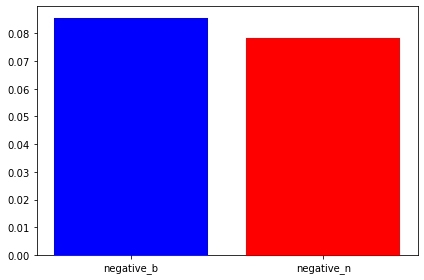

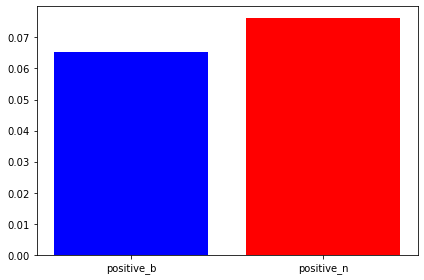

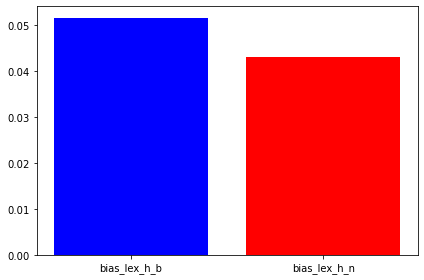

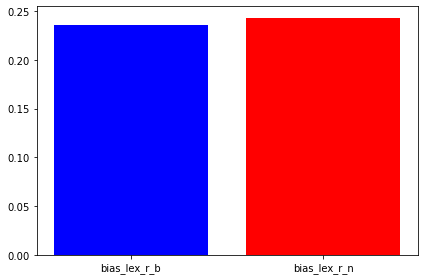

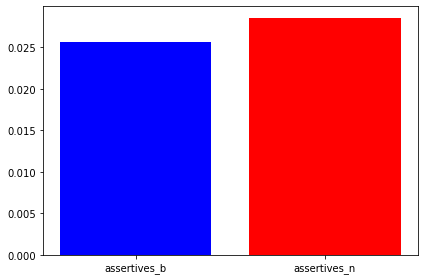

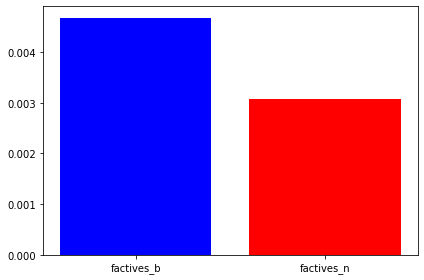

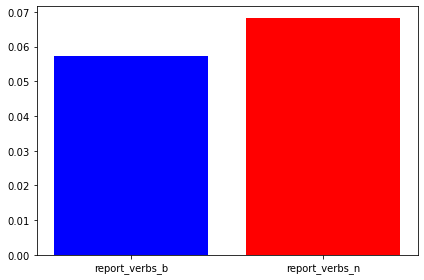

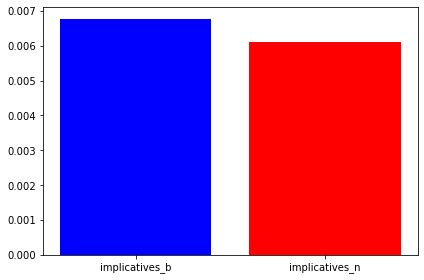

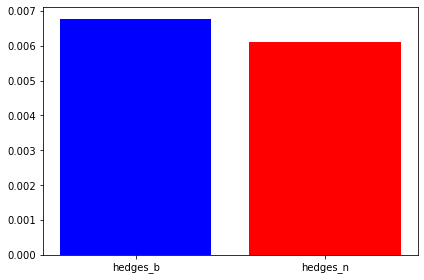

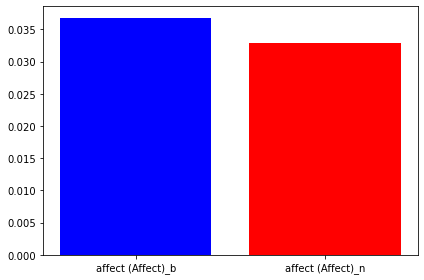

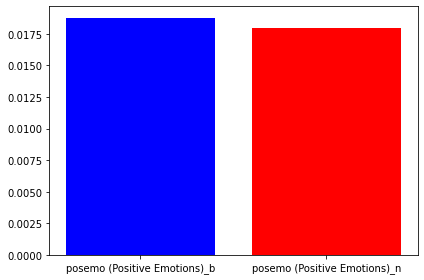

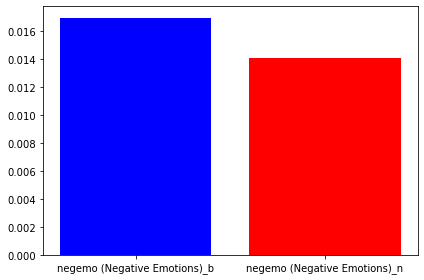

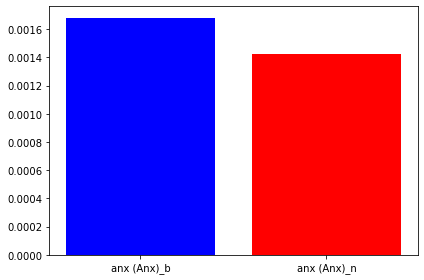

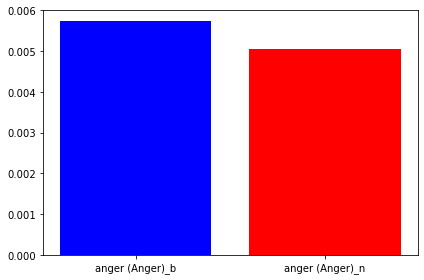

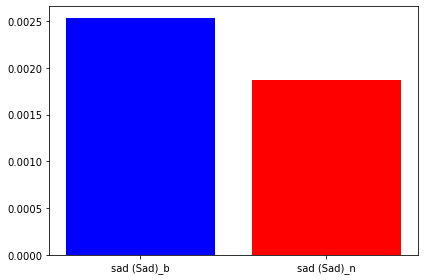

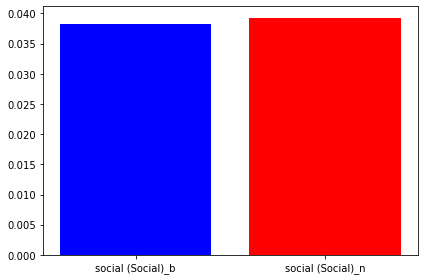

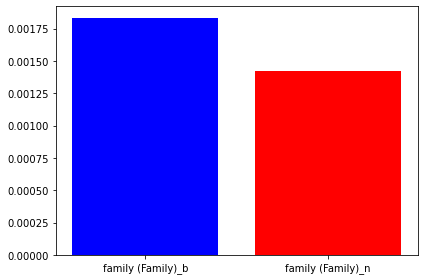

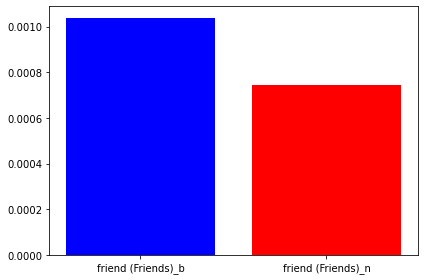

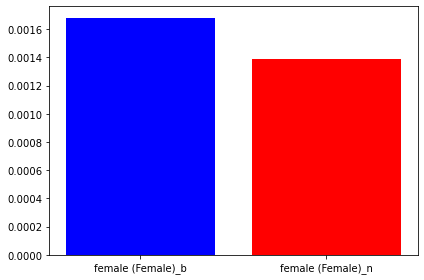

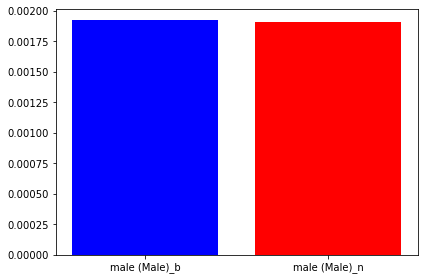

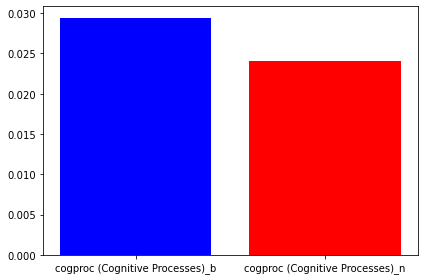

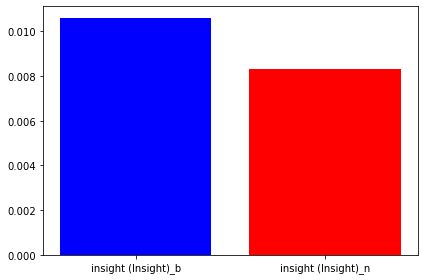

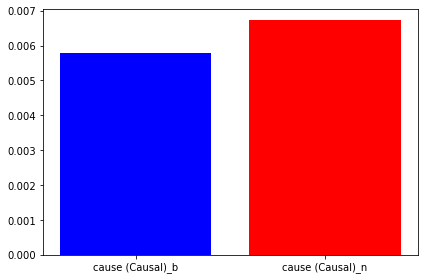

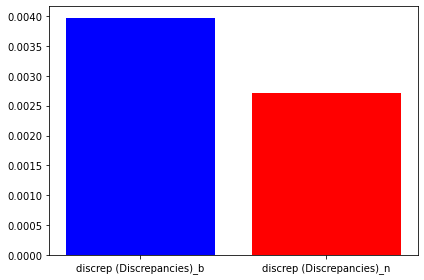

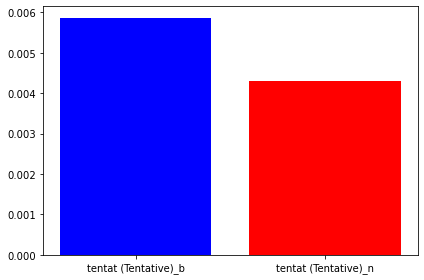

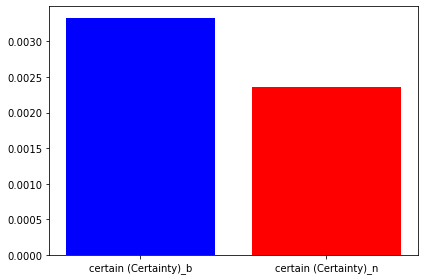

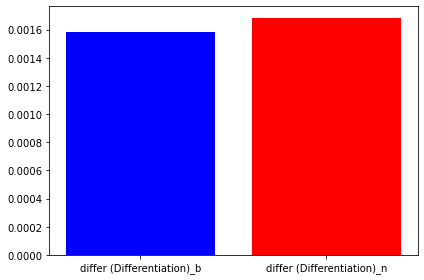

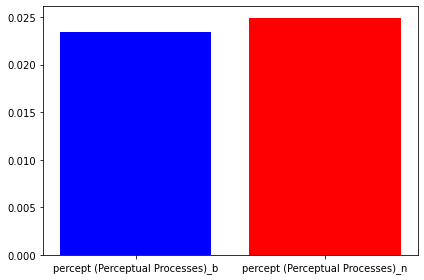

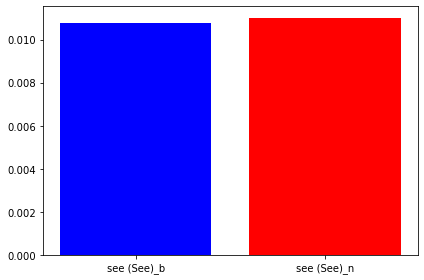

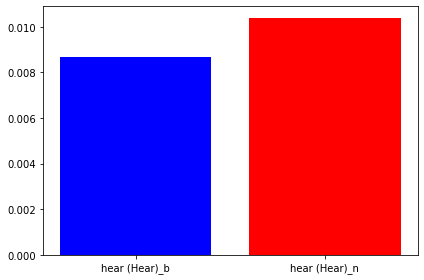

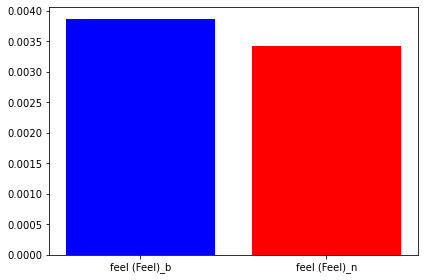

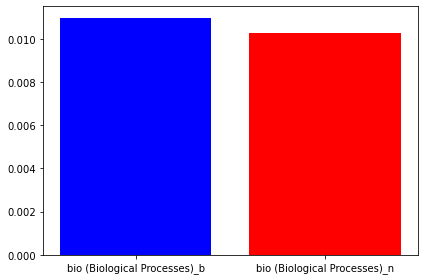

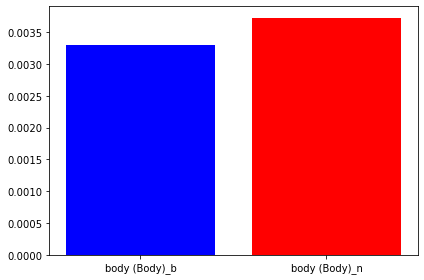

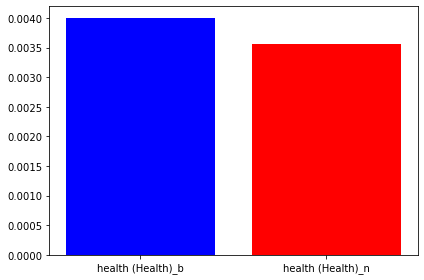

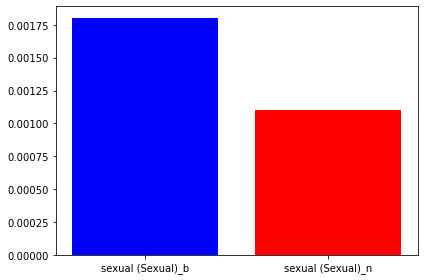

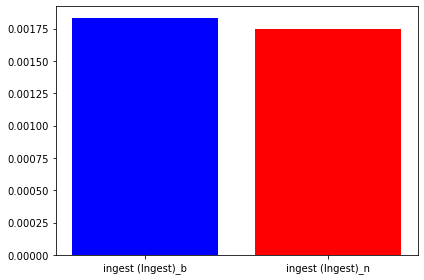

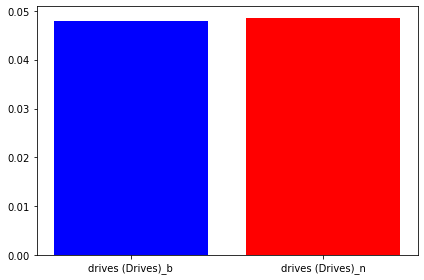

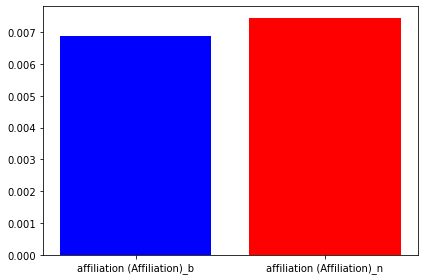

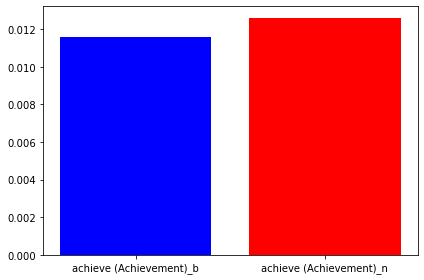

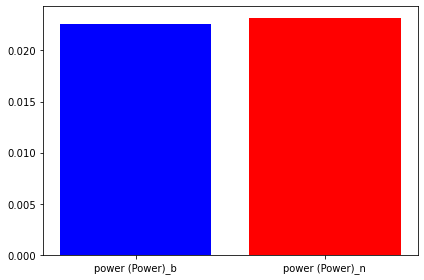

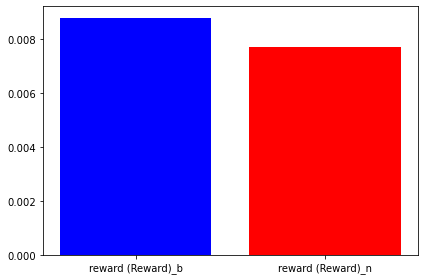

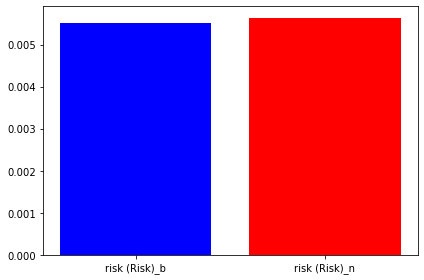

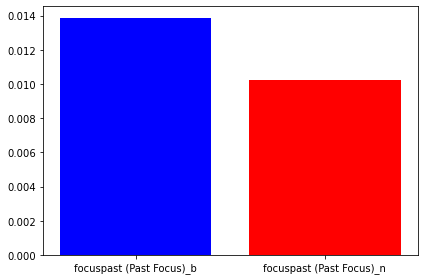

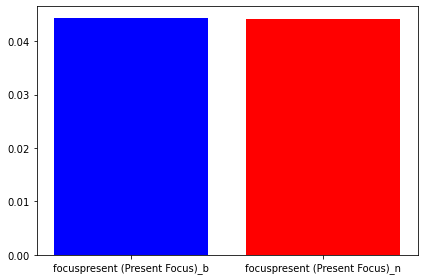

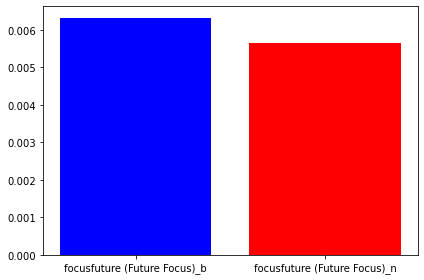

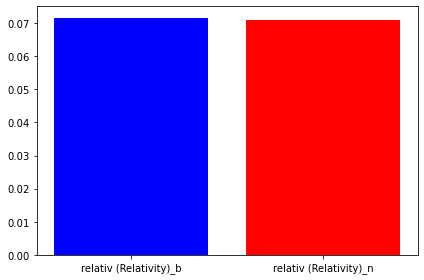

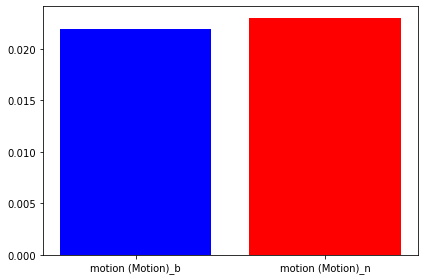

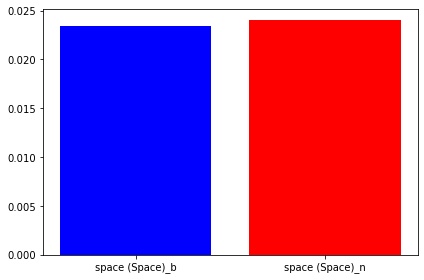

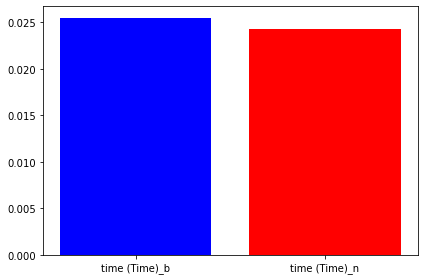

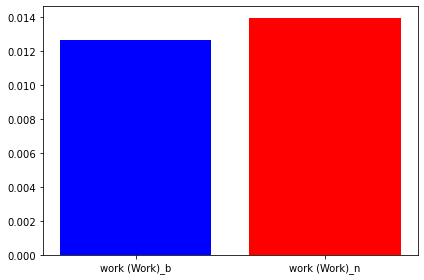

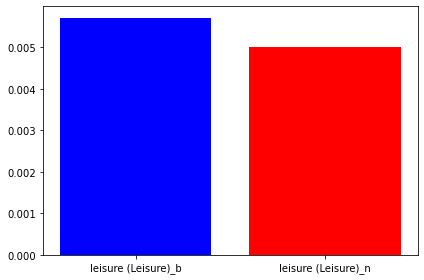

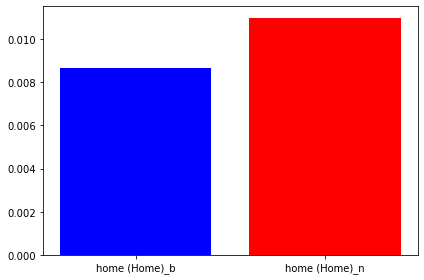

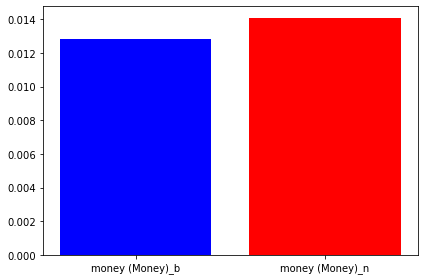

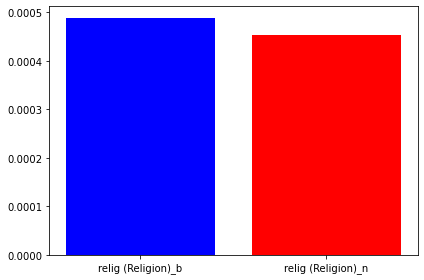

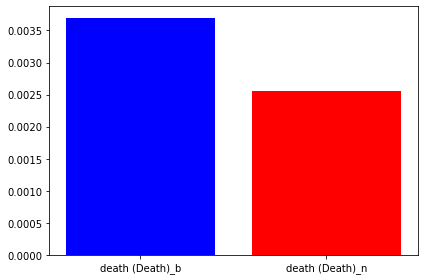

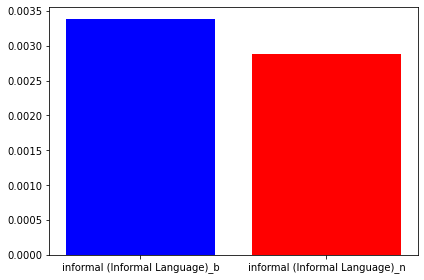

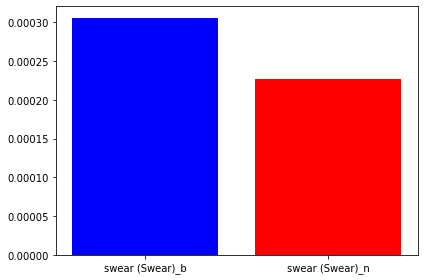

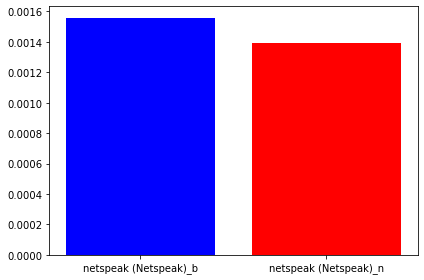

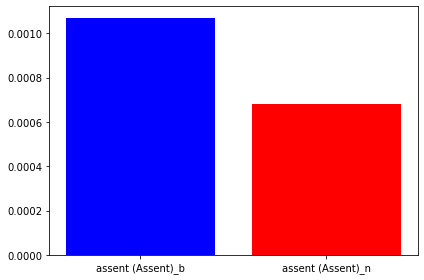

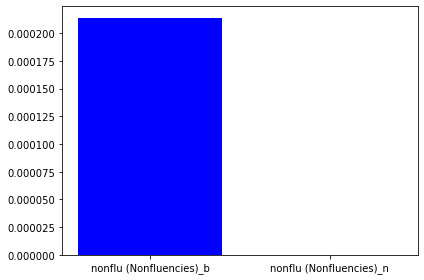

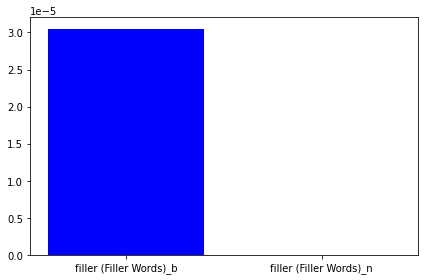

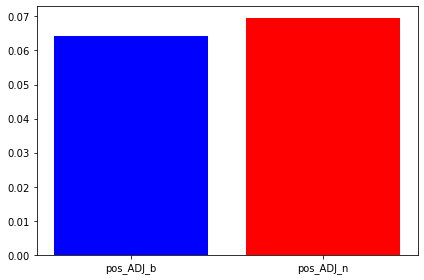

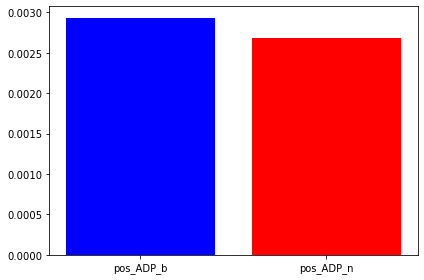

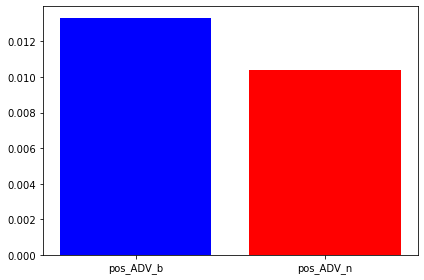

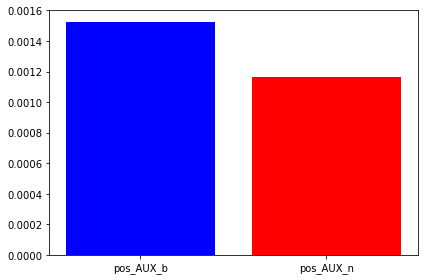

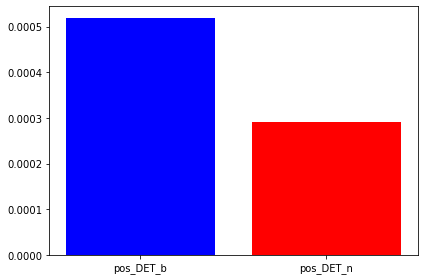

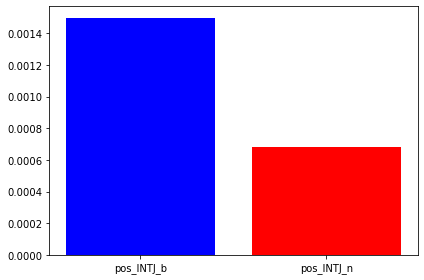

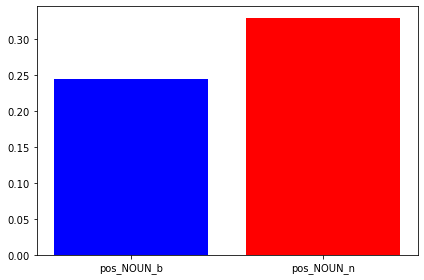

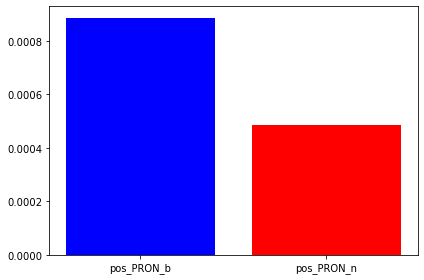

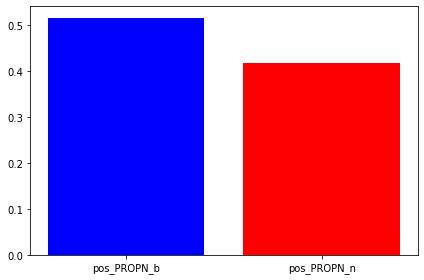

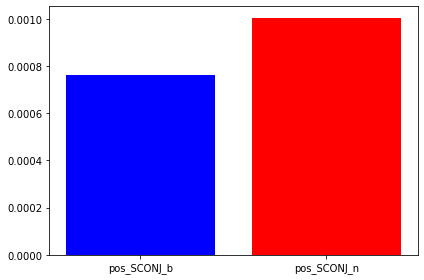

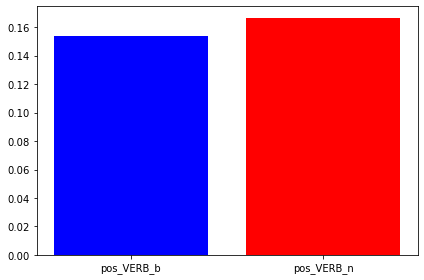

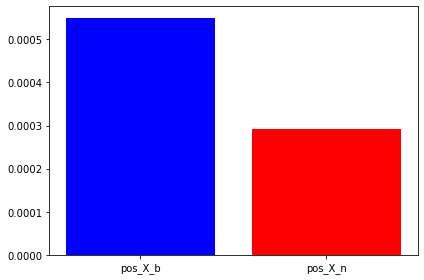

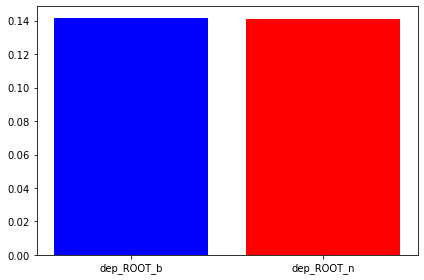

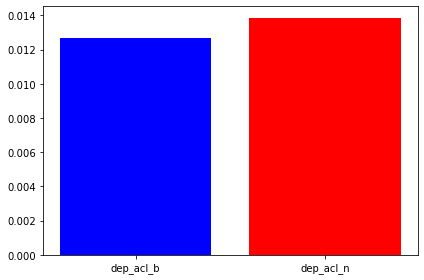

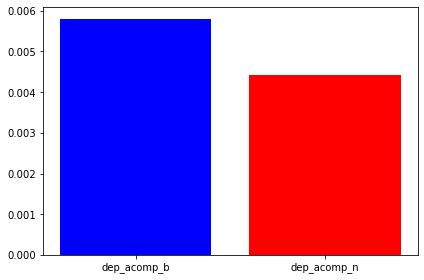

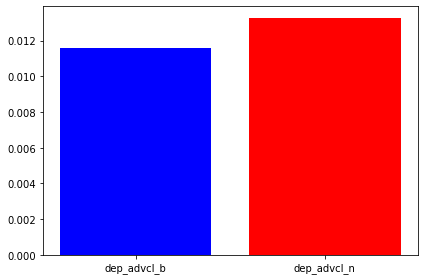

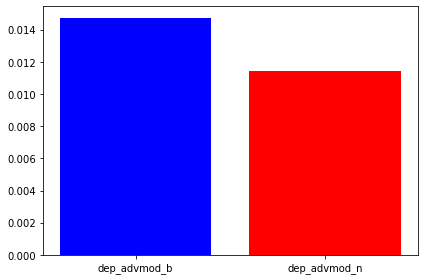

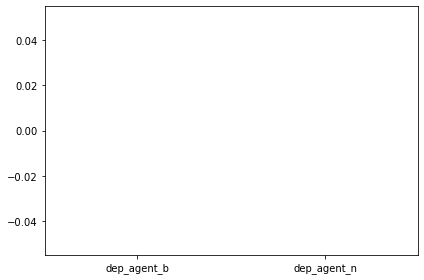

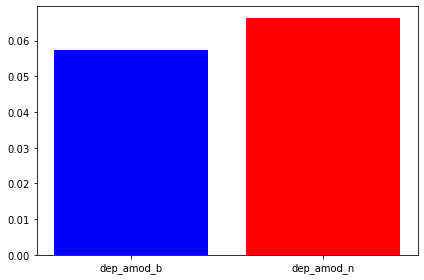

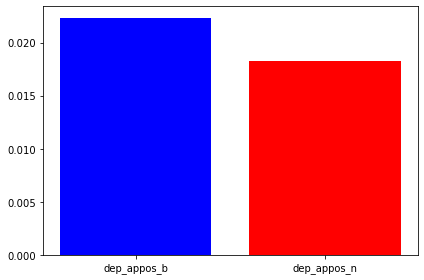

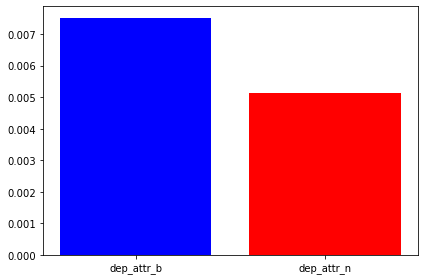

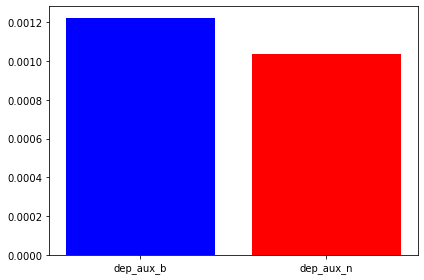

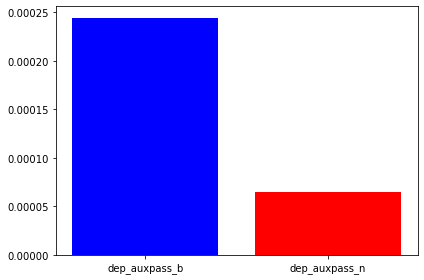

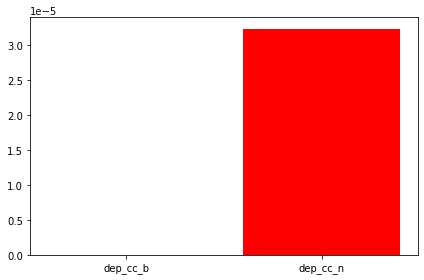

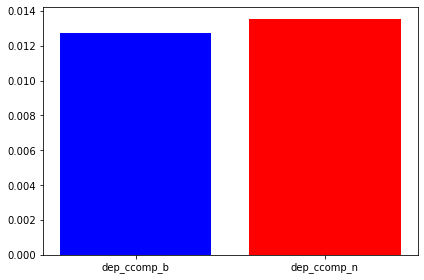

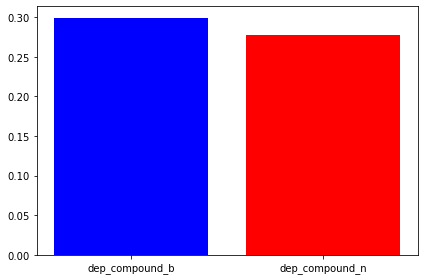

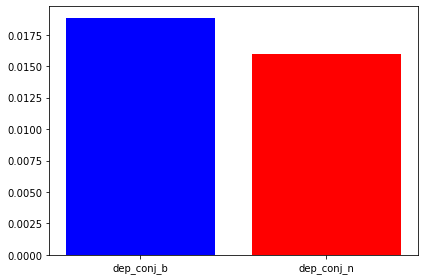

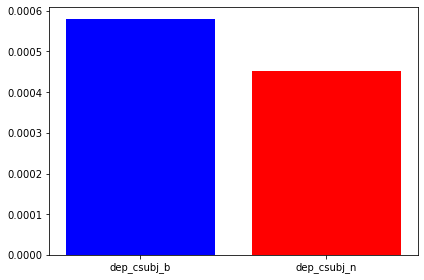

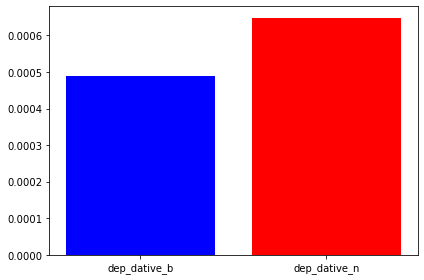

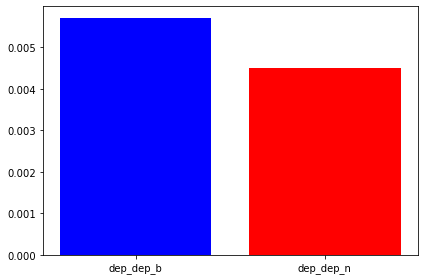

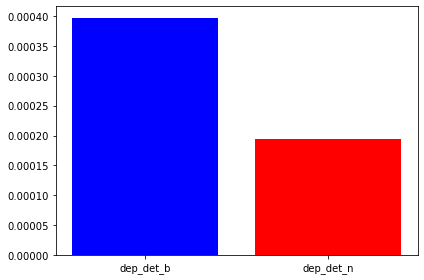

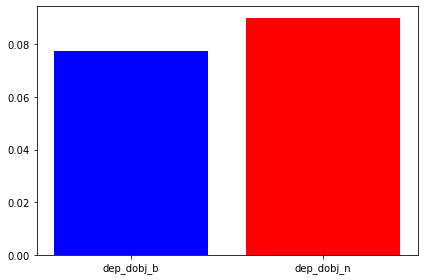

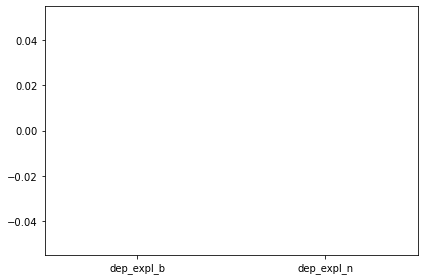

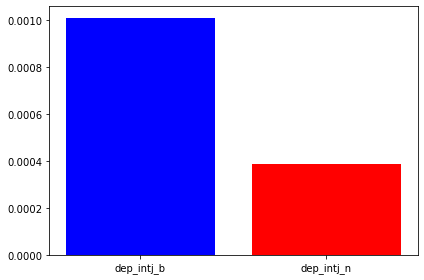

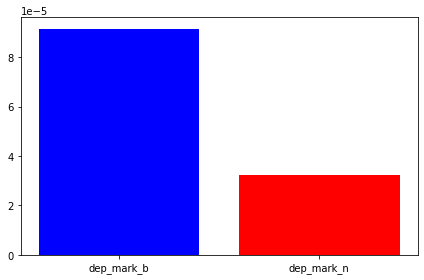

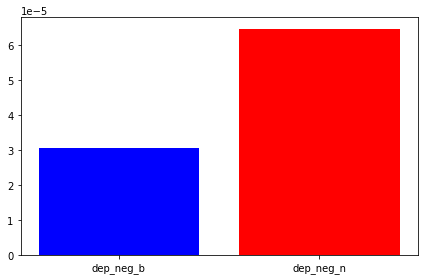

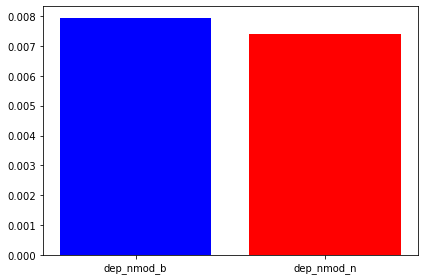

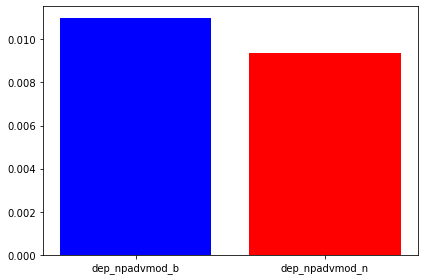

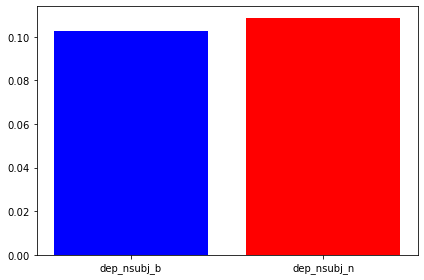

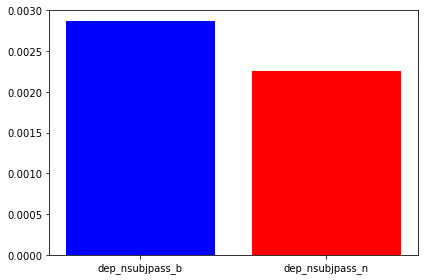

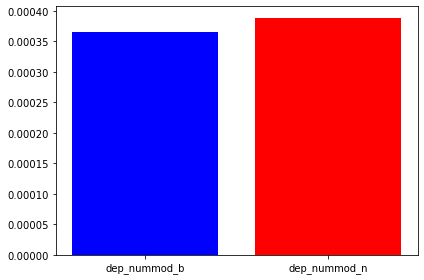

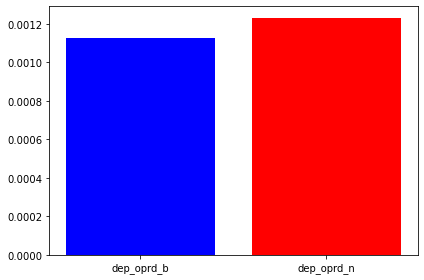

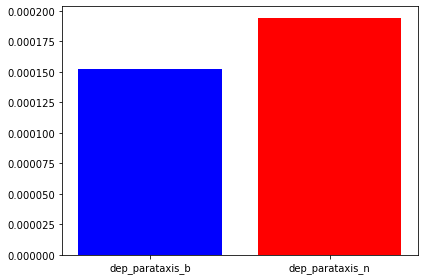

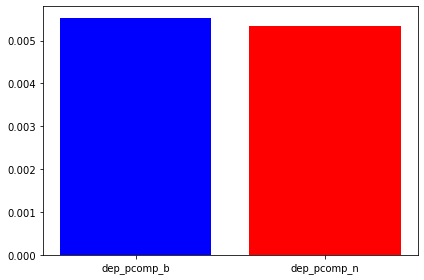

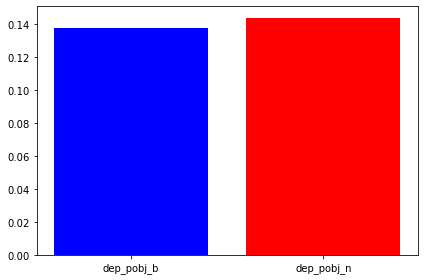

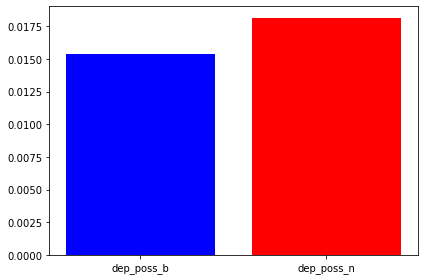

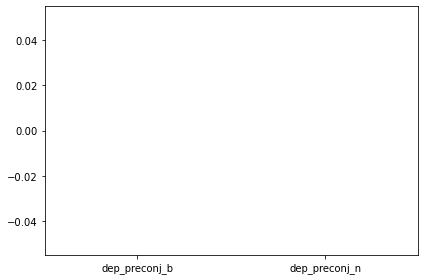

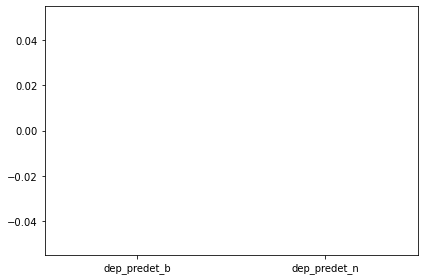

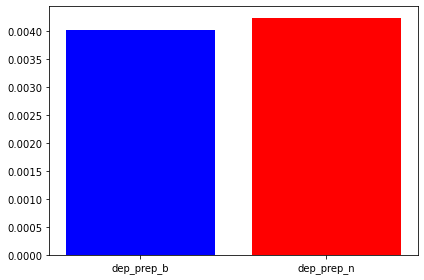

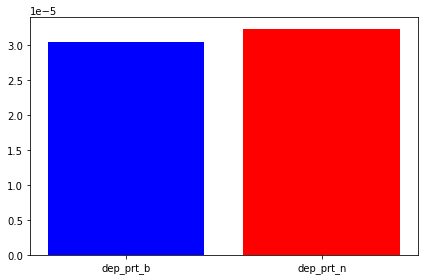

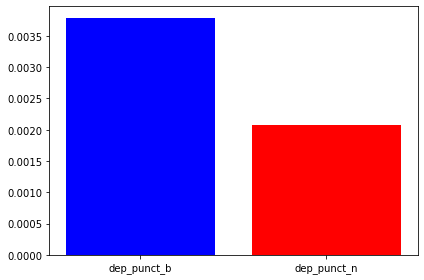

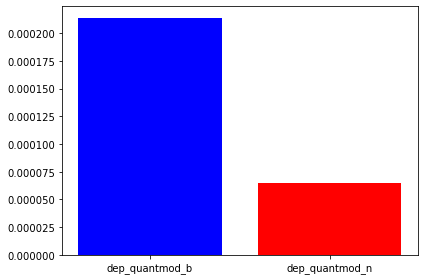

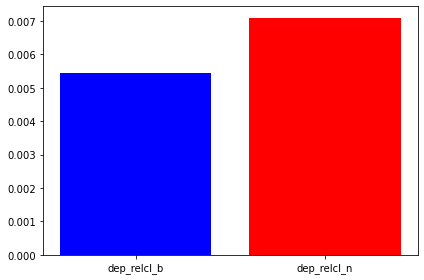

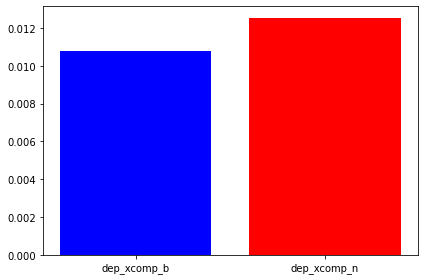

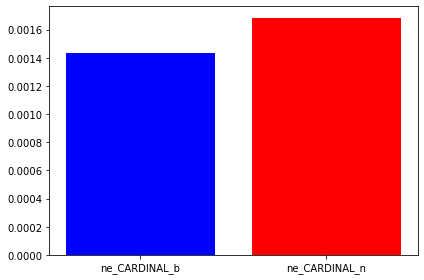

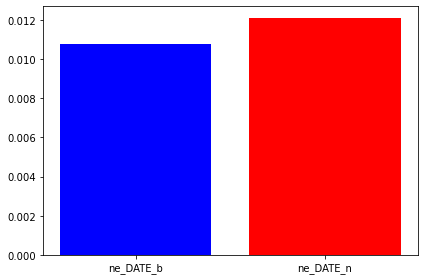

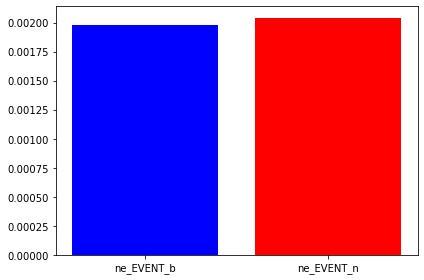

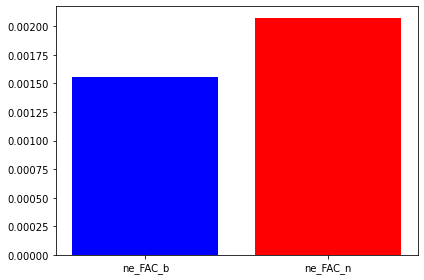

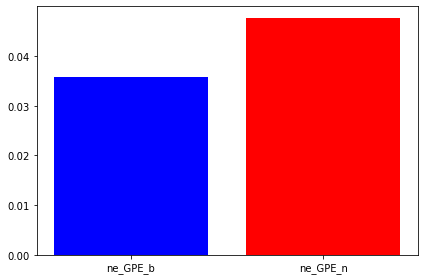

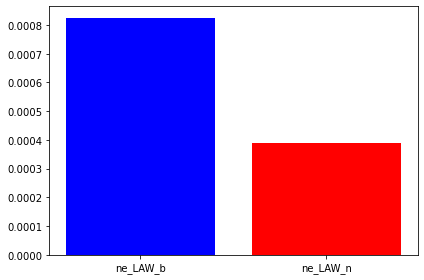

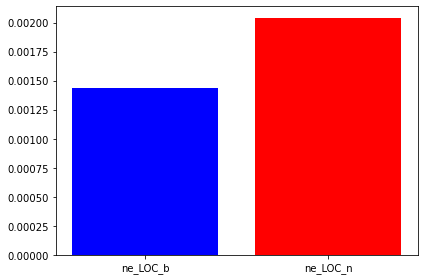

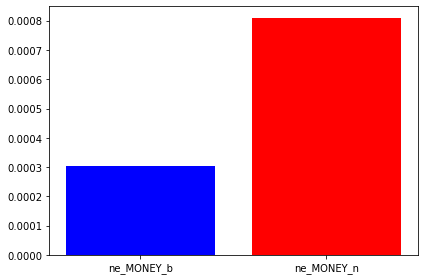

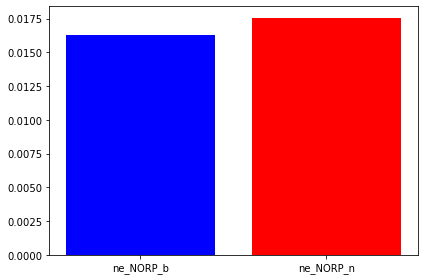

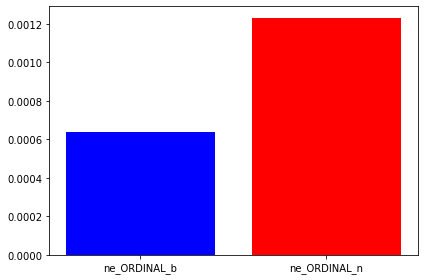

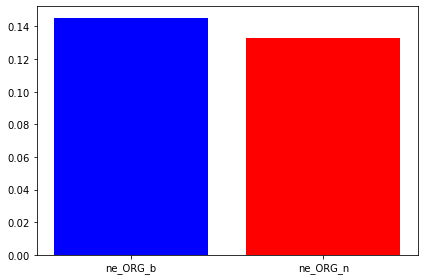

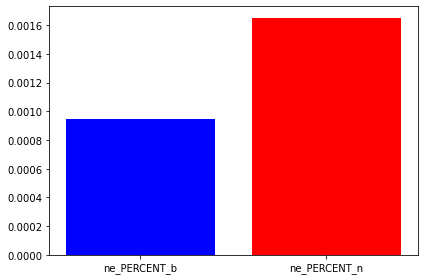

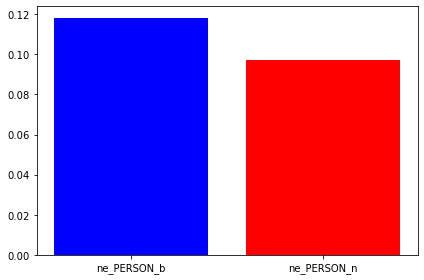

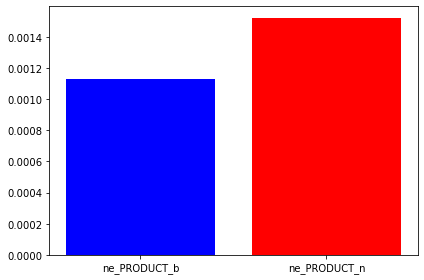

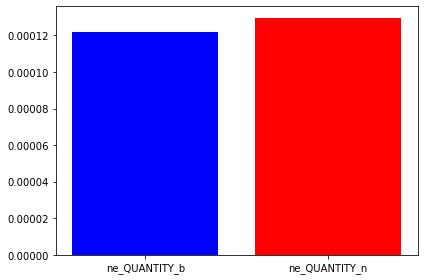

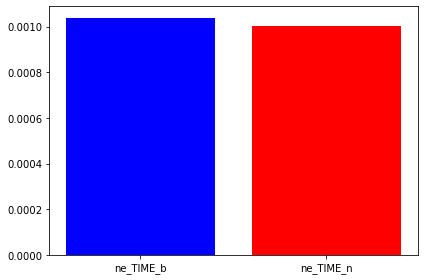

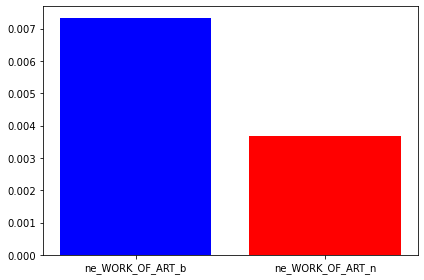

In [131]:
for i in binary_feats:
    gimme_some_bar_plots(i)

In [103]:
import os
os.chdir('C://Users//Jack//Downloads//Neural-Media-Bias-Detection-Using-Distant-Supervision-With-BABE-main//Neural-Media-Bias-Detection-Using-Distant-Supervision-With-BABE-main//data')
babe_wide = pd.read_excel('dt_final_SG2.xlsx')


In [121]:
os.chdir('C://Users//Jack//Downloads//Neural-Media-Bias-Detection-Using-Distant-Supervision-With-BABE-main//Neural-Media-Bias-Detection-Using-Distant-Supervision-With-BABE-main//data')
babe_labels = pd.read_excel('final_labels_SG2.xlsx')

In [173]:
babe_labels

text  \
0     "Orange Is the New Black" star Yael Stone is r...   
1     "We have one beautiful law," Trump recently sa...   
2     ...immigrants as criminals and eugenics, all o...   
3     ...we sounded the alarm in the early months of...   
4     [Black Lives Matter] is essentially a non-fals...   
...                                                 ...   
3669  You’ve heard of Jim Crow and Southern Segregat...   
3670  Young female athletes’ dreams and accomplishme...   
3671  Young white men, reacting to social and educat...   
3672  Young women taking part in high school and col...   
3673  YouTube is making clear there will be no “birt...   

                                              news_link      outlet  \
0     https://www.foxnews.com/entertainment/australi...    Fox News   
1     https://www.alternet.org/2020/06/law-and-order...    Alternet   
2     https://www.nbcnews.com/news/latino/after-step...       MSNBC   
3     https://www.alternet.org/2019/07/fox-news-has-...    Alternet   
4     http://feedproxy.google.com/~r/breitbart/~3/-v...   Breitbart   
...                                                 ...         ...   
3669  http://feedproxy.google.com/~r/breitbart/~3/ei...   Breitbart   
3670  http://feedproxy.google.com/~r/breitbart/~3/eW...   Breitbart   
3671  https://thefederalist.com/2016/05/23/how-anti-...  Federalist   
3672                                                NaN   Breitbart   
3673  https://eu.usatoday.com/story/tech/2020/02/03/...   USA Today   

                  topic    type  label_bias  \
0           environment   right  Non-biased   
1           gun control    left      Biased   
2     white-nationalism    left      Biased   
3     white-nationalism    left      Biased   
4     marriage-equality     NaN      Biased   
...                 ...     ...         ...   
3669  marriage-equality     NaN      Biased   
3670  marriage-equality     NaN      Biased   
3671  white-nationalism   right      Biased   
3672              sport   right      Biased   
3673     elections-2020  center      Biased   

                              label_opinion  \
0                          Entirely factual   
1     Somewhat factual but also opinionated   
2                Expresses writer’s opinion   
3     Somewhat factual but also opinionated   
4                Expresses writer’s opinion   
...                                     ...   
3669             Expresses writer’s opinion   
3670             Expresses writer’s opinion   
3671             Expresses writer’s opinion   
3672  Somewhat factual but also opinionated   
3673                       Entirely factual   

                            biased_words  
0                                     []  
1      ['bizarre', 'characteristically']  
2     ['criminals', 'fringe', 'extreme']  
3                                     []  
4                               ['cult']  
...                                  ...  
3669                             ['ALL']  
3670            ['dashed', '"identify"']  
3671                   ['evil', 'white']  
3672            ['dashed', '"identify"']  
3673                      ['birtherism']  

[3674 rows x 8 columns]

In [149]:
babe_wide

text     outlet           topic  Label  \
0          Orange   Fox News     environment      0   
1              Is   Fox News     environment      0   
2             the   Fox News     environment      0   
3             New   Fox News     environment      0   
4           Black   Fox News     environment      0   
...           ...        ...             ...    ...   
110342       more  USA Today  elections-2020      1   
110343  prevalent  USA Today  elections-2020      1   
110344         in  USA Today  elections-2020      1   
110345        the  USA Today  elections-2020      1   
110346       race  USA Today  elections-2020      1   

                                                 spacy_lg  \
0       (", Orange, Is, the, New, Black, ", star, Yael...   
1       (", Orange, Is, the, New, Black, ", star, Yael...   
2       (", Orange, Is, the, New, Black, ", star, Yael...   
3       (", Orange, Is, the, New, Black, ", star, Yael...   
4       (", Orange, Is, the, New, Black, ", star, Yael...   
...                                                   ...   
110342  (YouTube, is, making, clear, there, will, be, ...   
110343  (YouTube, is, making, clear, there, will, be, ...   
110344  (YouTube, is, making, clear, there, will, be, ...   
110345  (YouTube, is, making, clear, there, will, be, ...   
110346  (YouTube, is, making, clear, there, will, be, ...   

                                            spacy_lg_dict   text_low    pos  \
0       {'text': 'Orange', 'text_low': 'orange', 'pos'...     orange  PROPN   
1       {'text': 'Is', 'text_low': 'is', 'pos': 'AUX',...         is    AUX   
2       {'text': 'the', 'text_low': 'the', 'pos': 'DET...        the    DET   
3       {'text': 'New', 'text_low': 'new', 'pos': 'PRO...        new  PROPN   
4       {'text': 'Black', 'text_low': 'black', 'pos': ...      black  PROPN   
...                                                   ...        ...    ...   
110342  {'text': 'more', 'text_low': 'more', 'pos': 'A...       more    ADV   
110343  {'text': 'prevalent', 'text_low': 'prevalent',...  prevalent    ADJ   
110344  {'text': 'in', 'text_low': 'in', 'pos': 'ADP',...         in    ADP   
110345  {'text': 'the', 'text_low': 'the', 'pos': 'DET...        the    DET   
110346  {'text': 'race', 'text_low': 'race', 'pos': 'N...       race   NOUN   

            lemma  lemma_low  ... ne_NORP_context ne_ORDINAL_context  \
0          Orange     orange  ...               0                  0   
1              be         be  ...               0                  0   
2             the        the  ...               0                  0   
3             New        new  ...               0                  0   
4           Black      black  ...               0                  0   
...           ...        ...  ...             ...                ...   
110342       more       more  ...               0                  0   
110343  prevalent  prevalent  ...               0                  0   
110344         in         in  ...               0                  0   
110345        the        the  ...               0                  0   
110346       race       race  ...               0                  0   

       ne_ORG_context  ne_PERCENT_context  ne_PERSON_context  \
0                   0                   0                  0   
1                   0                   0                  0   
2                   0                   0                  0   
3                   0                   0                  0   
4                   0                   0                  1   
...               ...                 ...                ...   
110342              0                   0                  0   
110343              0                   0                  0   
110344              0                   0                  0   
110345              0                   0                  0   
110346              0                   0                  0   

        ne_PRODUCT_context ne_QUANTI

babe_wide

In [135]:
babe_wide["Label"] = None
for i in range(len(babe_wide["text"])):
    for j in range(len(babe_labels["label_bias"])):
        if babe_wide["sentence"].loc[i] == babe_labels["text"].loc[j]:
            babe_wide["Label"].loc[i] = babe_labels["label_bias"].loc[j]
            
babe_wide["Label"] = babe_wide.Label.apply(lambda x: 1 if x == "Biased" else 0)
babe_wide

C:\Users\Jack\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Unnamed: 0                                           sentence  \
0               0  "Orange Is the New Black" star Yael Stone is r...   
1               3  "Orange Is the New Black" star Yael Stone is r...   
2               4  "Orange Is the New Black" star Yael Stone is r...   
3               5  "Orange Is the New Black" star Yael Stone is r...   
4               6  "Orange Is the New Black" star Yael Stone is r...   
...           ...                                                ...   
65817      110342  YouTube is making clear there will be no “birt...   
65818      110344  YouTube is making clear there will be no “birt...   
65819      110345  YouTube is making clear there will be no “birt...   
65820      110347  YouTube is making clear there will be no “birt...   
65821      110350  YouTube is making clear there will be no “birt...   

          outlet           topic    type  \
0       Fox News     environment   right   
1       Fox News     environment   right   
2       Fox News     environment   right   
3       Fox News     environment   right   
4       Fox News     environment   right   
...          ...             ...     ...   
65817  USA Today  elections-2020  center   
65818  USA Today  elections-2020  center   
65819  USA Today  elections-2020  center   
65820  USA Today  elections-2020  center   
65821  USA Today  elections-2020  center   

                                                 article   biased_words2  \
0      "Orange Is the New Black" star Yael Stone is r...              []   
1      "Orange Is the New Black" star Yael Stone is r...              []   
2      "Orange Is the New Black" star Yael Stone is r...              []   
3      "Orange Is the New Black" star Yael Stone is r...              []   
4      "Orange Is the New Black" star Yael Stone is r...              []   
...                                                  ...             ...   
65817  YouTube is making clear there will be no “birt...  ['birtherism']   
65818  YouTube is making clear there will be no “birt...  ['birtherism']   
65819  YouTube is making clear there will be no “birt...  ['birtherism']   
65820  YouTube is making clear there will be no “birt...  ['birtherism']   
65821  YouTube is making clear there will be no “birt...  ['birtherism']   

             text    text_low    pos  ... ne_ORDINAL_context ne_ORG_context  \
0          Orange      orange  PROPN  ...                  0              0   
1             New         new  PROPN  ...                  0              0   
2           Black       black  PROPN  ...                  0              0   
3            star        star   NOUN  ...                  0              0   
4            Yael        yael  PROPN  ...                  0              0   
...           ...         ...    ...  ...                ...            ...   
65817        type        type   NOUN  ...                  0              0   
65818  conspiracy  conspiracy   NOUN  ...                  0              0   
65819      theory      theory   NOUN  ...                  0              0   
65820   prevalent   prevalent    ADJ  ...                  0              0   
65821        race        race   NOUN  ...                  0              0   

      ne_PERCENT_context ne_PERSON_context  ne_PRODUCT_context  \
0                      0                 0                   0   
1                      0                 0                   0   
2                      0                 1                   0   
3                      0                 1                   0   
4                      0                 1                   0   
...                  ...               ...                 ...   
65817                  0                 0                   0   
65818                  0                 0                   0   
65819                  0                 0                   0   
65820                  0                 0                   0   
65821                  0 

In [136]:
babe_wide["Label"]

0        0
1        0
2        0
3        0
4        0
        ..
65817    1
65818    1
65819    1
65820    1
65821    1
Name: Label, Length: 65822, dtype: int64

In [150]:
feats_avg_bb = [a + b for a, b in zip(binary_feats, len(binary_feats)*['_bb'])]
feats_avg_bn = [a + b for a, b in zip(binary_feats, len(binary_feats)*['_bn'])]

In [151]:
babe_wide = babe_final

In [152]:
feats_avg_bb = {i : 0.0 for i in feats_avg_bb}
feats_avg_bn = {i : 0.0 for i in feats_avg_bn}

In [153]:
for i in binary_feats:
    feats_avg_bb[i + '_bb'] = babe_wide[i][babe_wide["Label"] == 1].mean()
    feats_avg_bn[i + '_bn'] = babe_wide[i][babe_wide["Label"] == 0].mean()

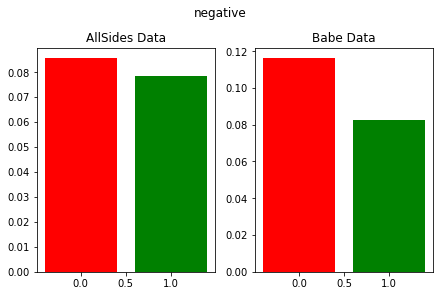

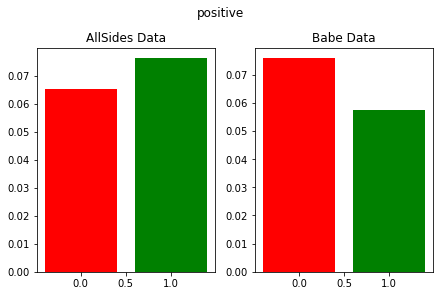

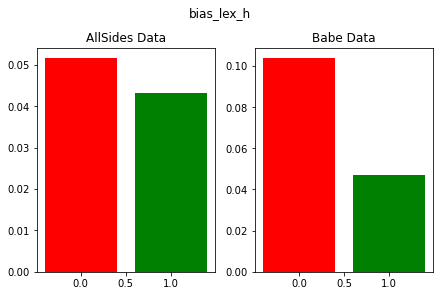

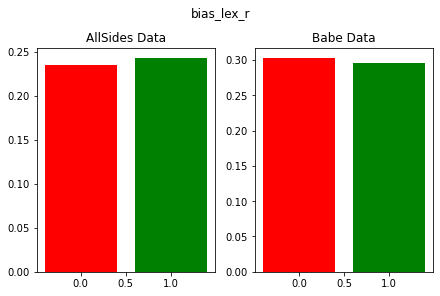

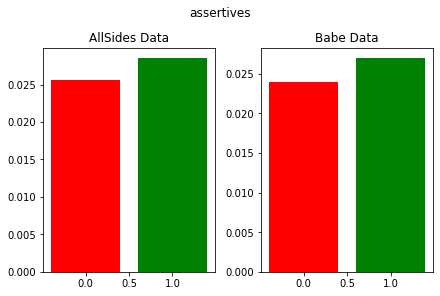

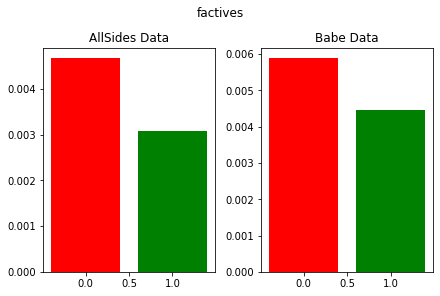

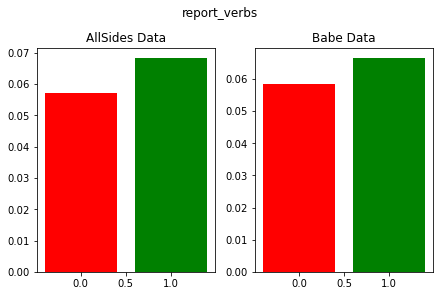

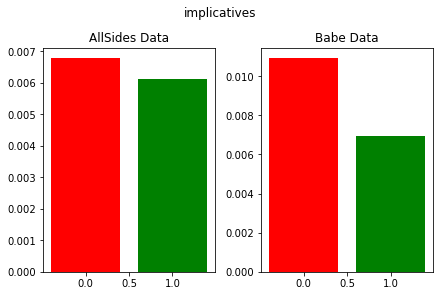

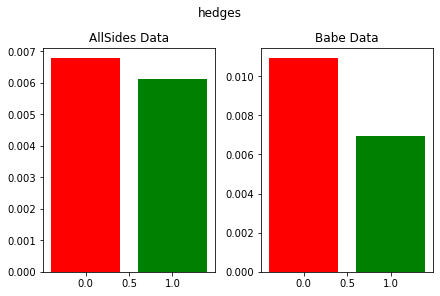

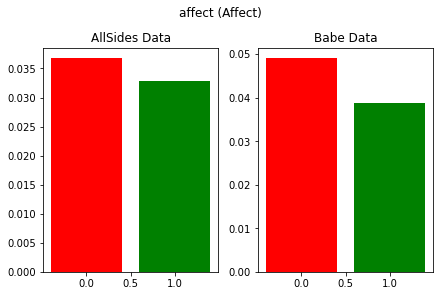

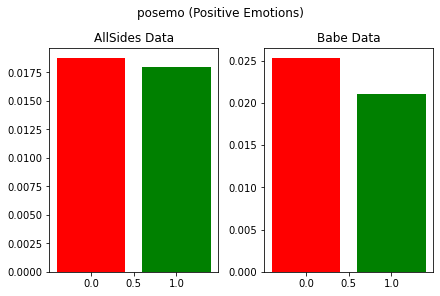

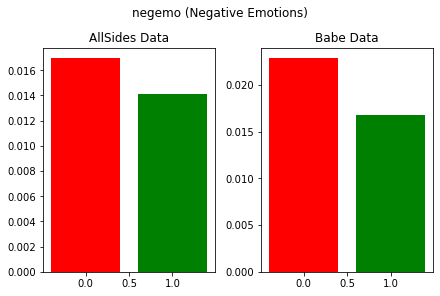

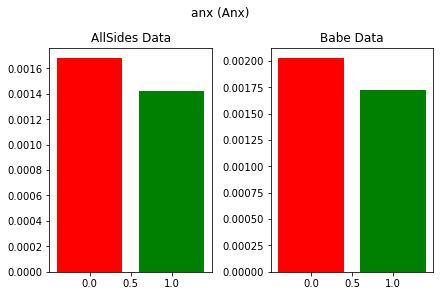

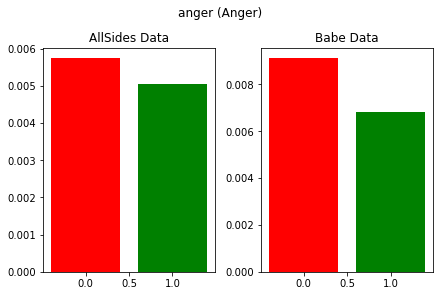

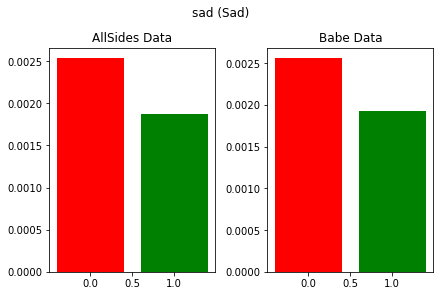

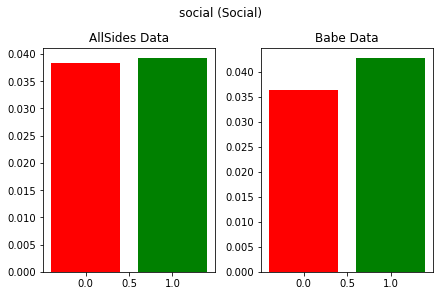

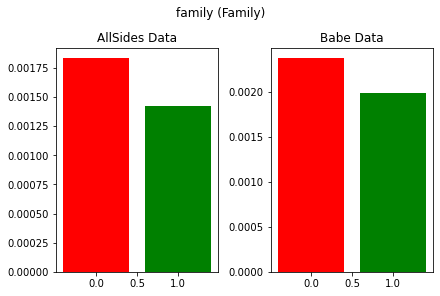

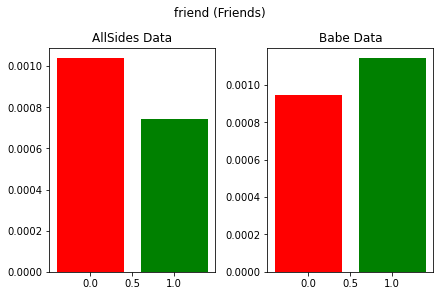

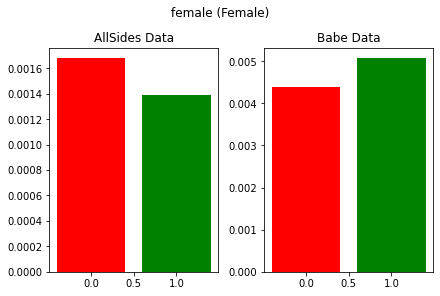

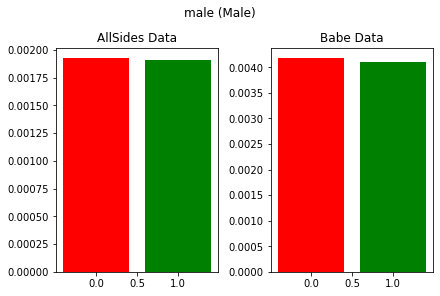

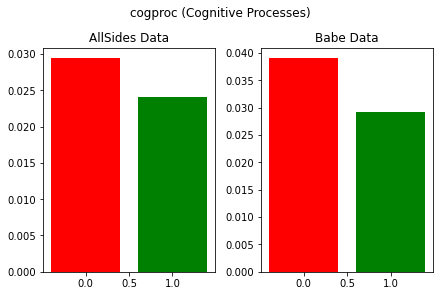

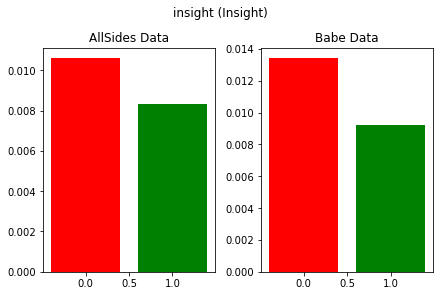

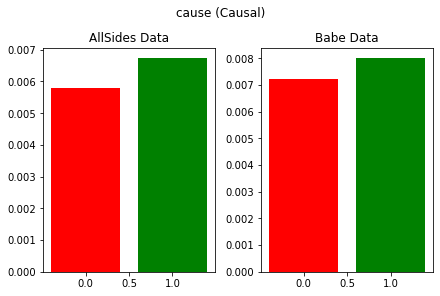

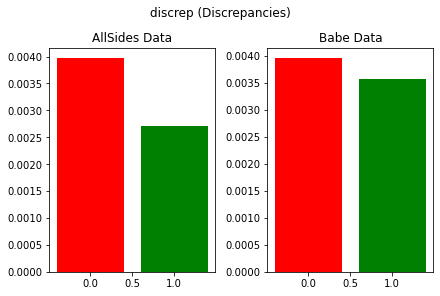

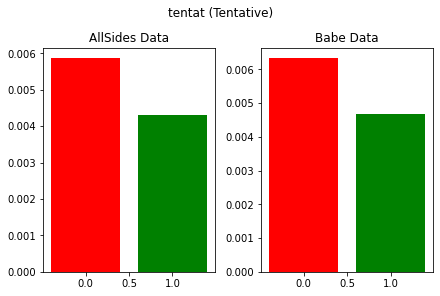

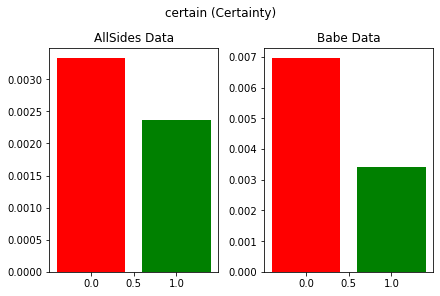

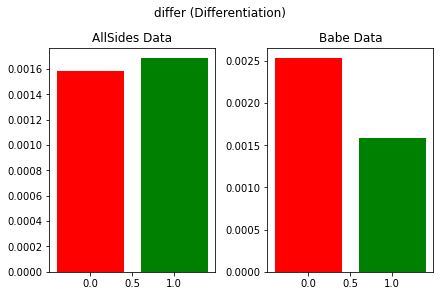

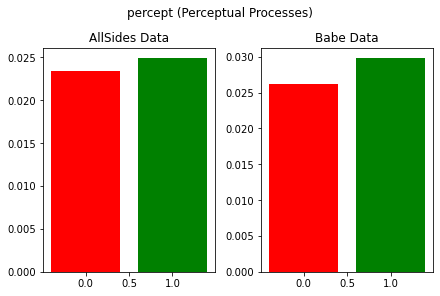

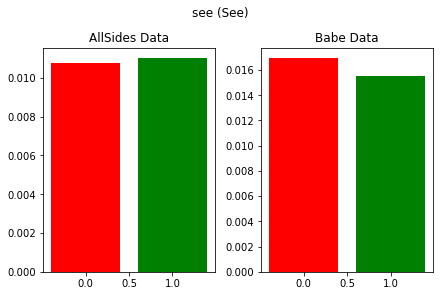

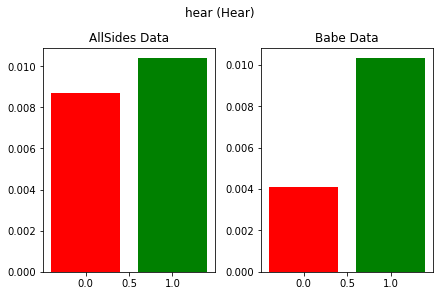

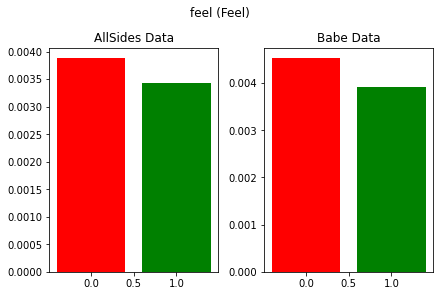

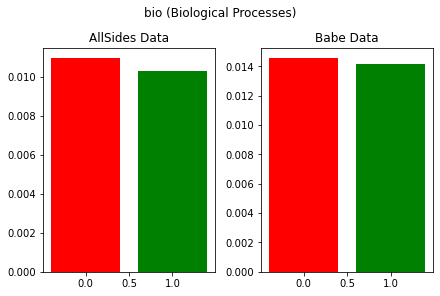

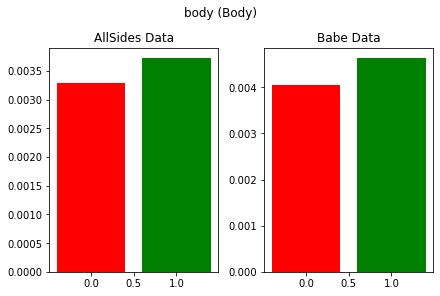

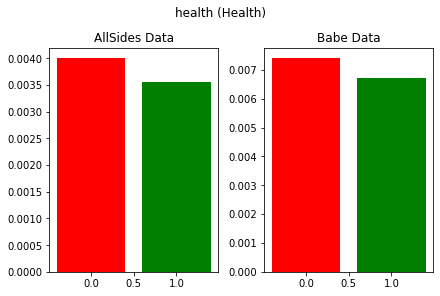

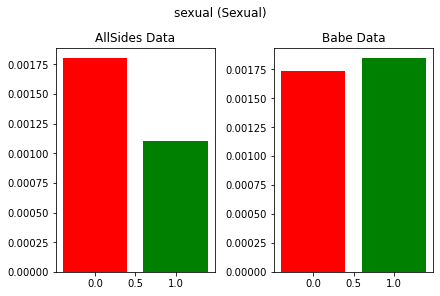

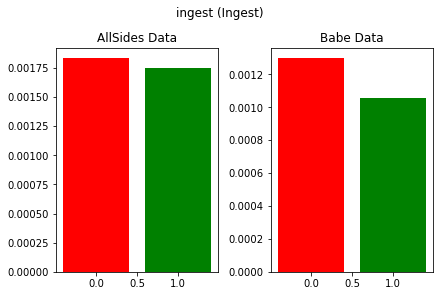

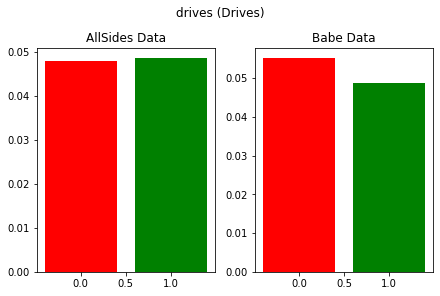

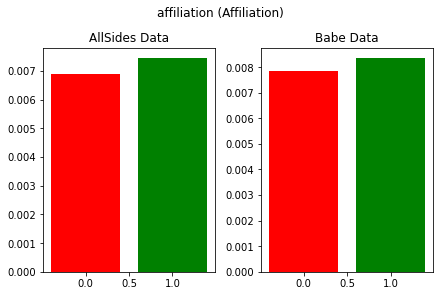

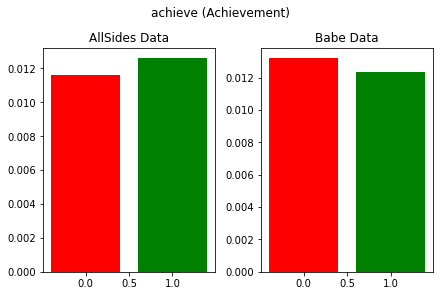

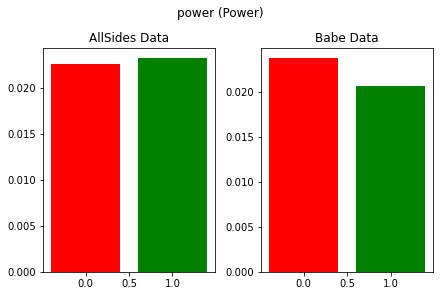

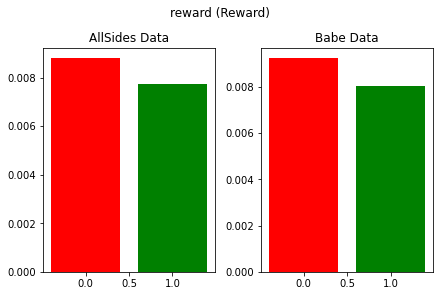

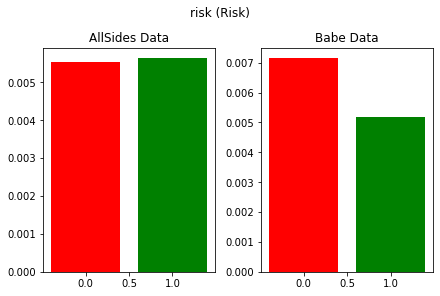

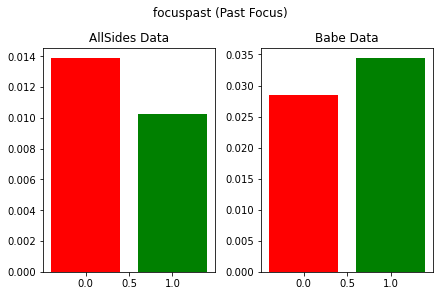

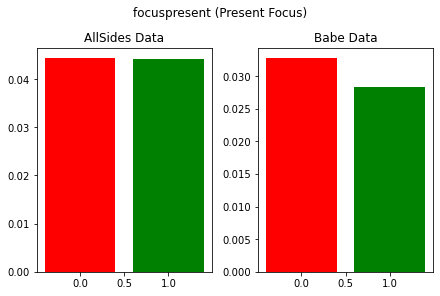

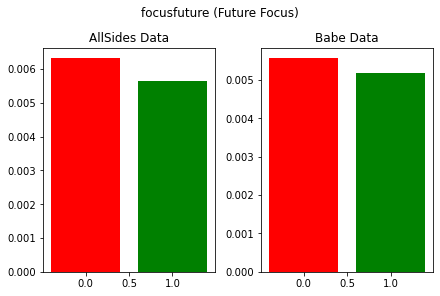

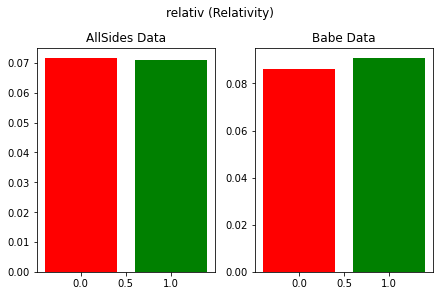

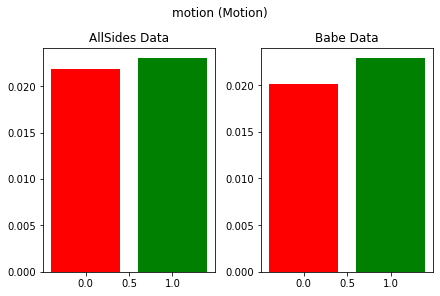

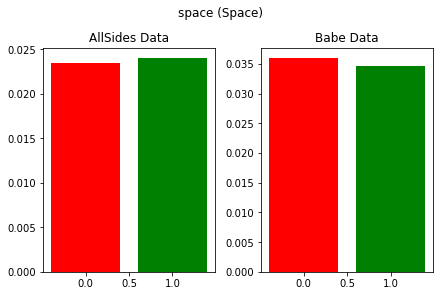

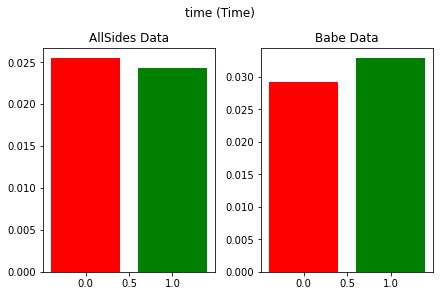

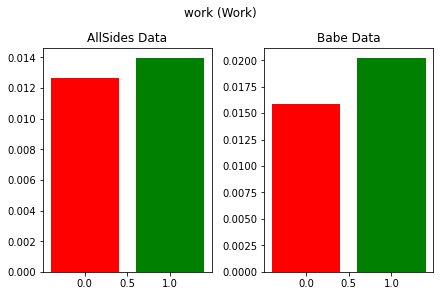

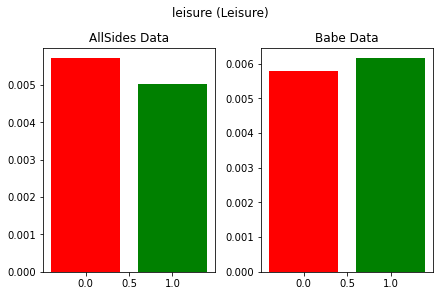

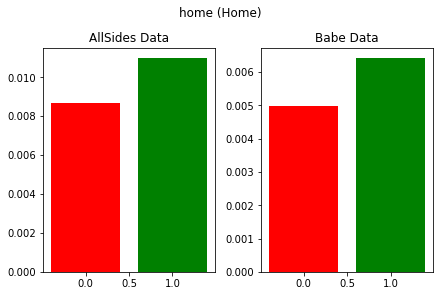

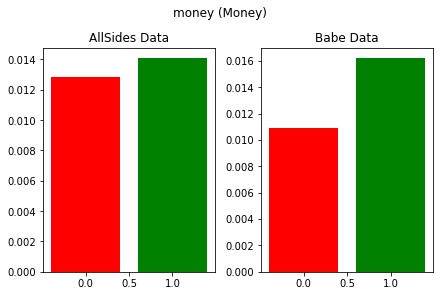

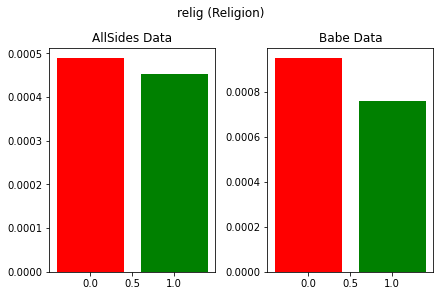

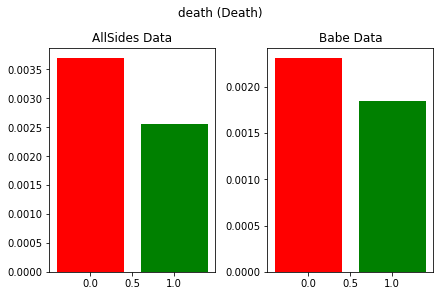

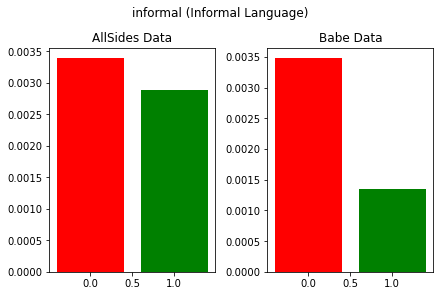

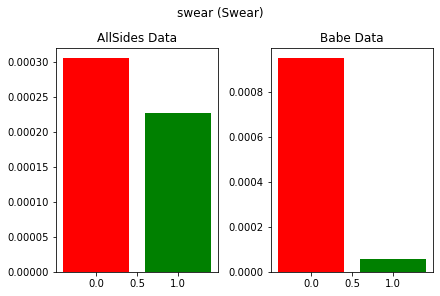

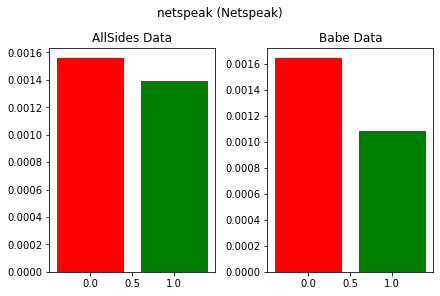

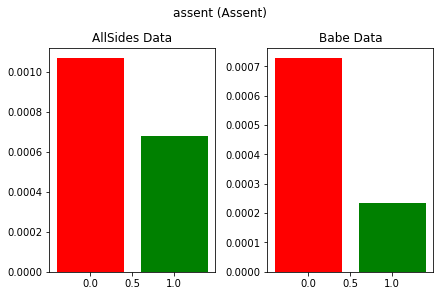

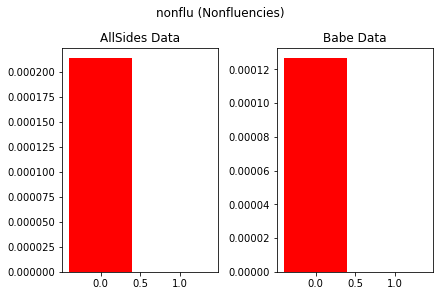

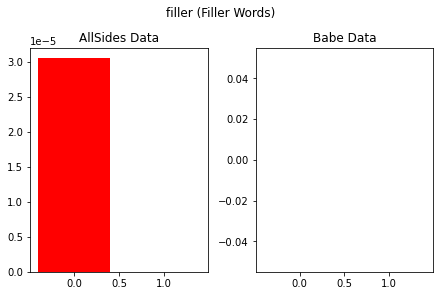

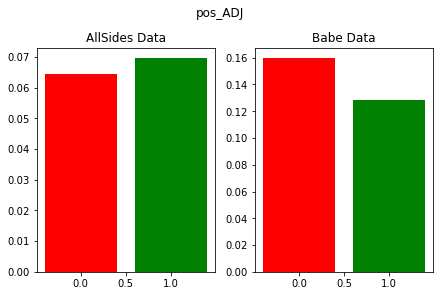

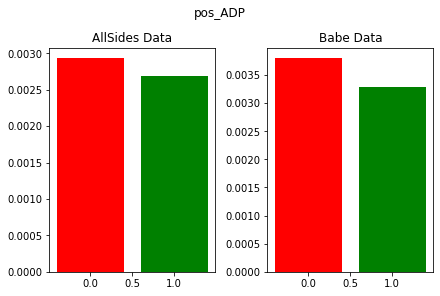

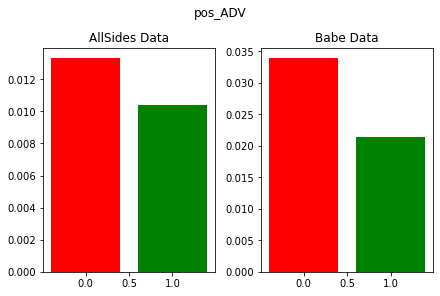

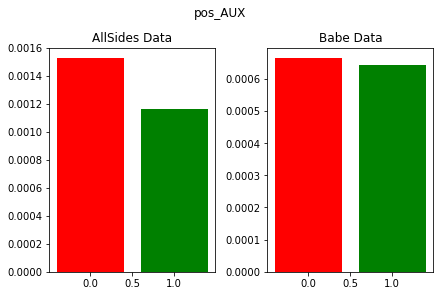

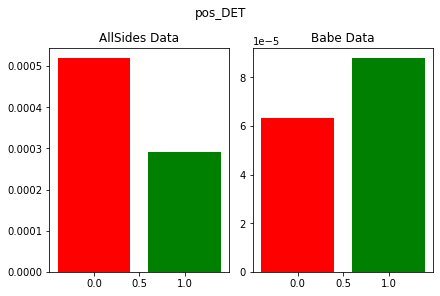

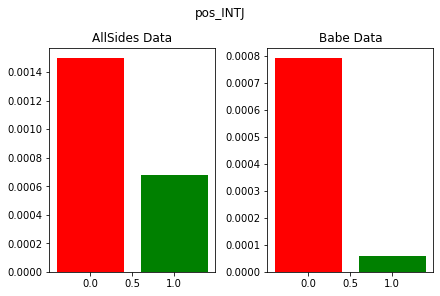

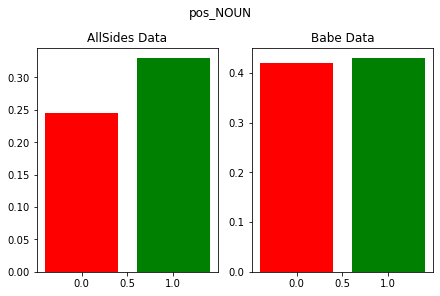

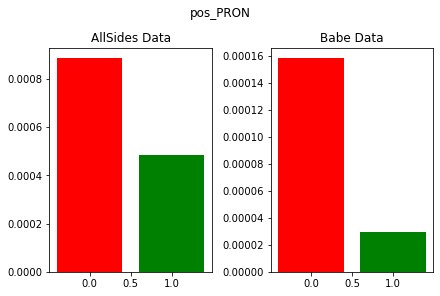

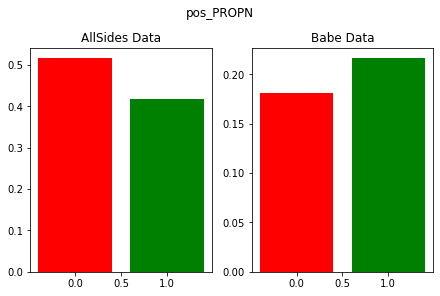

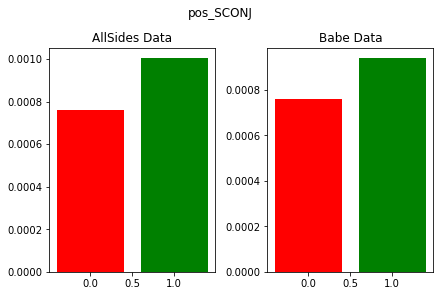

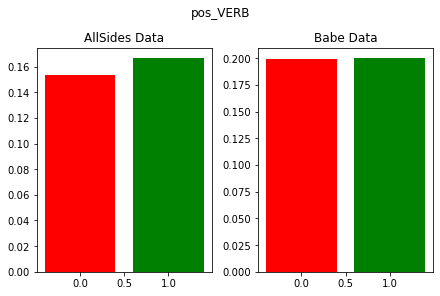

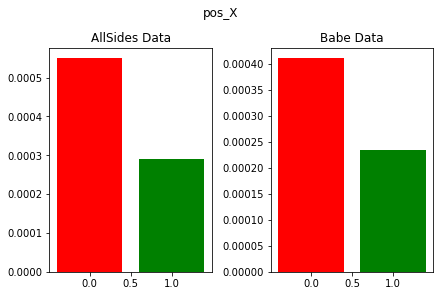

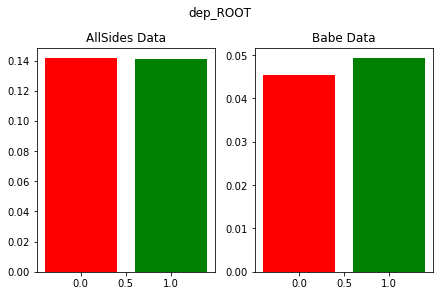

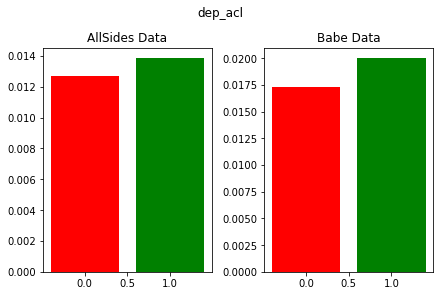

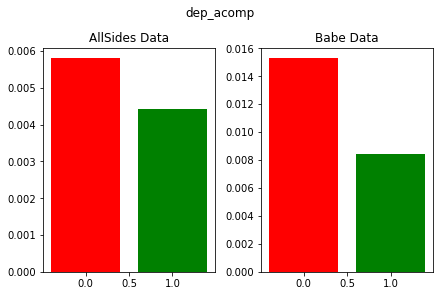

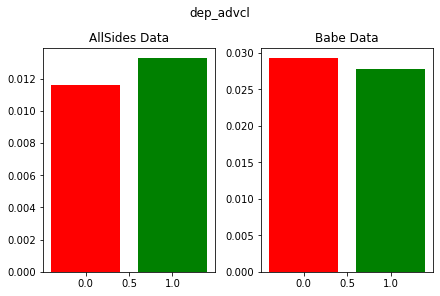

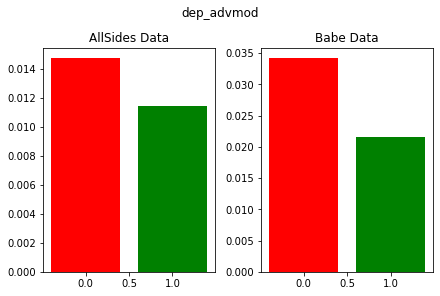

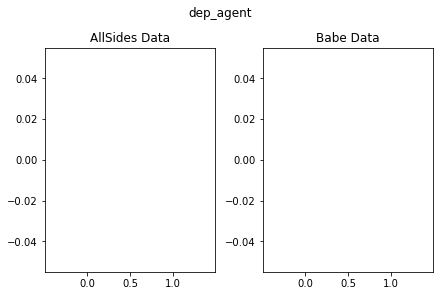

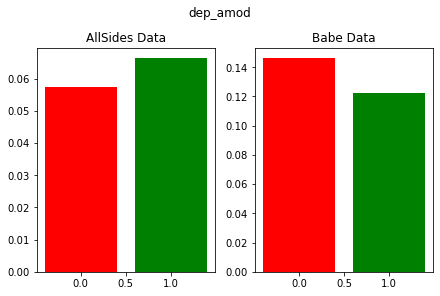

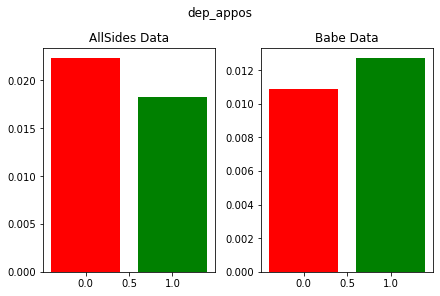

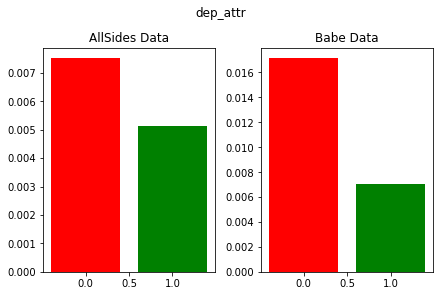

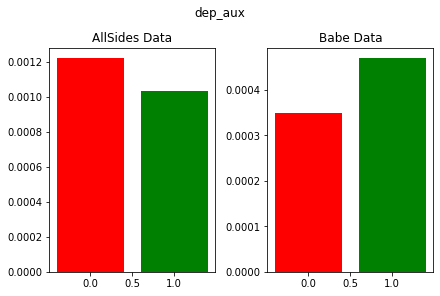

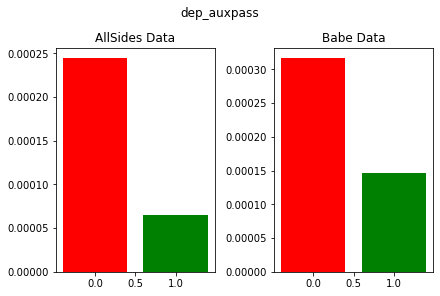

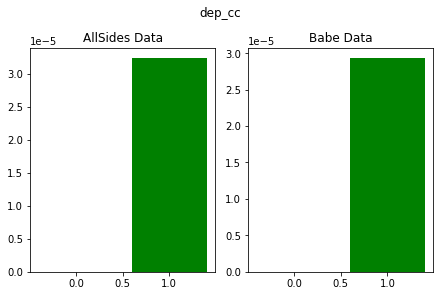

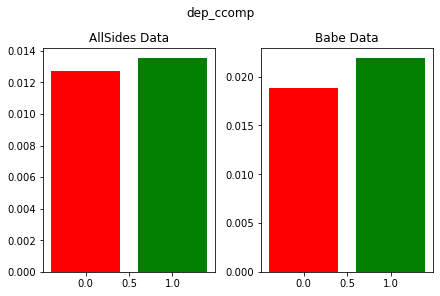

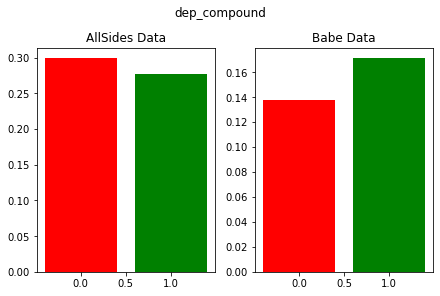

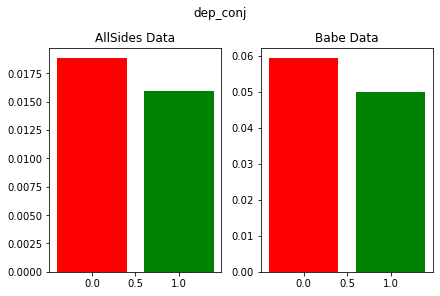

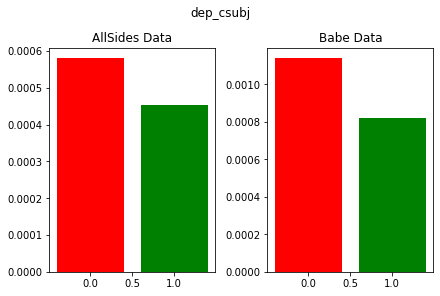

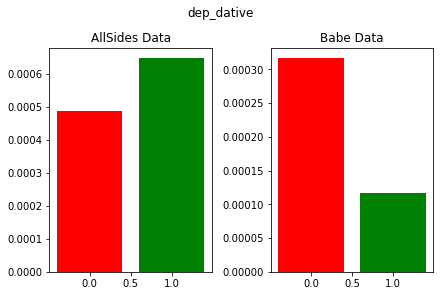

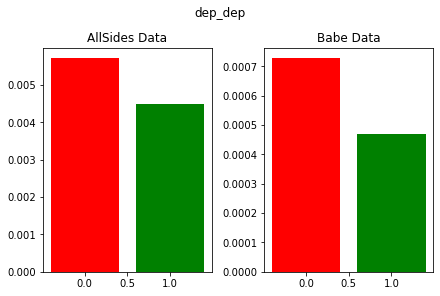

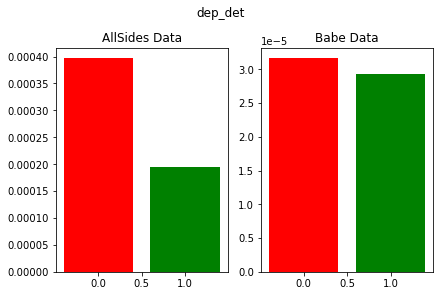

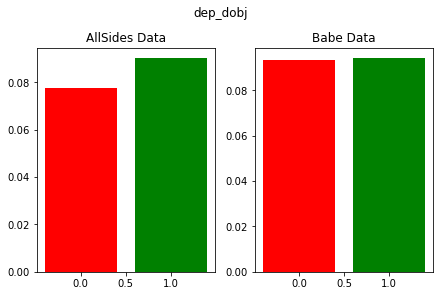

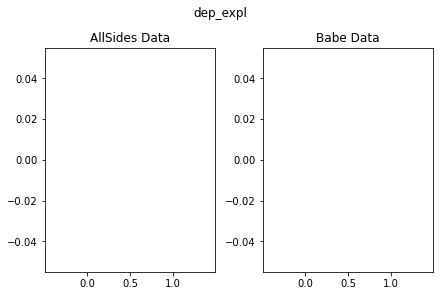

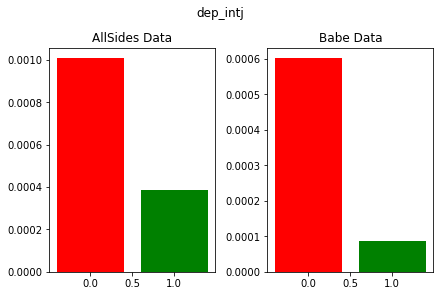

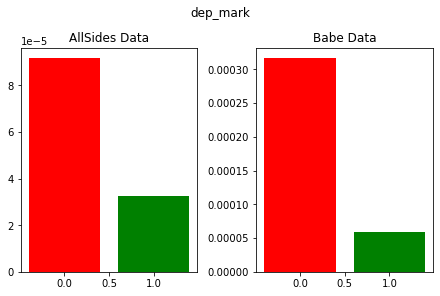

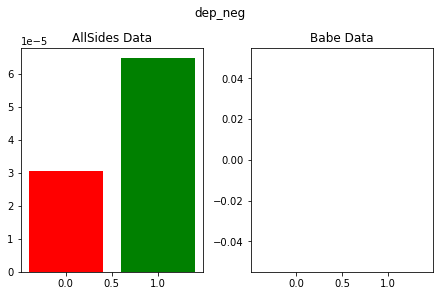

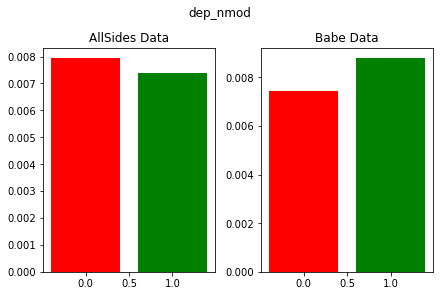

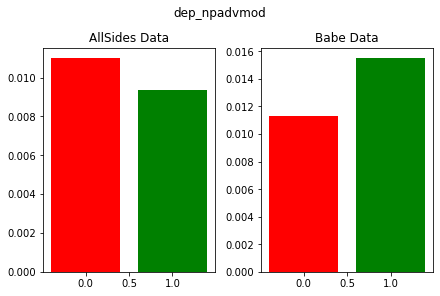

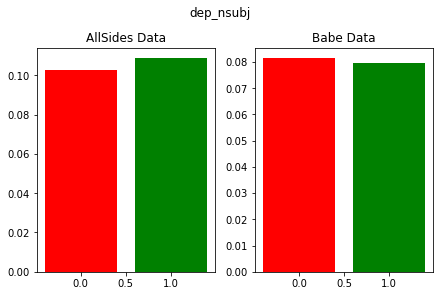

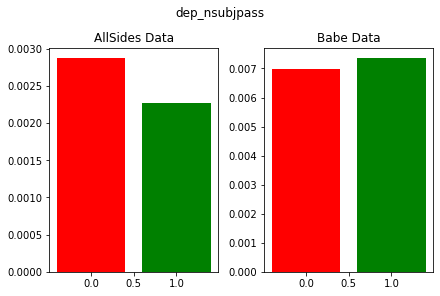

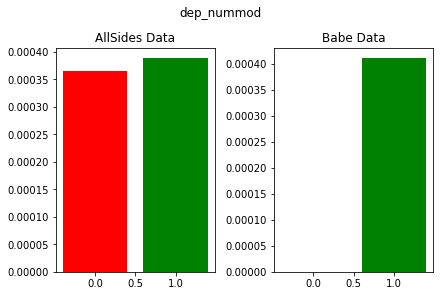

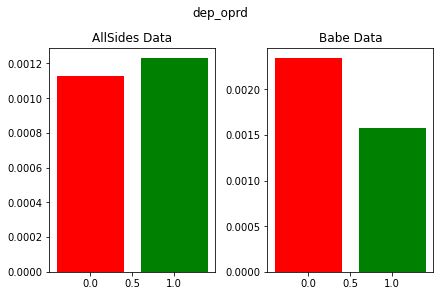

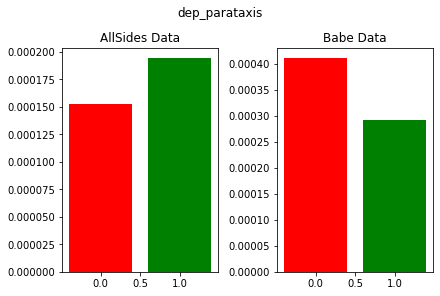

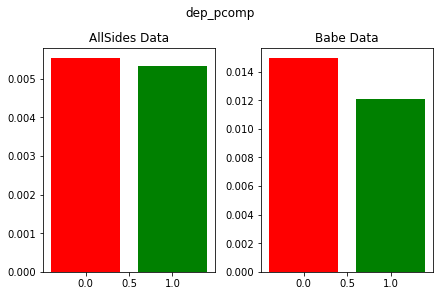

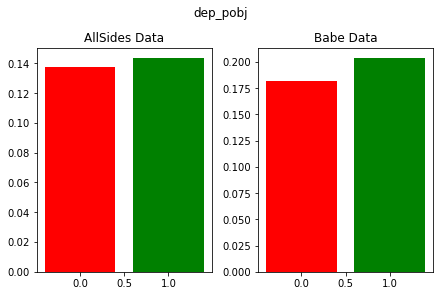

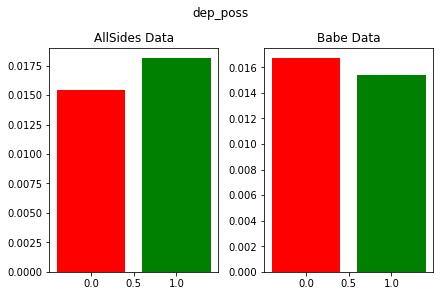

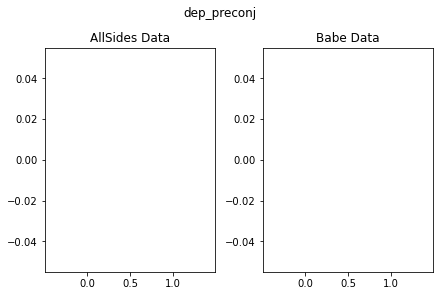

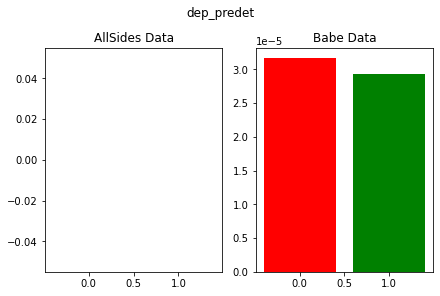

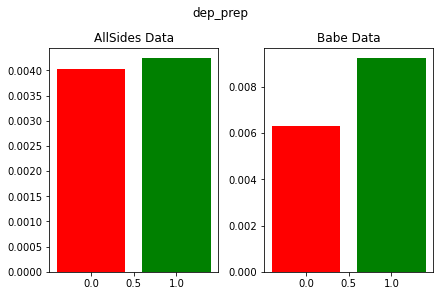

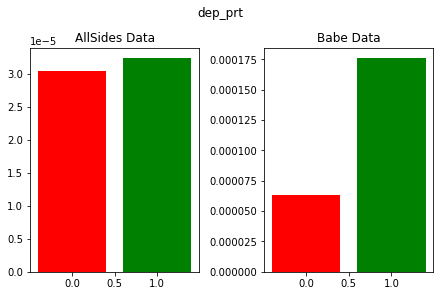

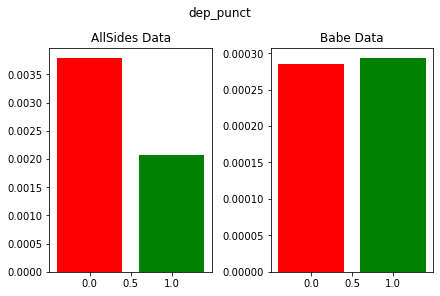

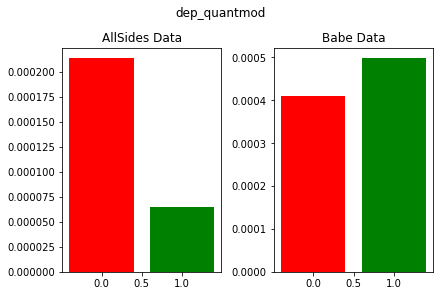

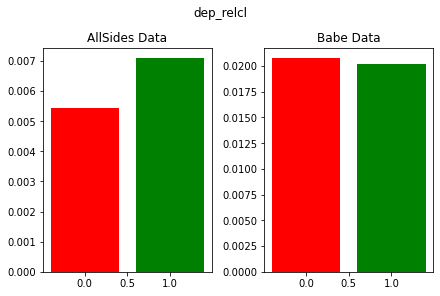

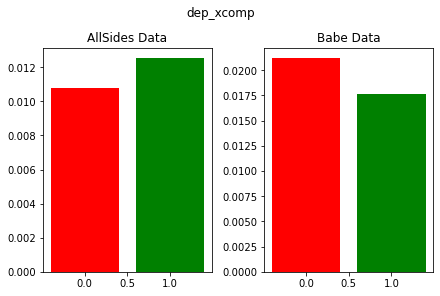

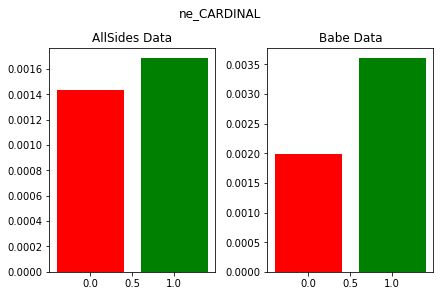

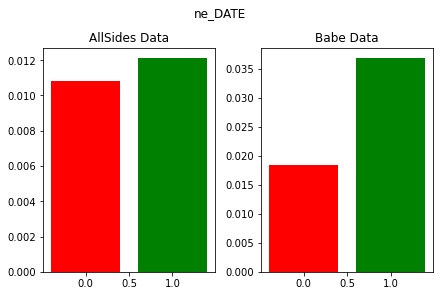

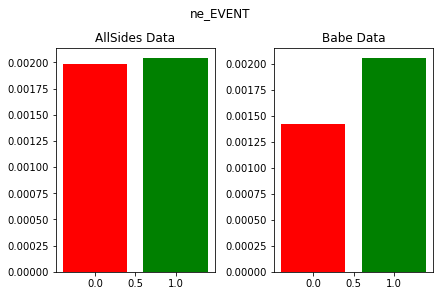

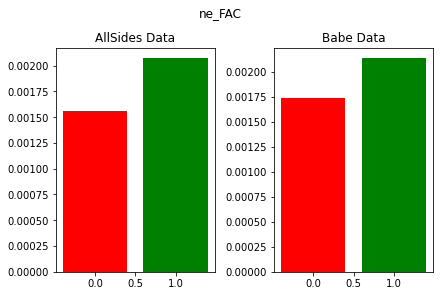

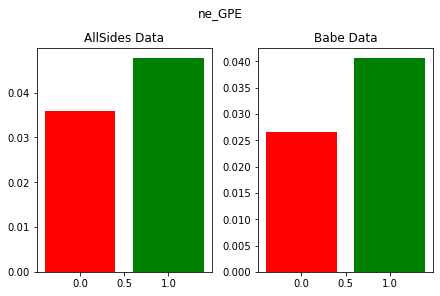

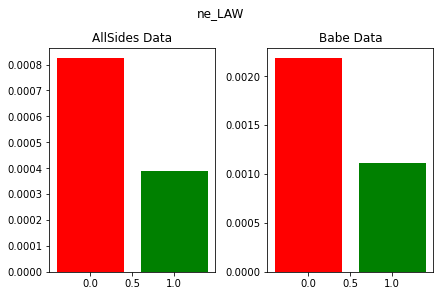

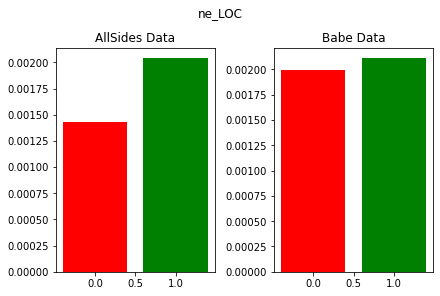

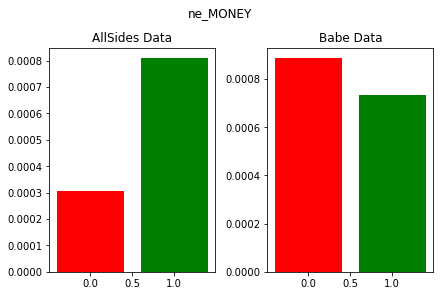

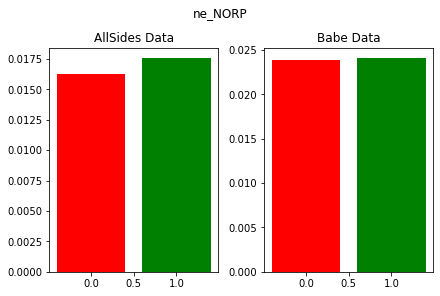

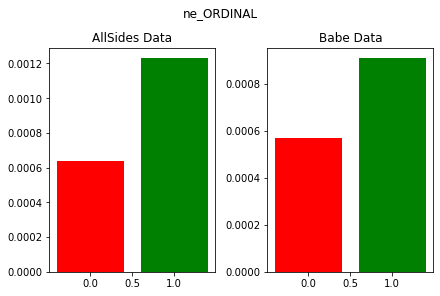

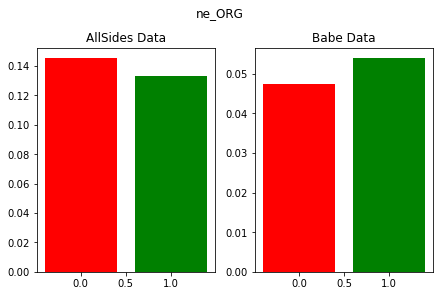

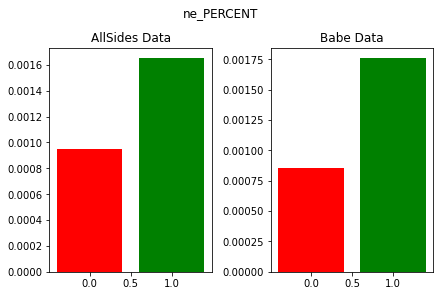

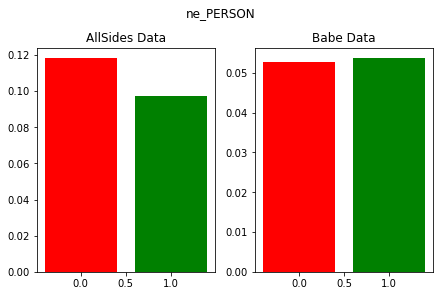

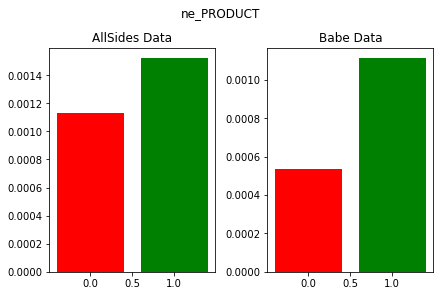

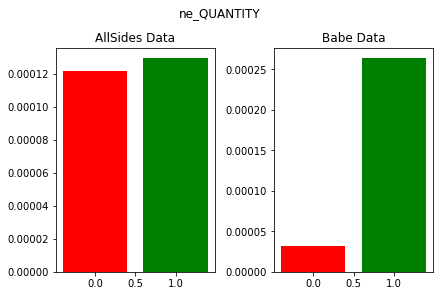

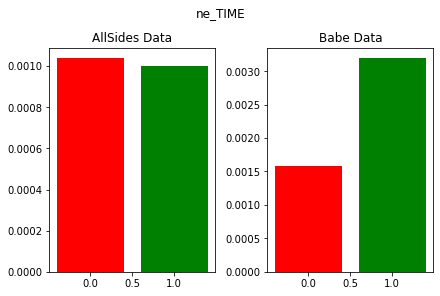

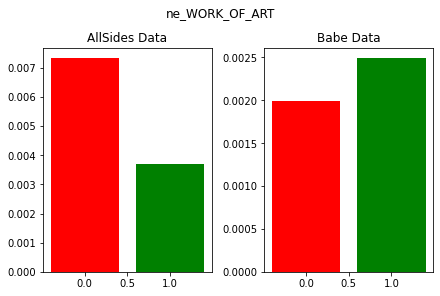

In [154]:
for i in binary_feats:
    
    figs, axs = plt.subplots(1,2, constrained_layout = True)
    
    temp_lis = [feats_avg_b[i + '_b'], feats_avg_n[i + '_n']]
    
    axs[0].bar(range(0,2), temp_lis, align='center', color=['red', 'green'])
    str_lis = [i + '_b', i + '_n']
    axs[0].set_title('AllSides Data')
    
    temp_lis = [feats_avg_bb[i + '_bb'], feats_avg_bn[i + '_bn']]
    axs[1].bar(range(0,2), temp_lis, align='center', color=['red', 'green'])
    str_lis = [i + '_bb', i + '_bn']
    axs[1].set_title('Babe Data')
    
    figs.suptitle(i)

    plt.show()

In [120]:
df[df["Bias"] == 'AllSides Media Bias Rating: Center'].count()

index            4131
Source           4130
Headline         4131
Text             4131
Bias             4131
Subject_Tag      4091
Date             4131
Label            4131
spacy_lg         4131
spacy_lg_dict    4131
dtype: int64

In [104]:
feats_avg_b = [a + b for a, b in zip(binary_feats, len(binary_feats)*['_b'])]
feats_avg_n = [a + b for a, b in zip(binary_feats, len(binary_feats)*['_n'])]

In [105]:
feats_avg_b = {i : 0.0 for i in feats_avg_l}
feats_avg_n = {i : 0.0 for i in feats_avg_r}

In [106]:
for i in binary_feats:
    feats_avg_b[i + '_b'] = babe_wide[i][babe_wide["Bias"] == 'AllSides Media Bias Rating: Left'].mean()
    feats_avg_n[i + '_n'] = babe_wide[i][babe_wide["Bias"] == 'AllSides Media Bias Rating: Right'].mean()

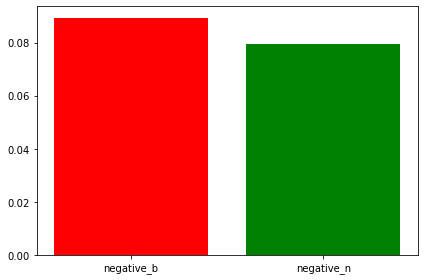

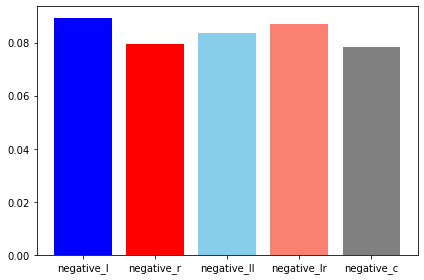

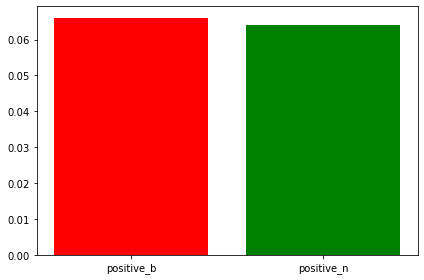

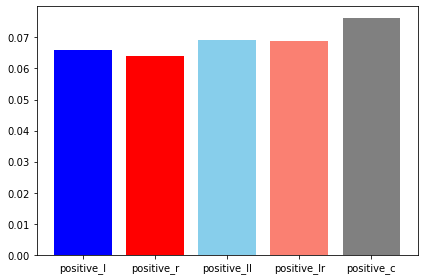

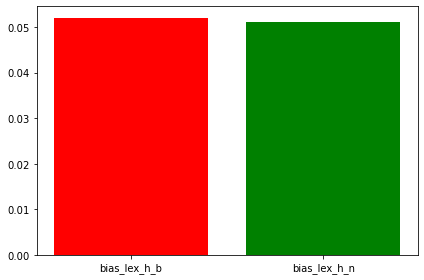

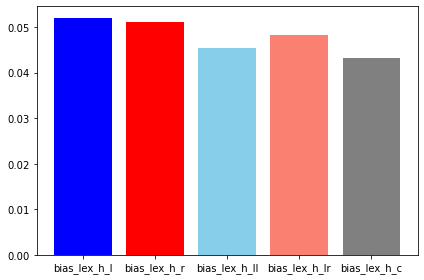

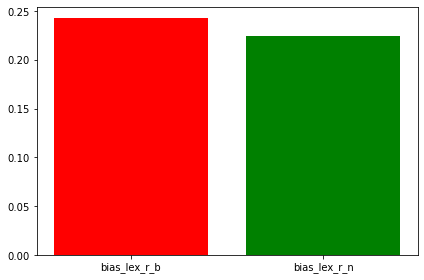

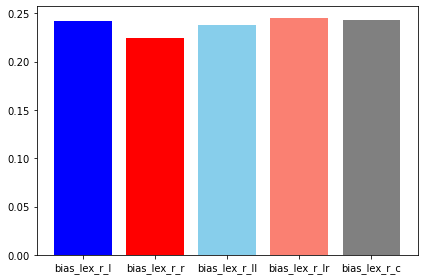

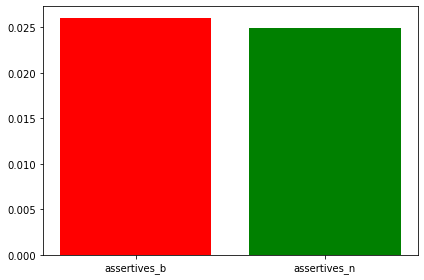

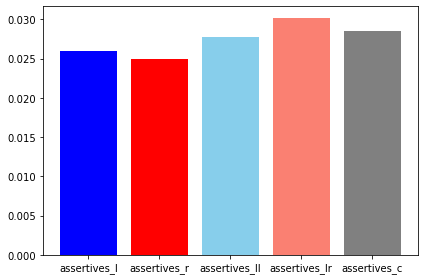

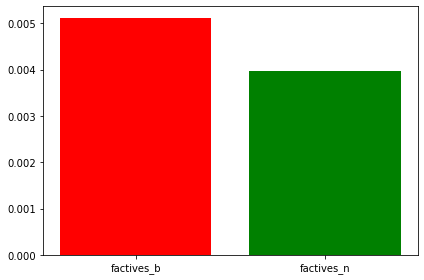

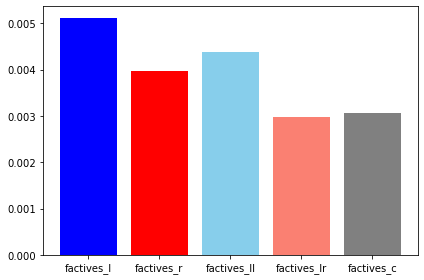

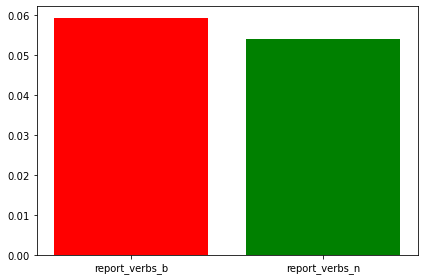

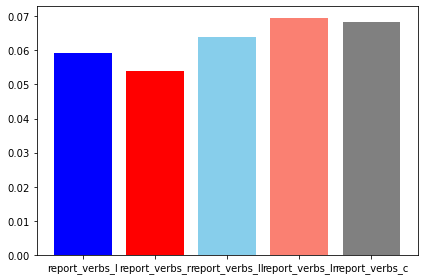

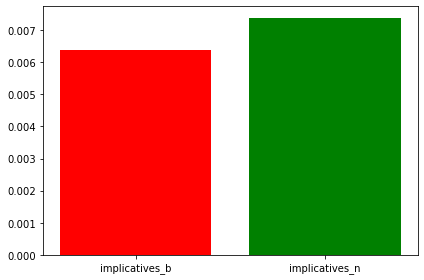

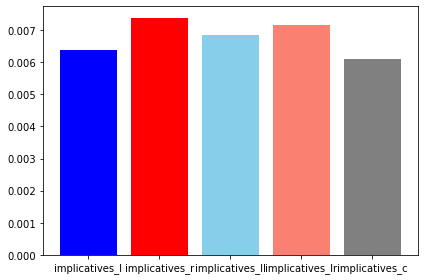

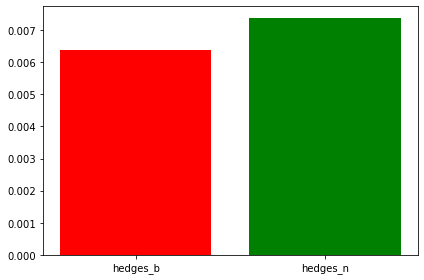

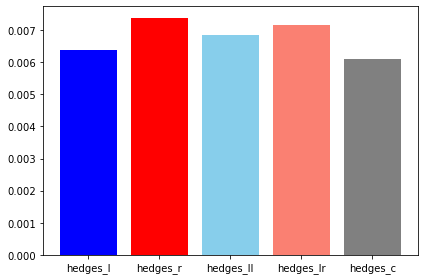

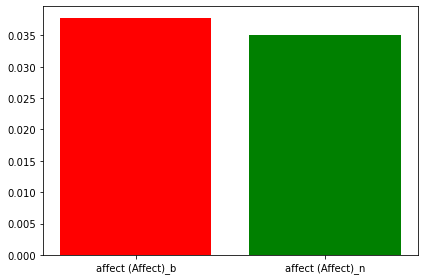

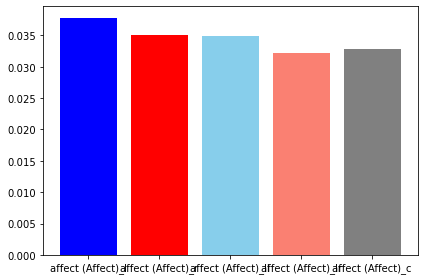

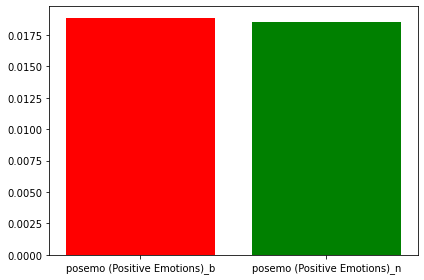

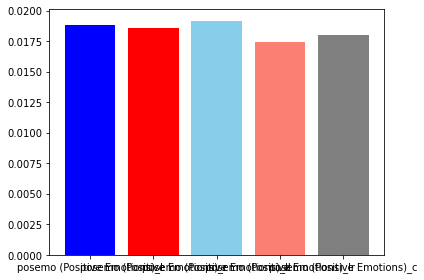

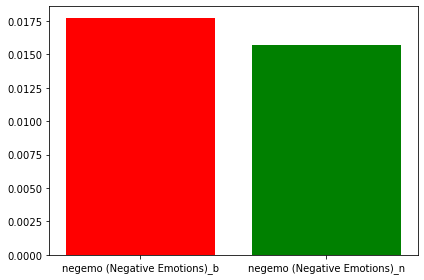

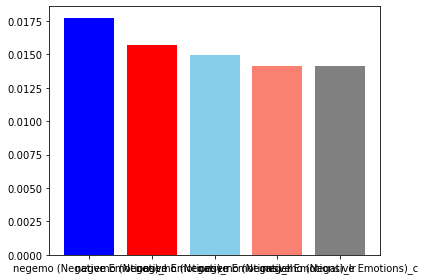

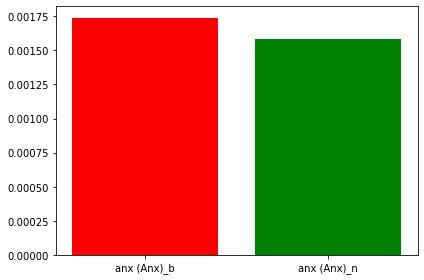

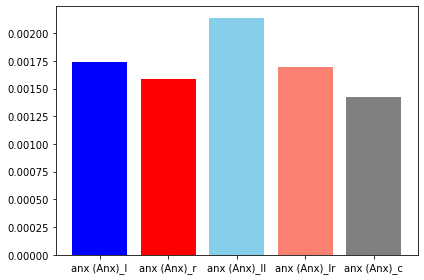

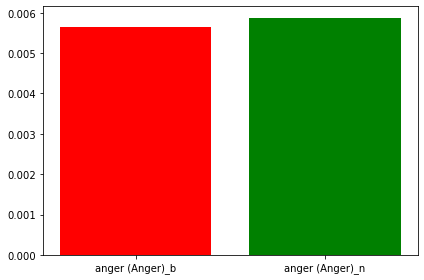

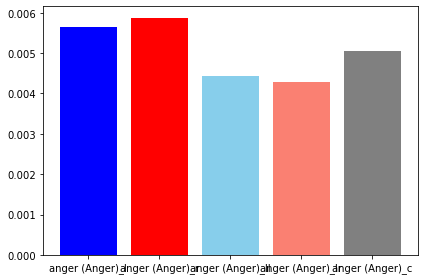

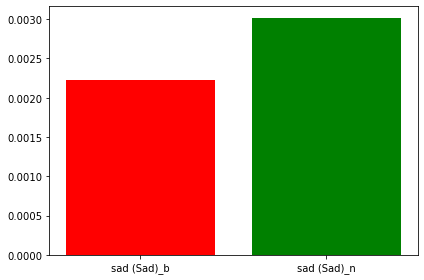

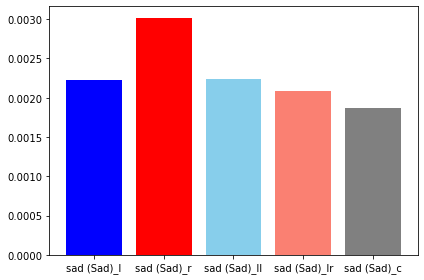

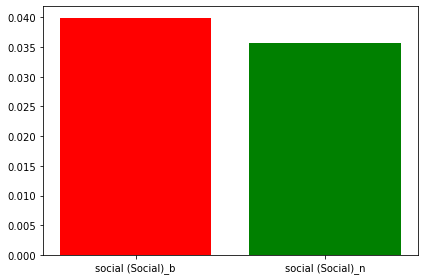

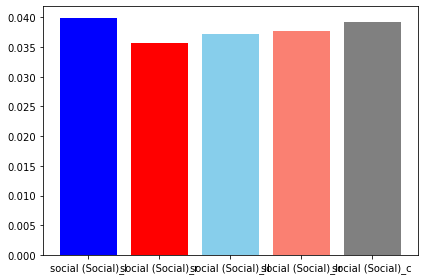

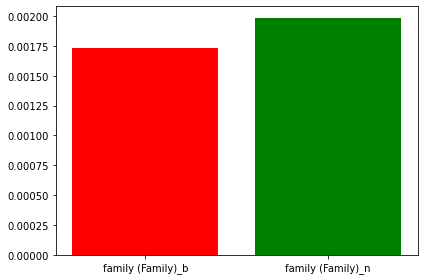

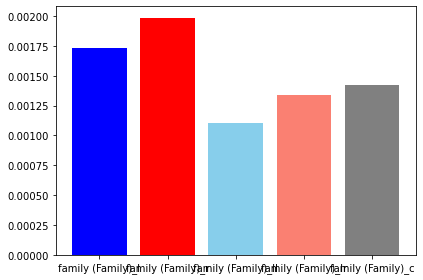

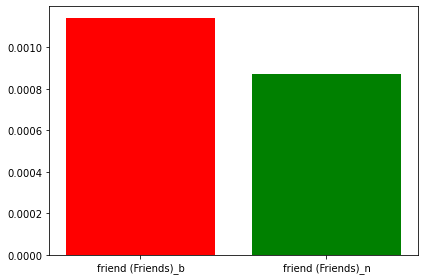

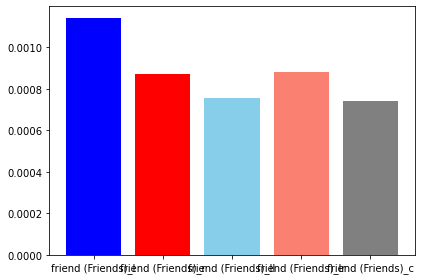

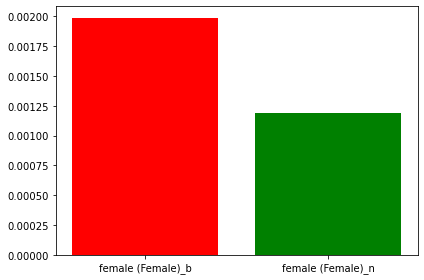

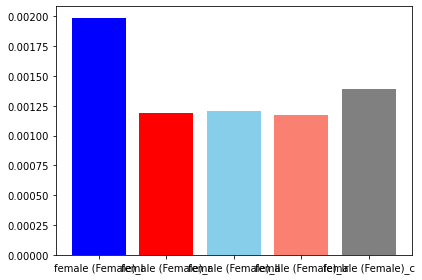

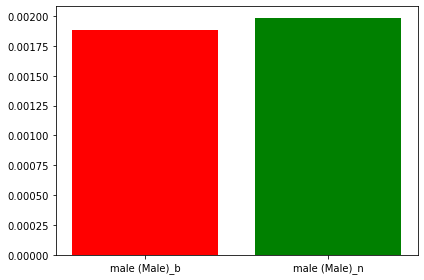

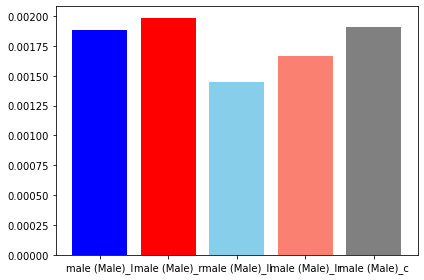

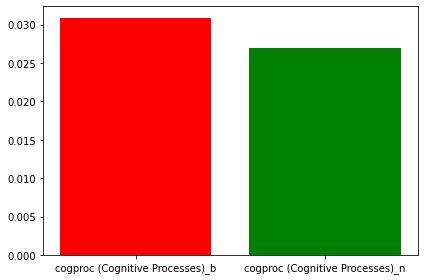

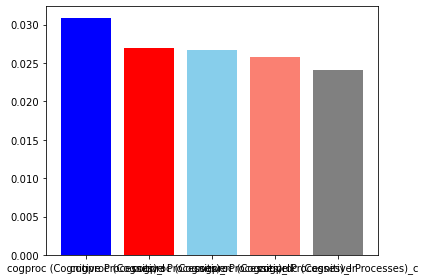

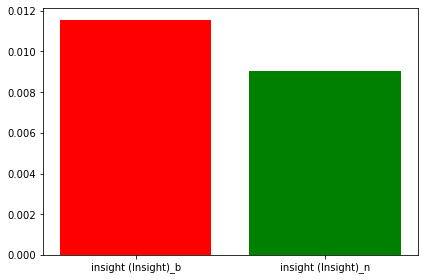

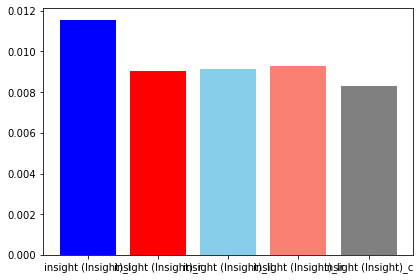

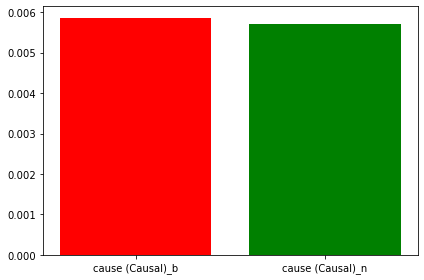

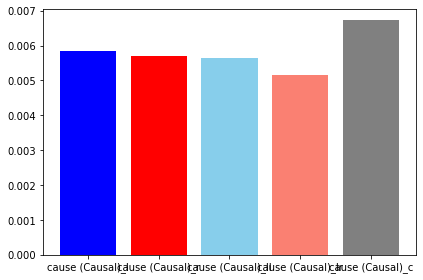

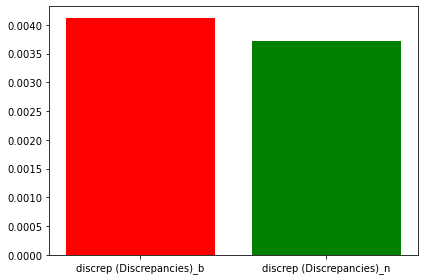

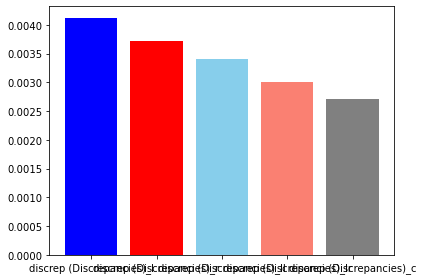

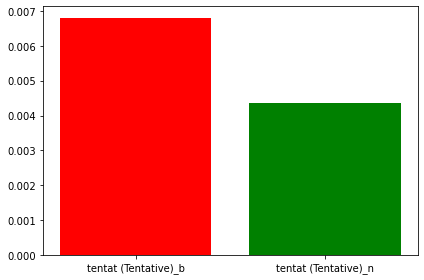

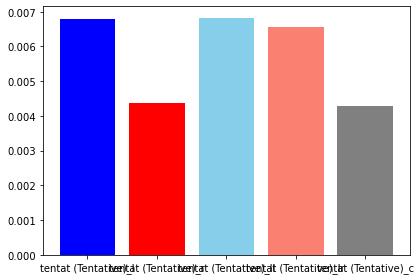

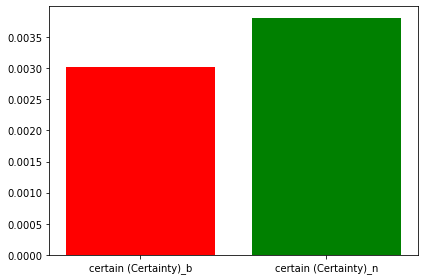

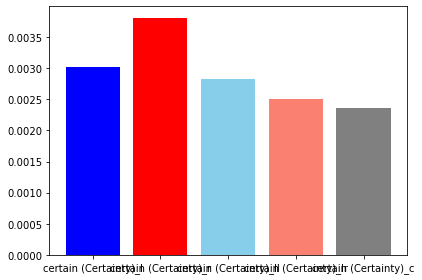

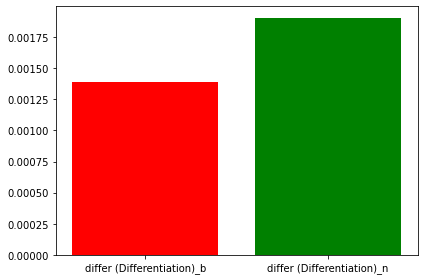

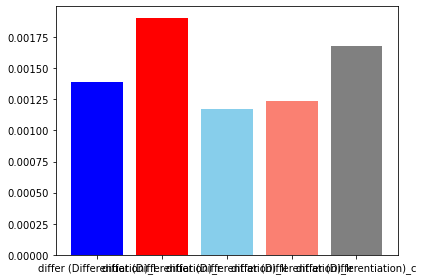

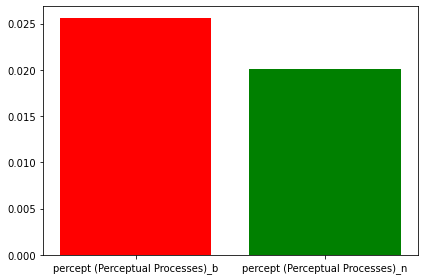

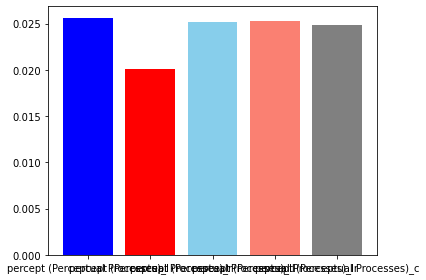

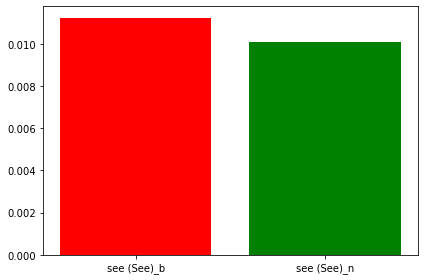

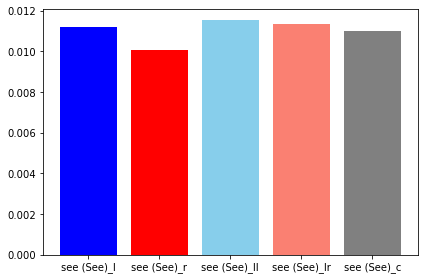

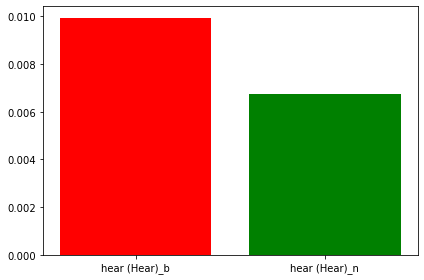

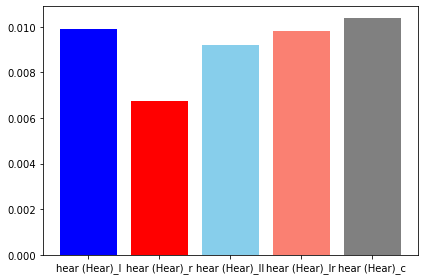

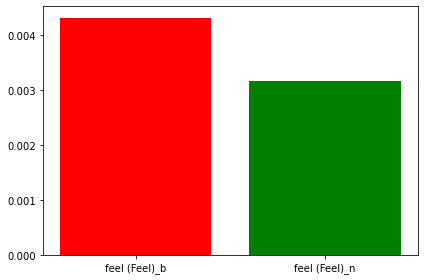

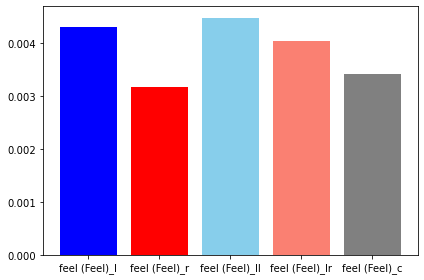

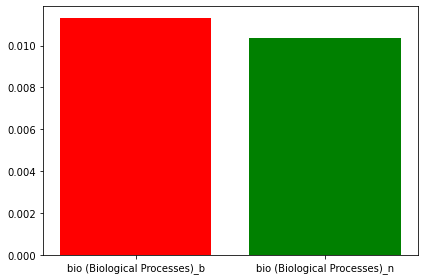

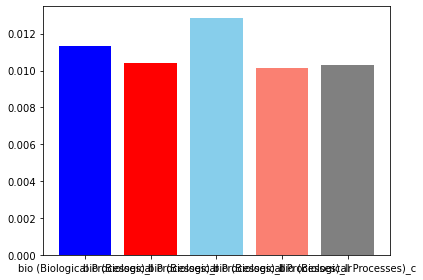

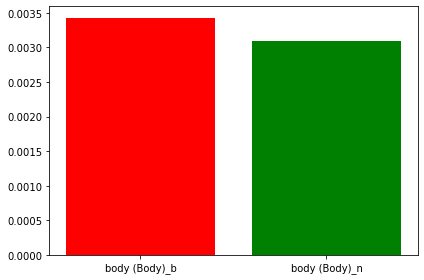

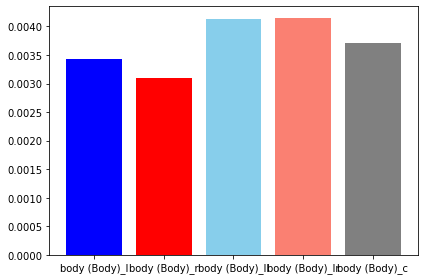

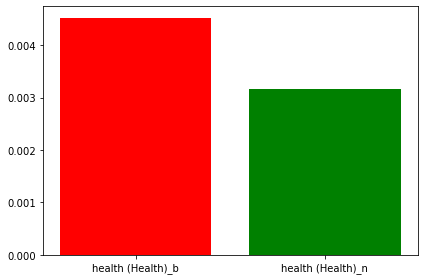

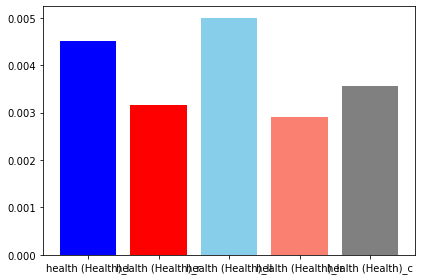

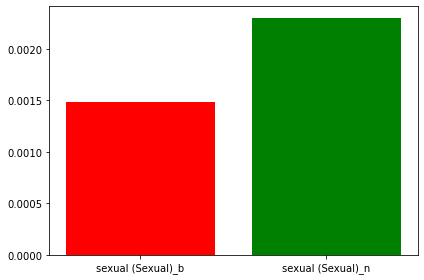

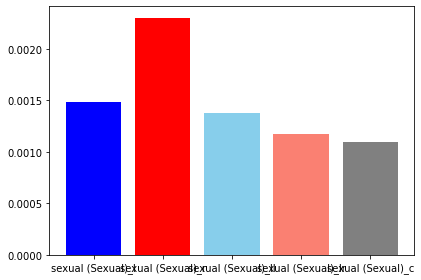

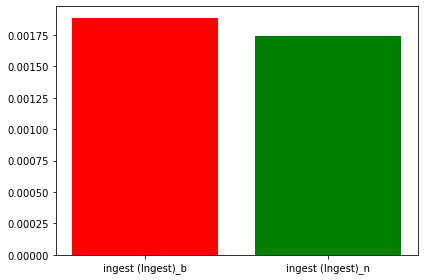

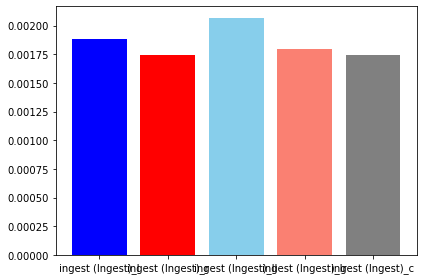

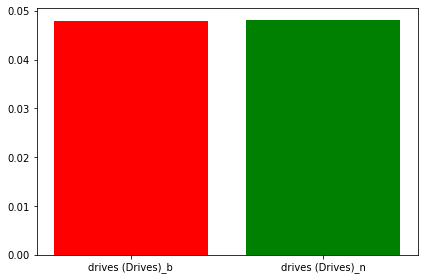

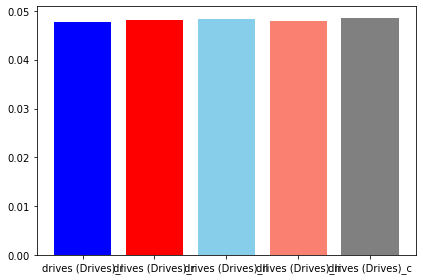

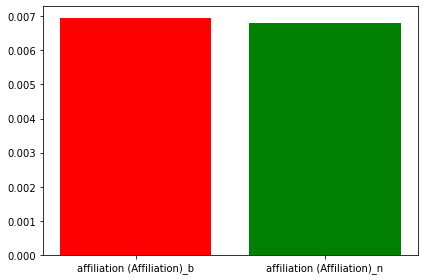

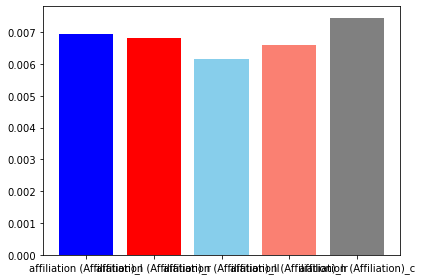

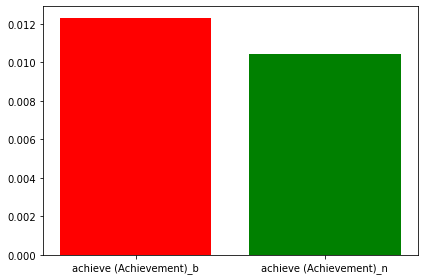

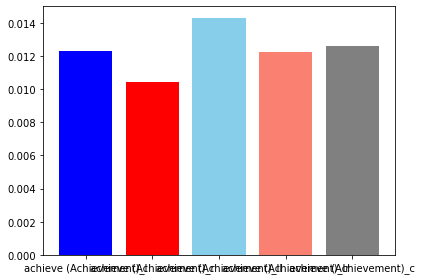

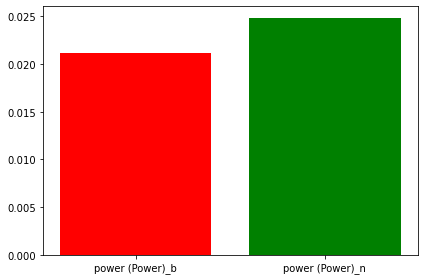

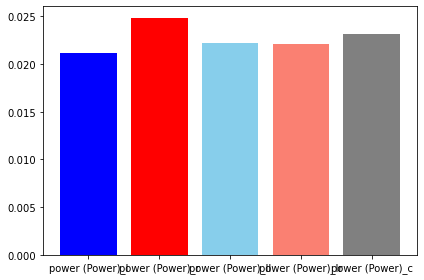

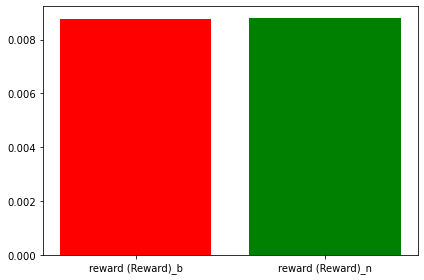

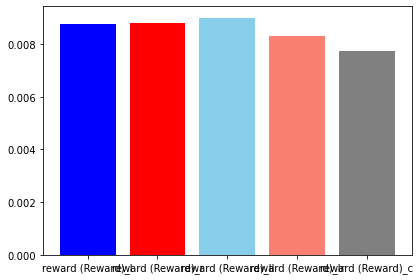

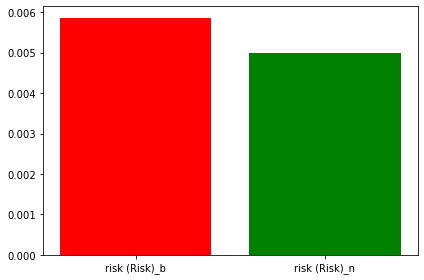

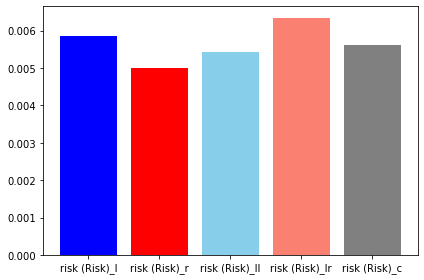

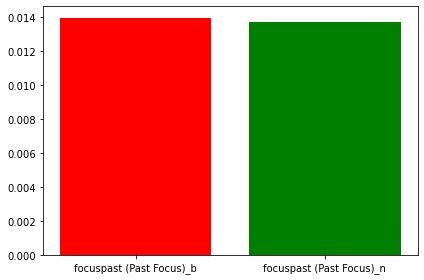

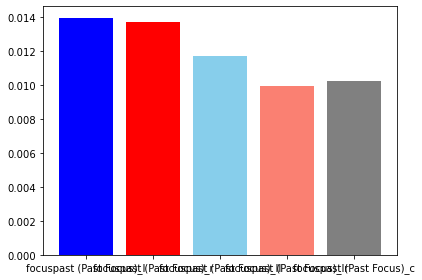

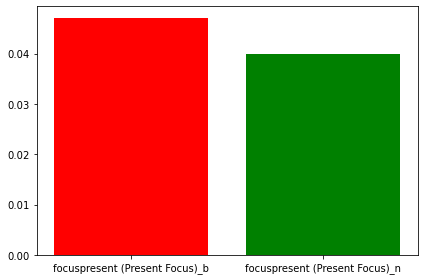

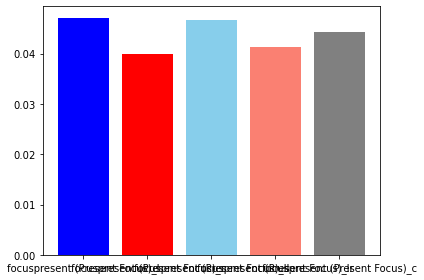

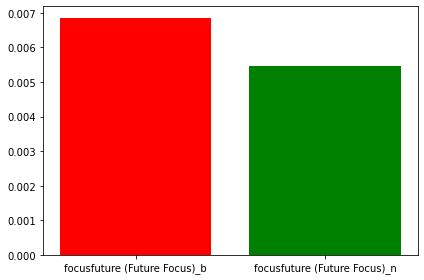

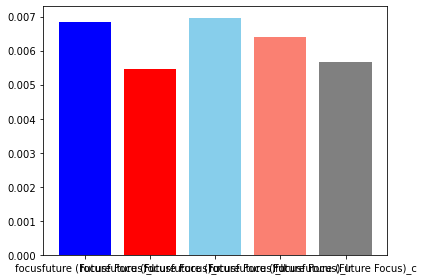

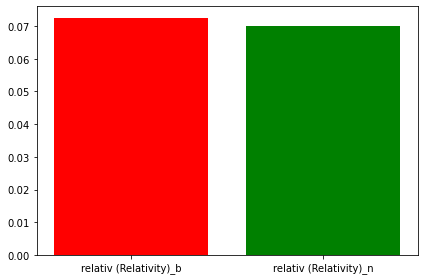

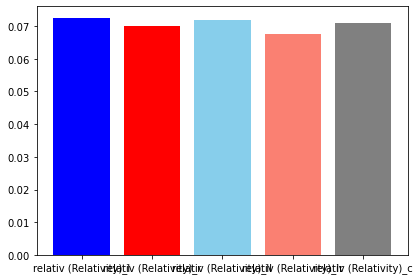

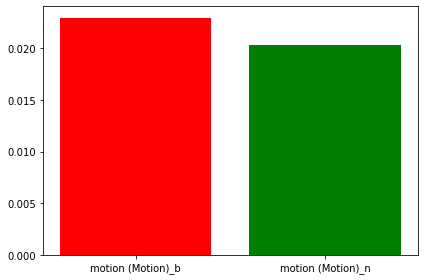

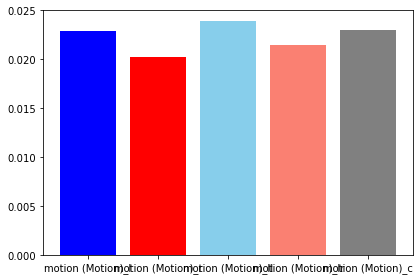

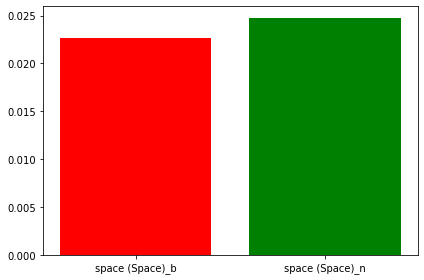

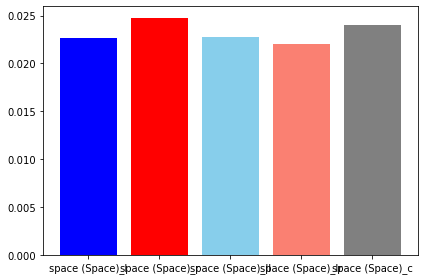

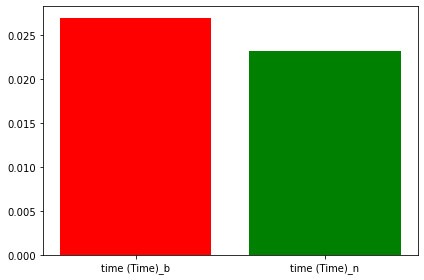

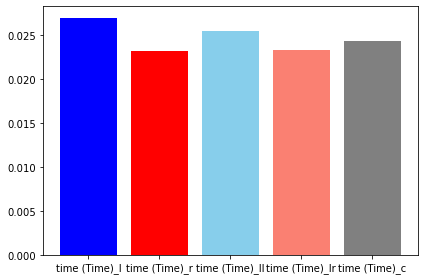

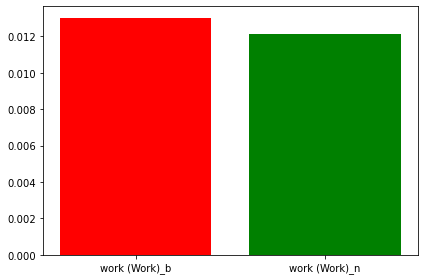

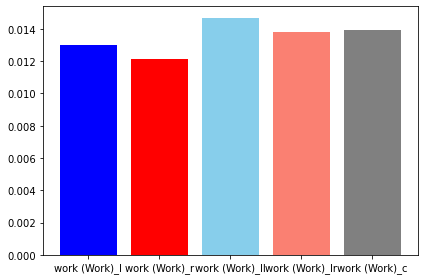

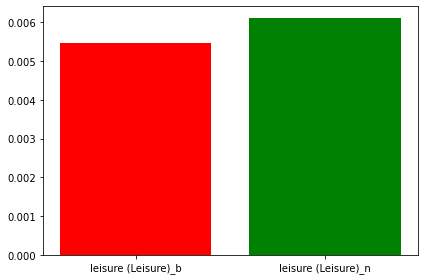

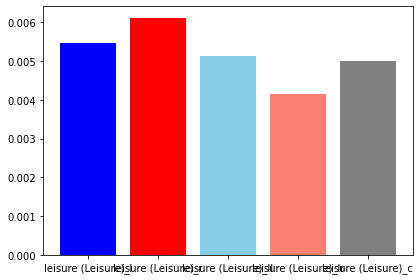

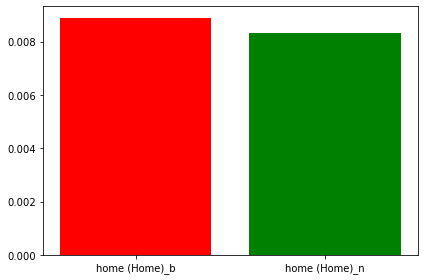

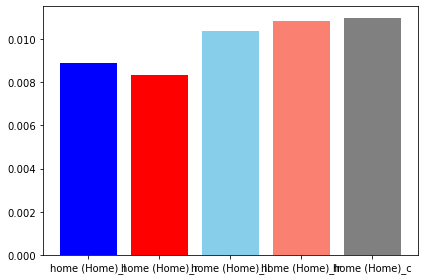

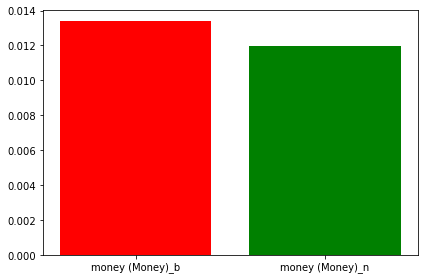

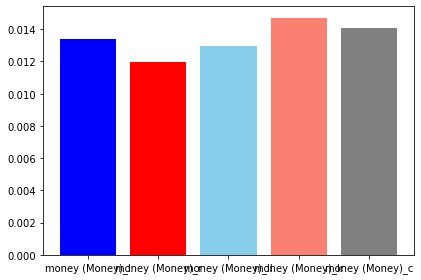

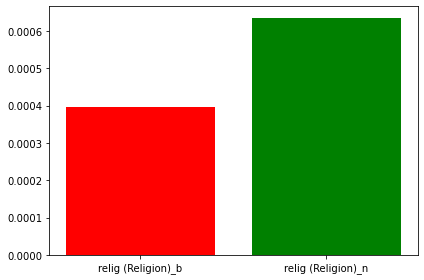

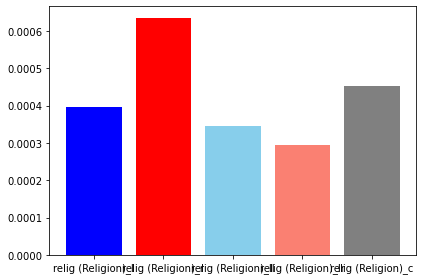

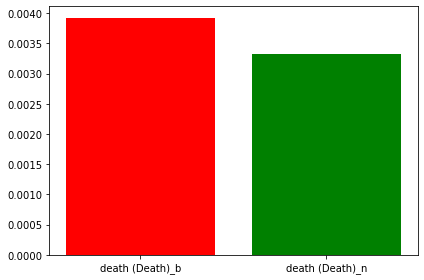

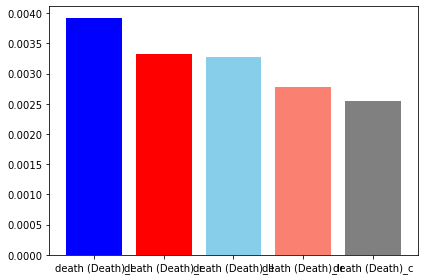

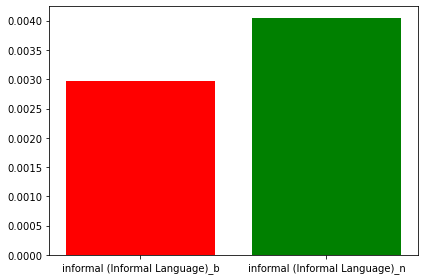

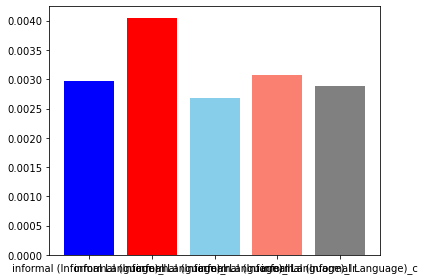

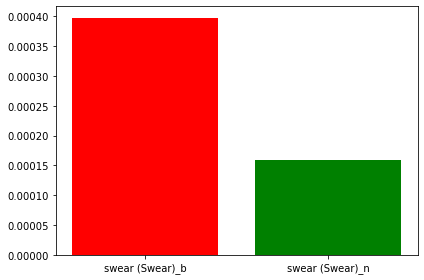

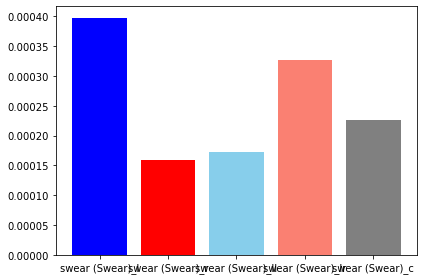

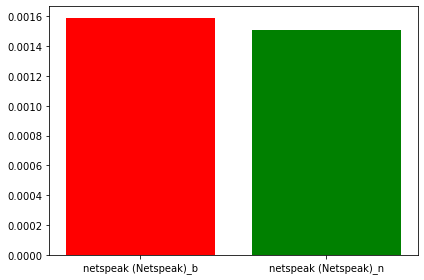

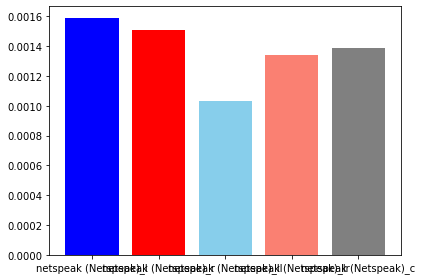

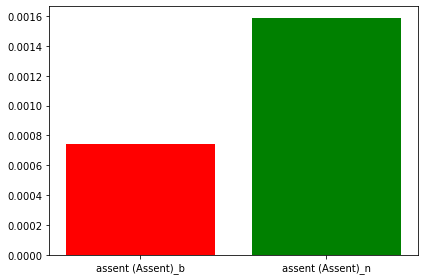

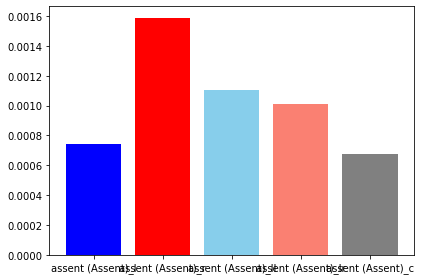

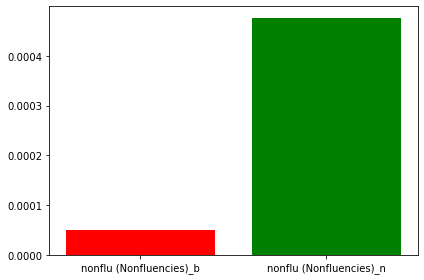

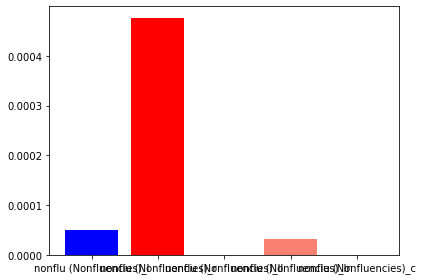

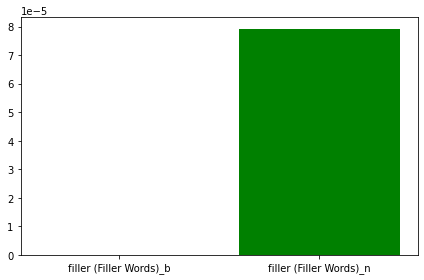

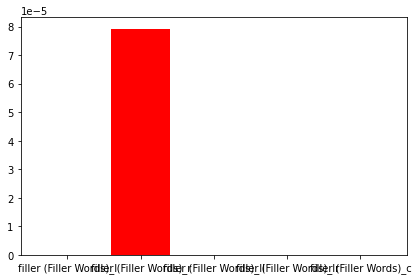

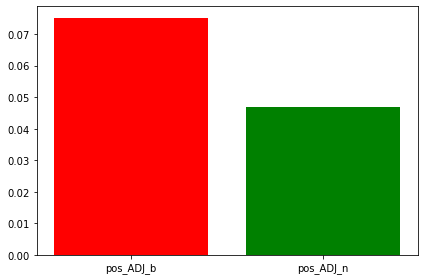

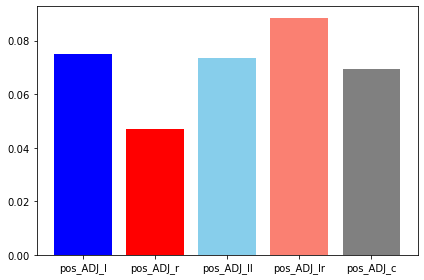

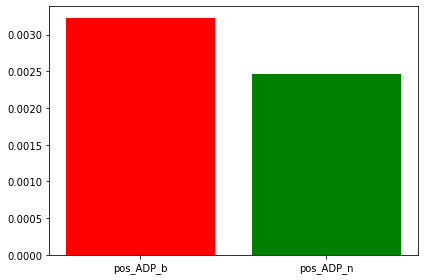

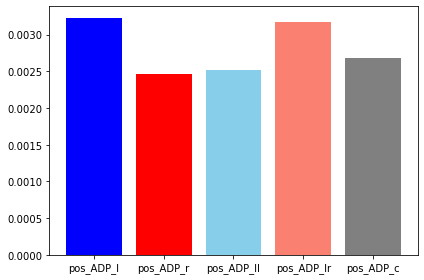

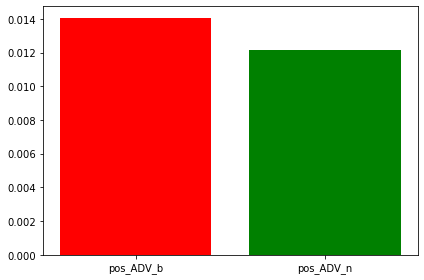

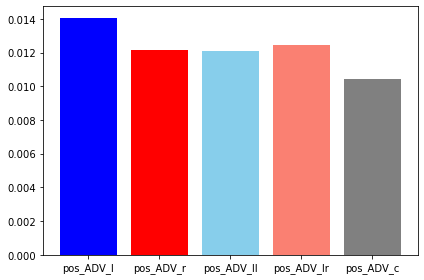

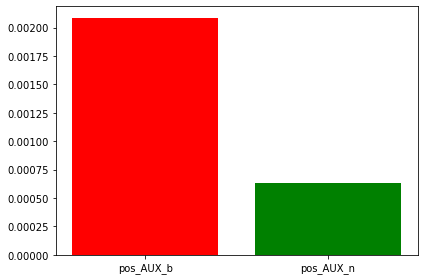

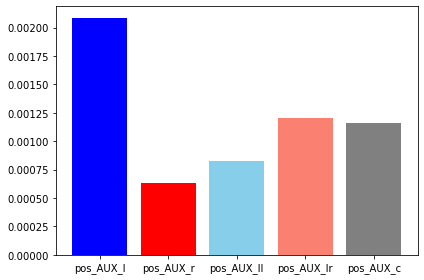

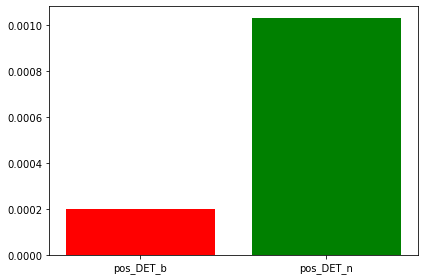

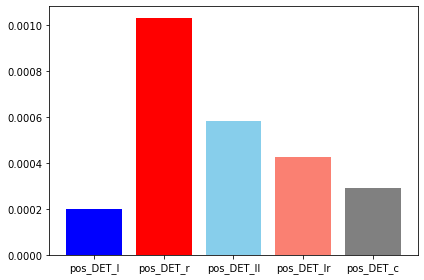

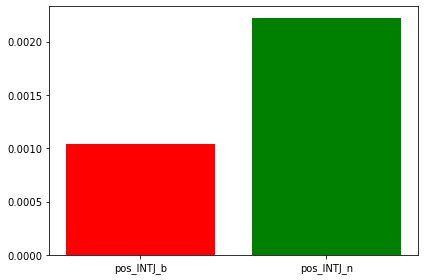

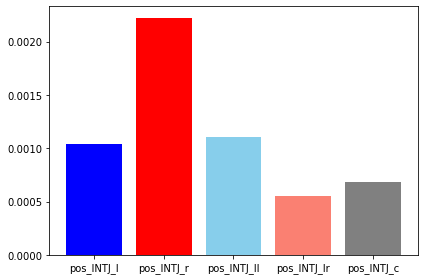

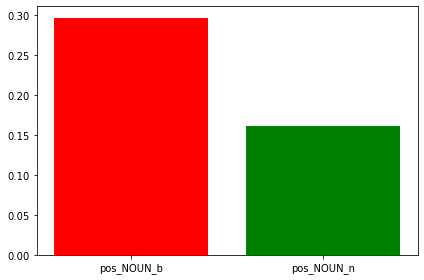

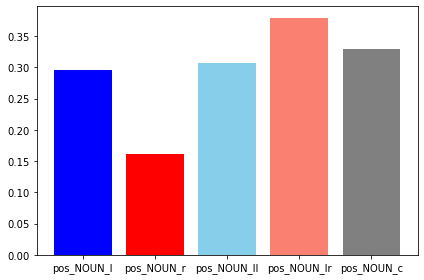

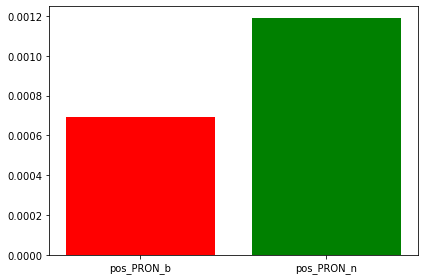

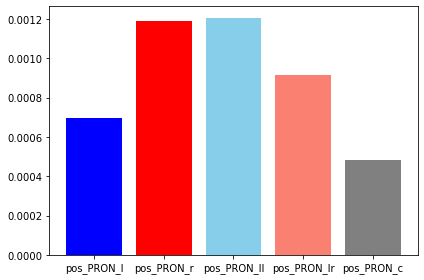

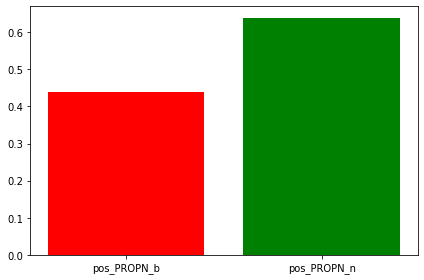

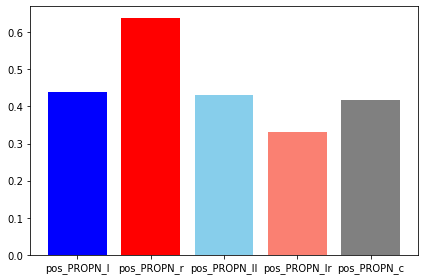

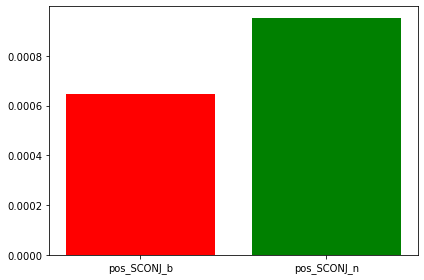

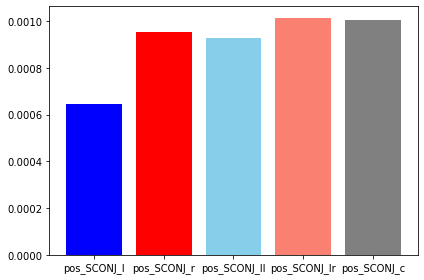

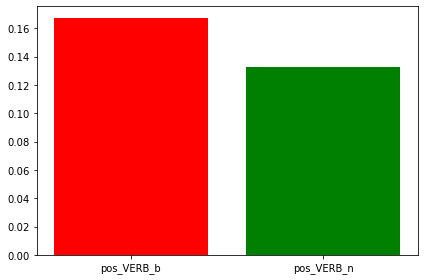

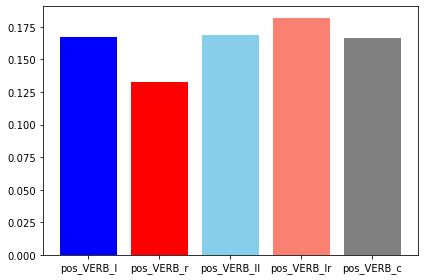

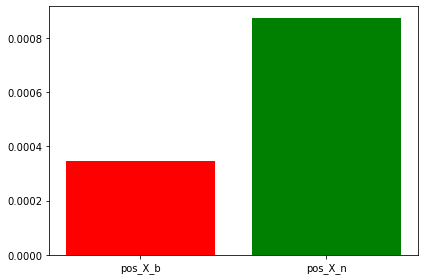

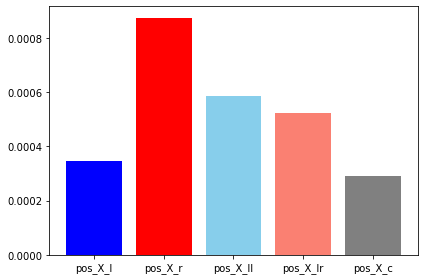

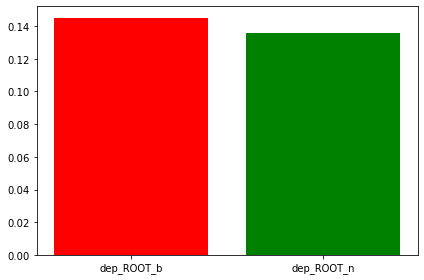

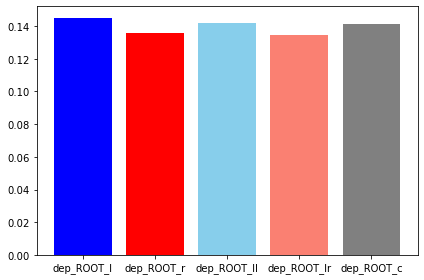

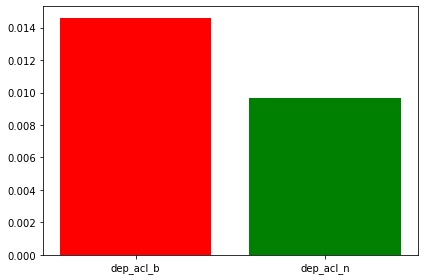

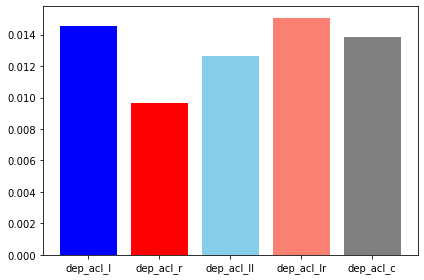

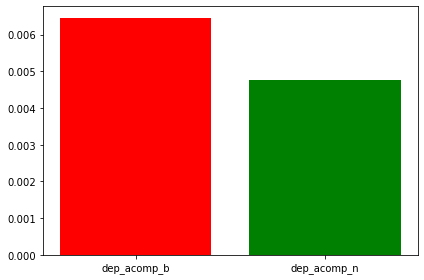

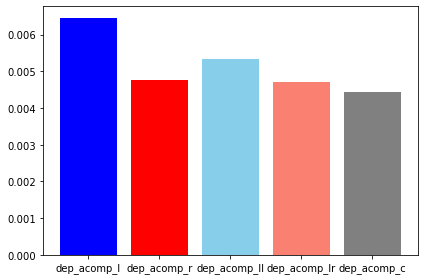

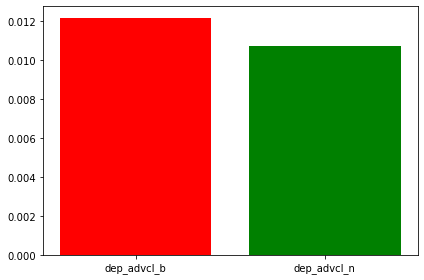

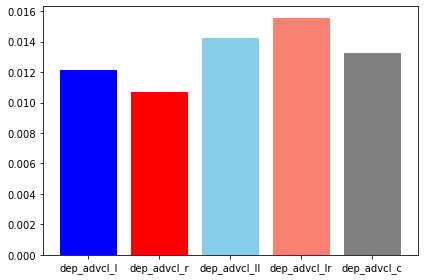

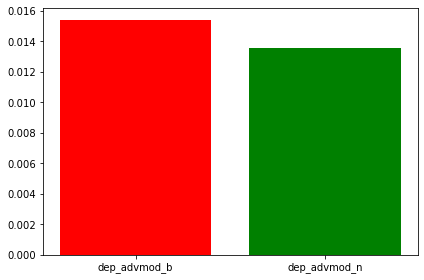

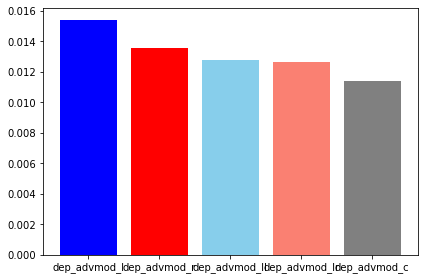

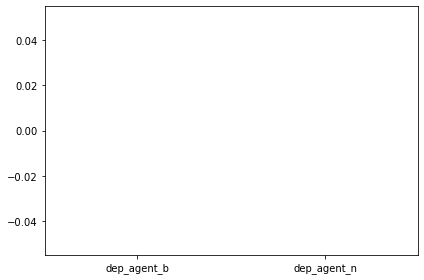

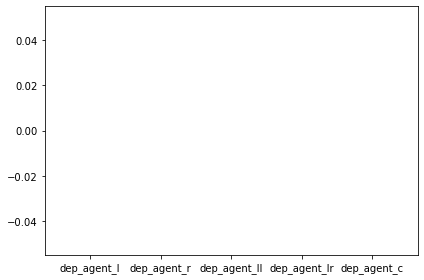

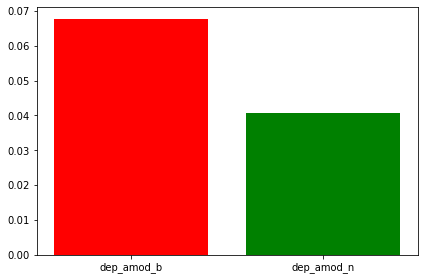

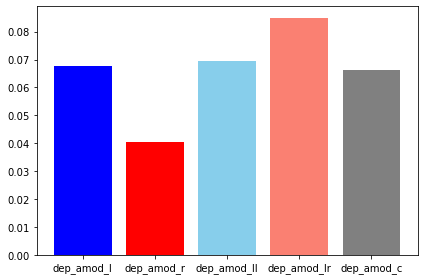

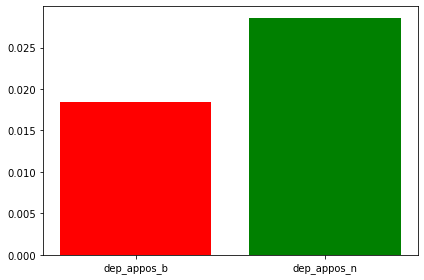

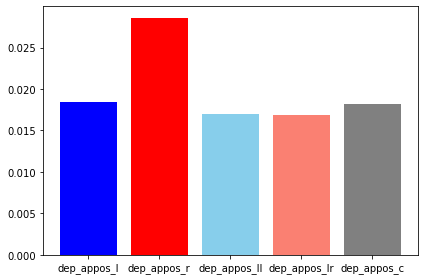

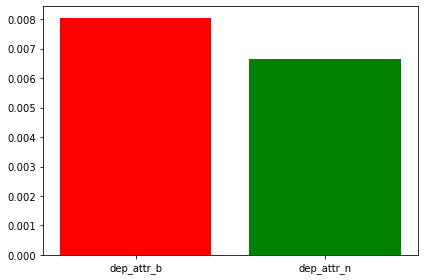

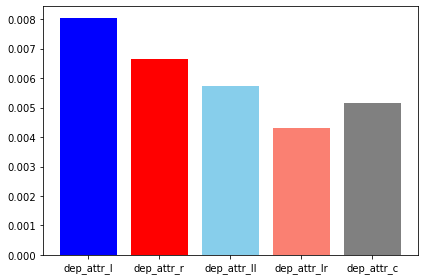

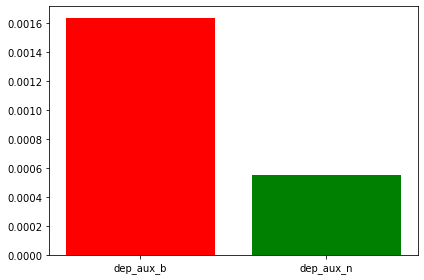

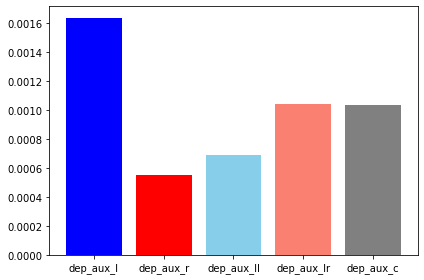

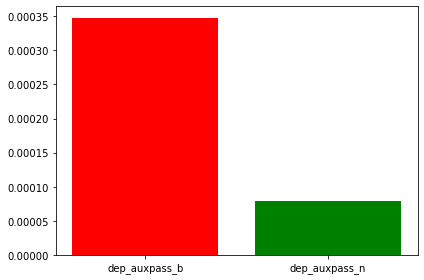

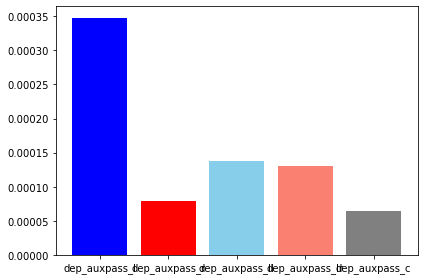

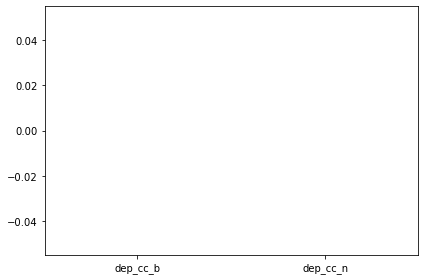

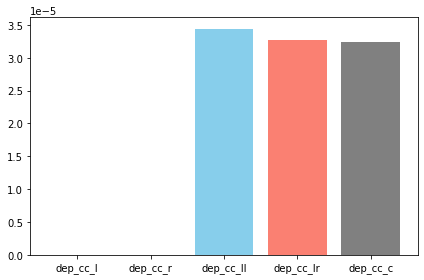

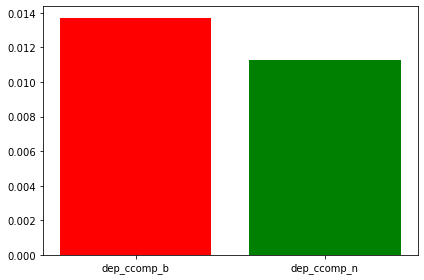

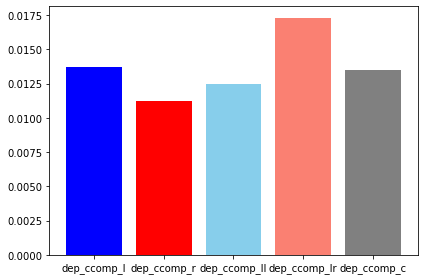

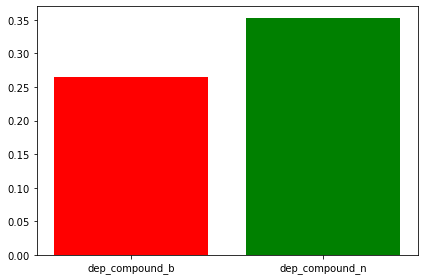

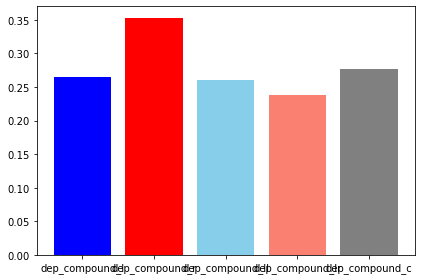

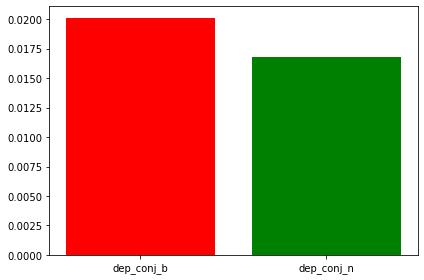

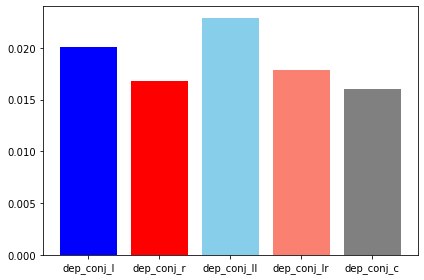

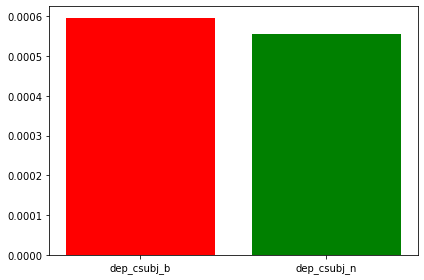

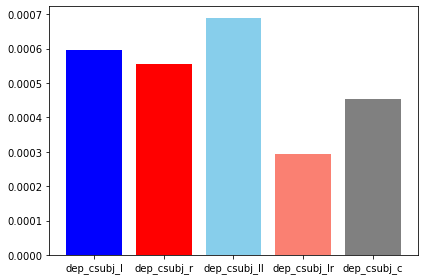

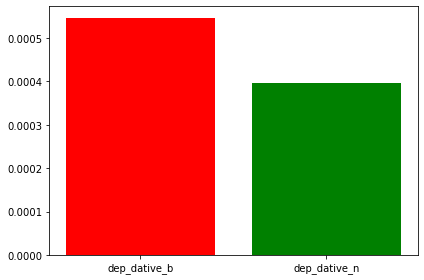

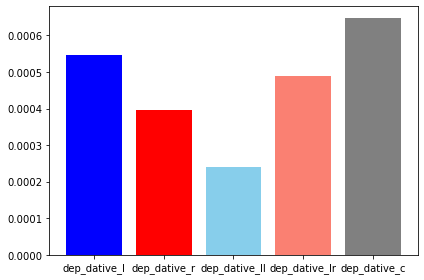

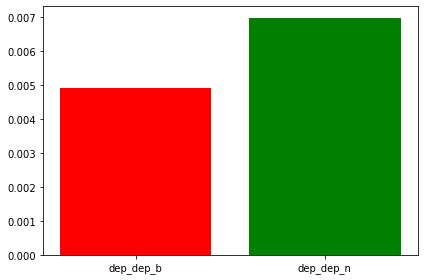

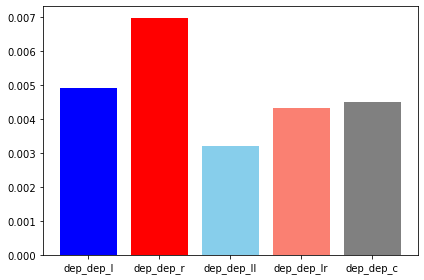

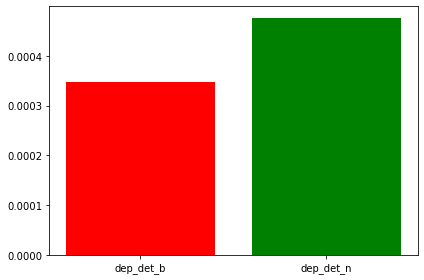

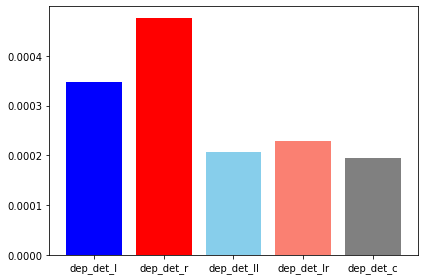

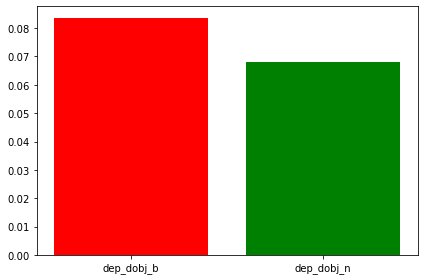

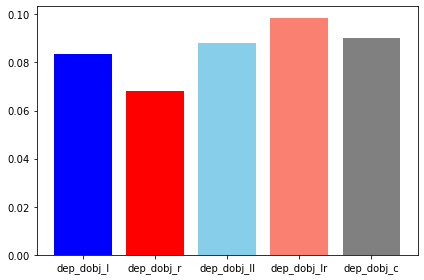

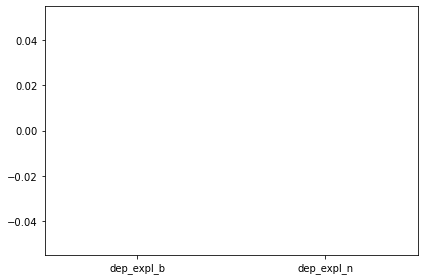

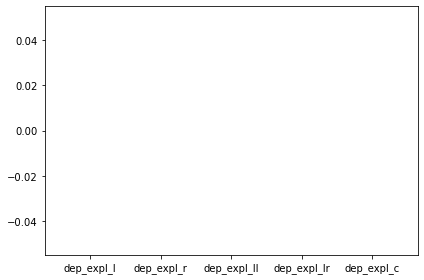

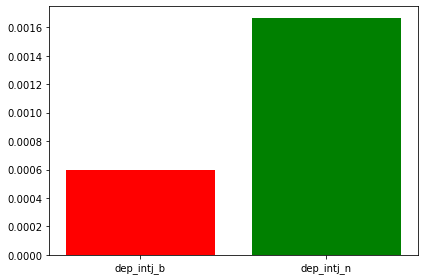

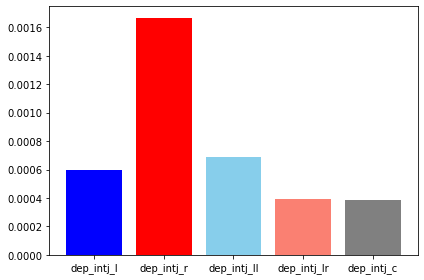

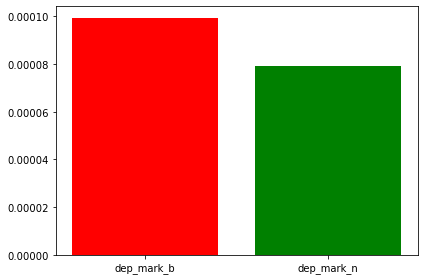

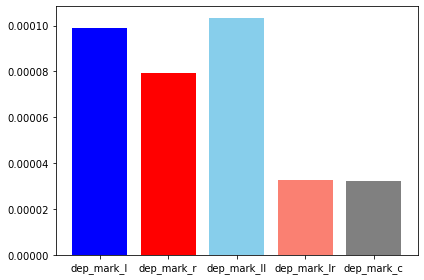

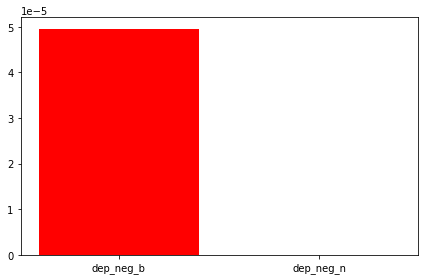

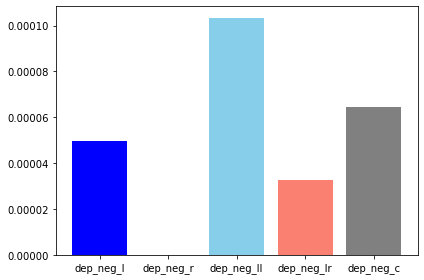

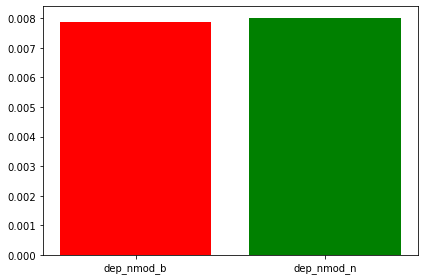

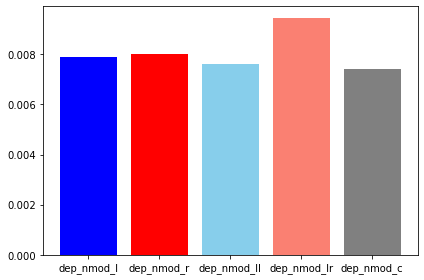

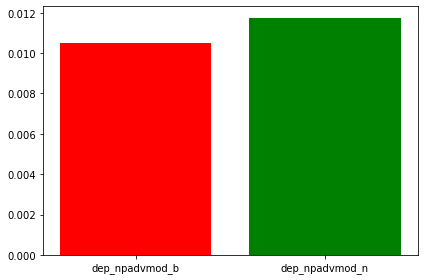

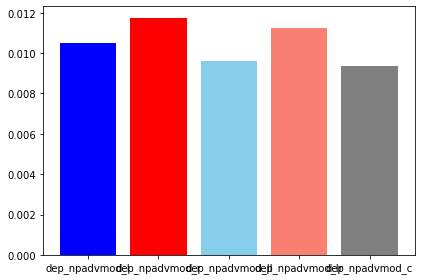

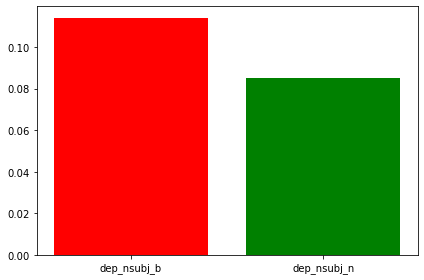

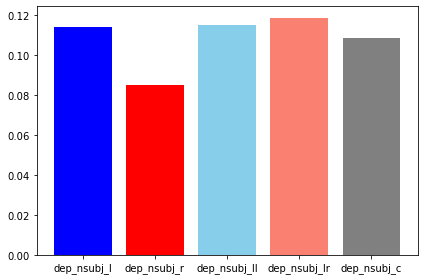

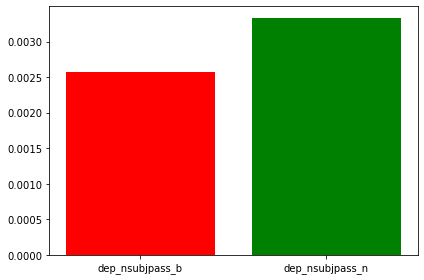

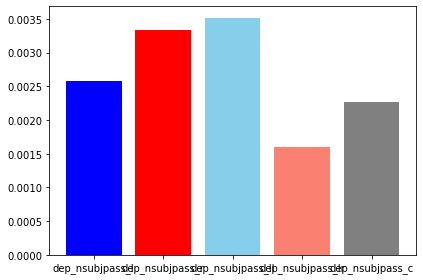

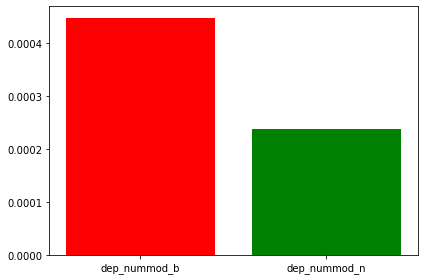

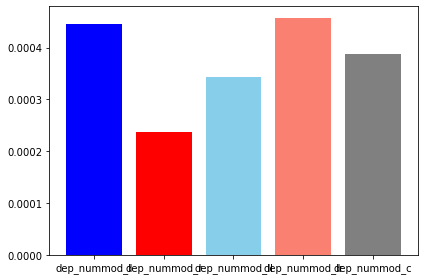

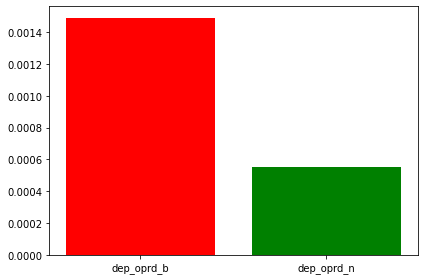

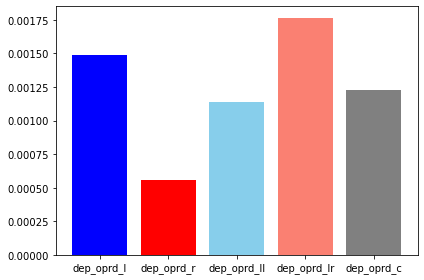

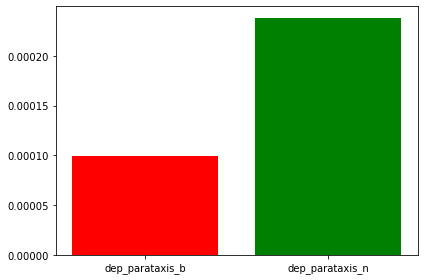

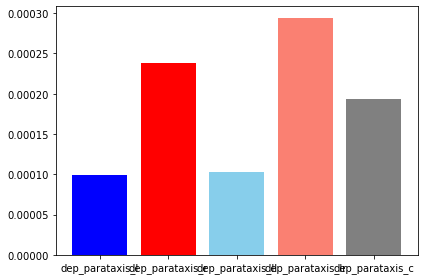

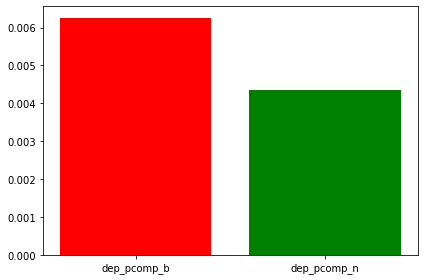

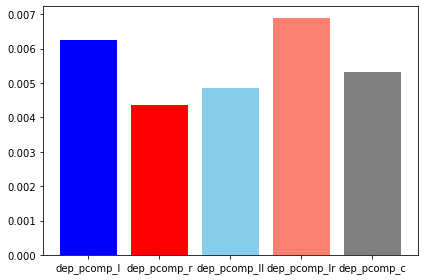

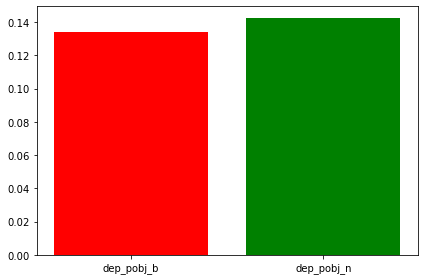

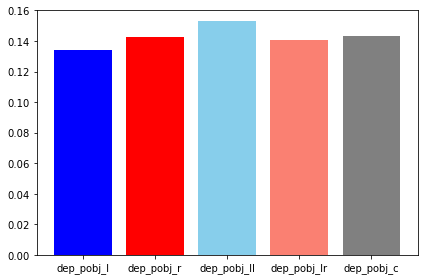

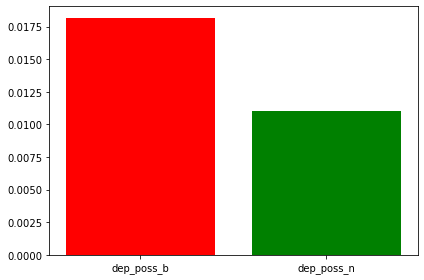

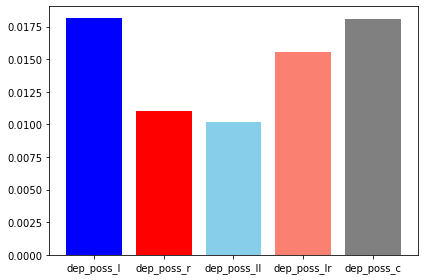

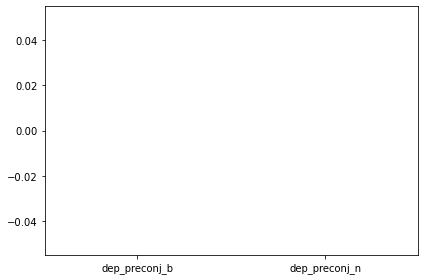

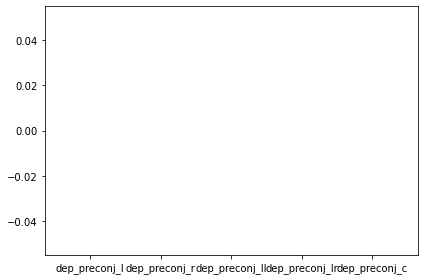

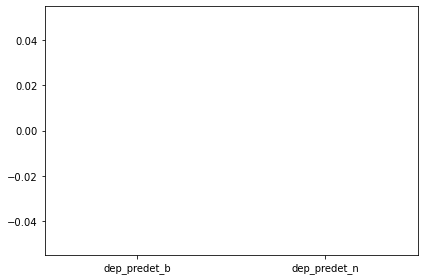

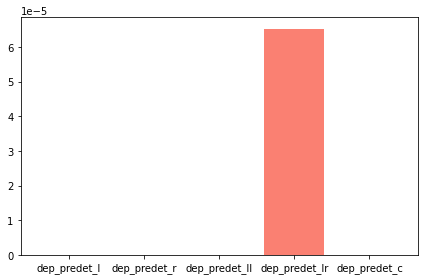

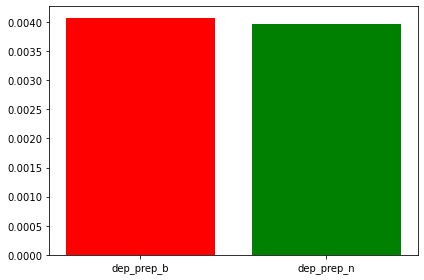

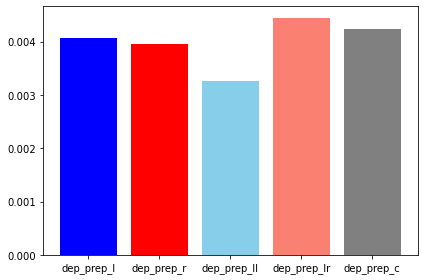

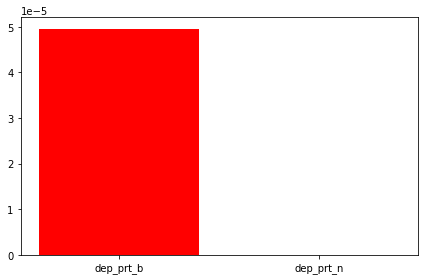

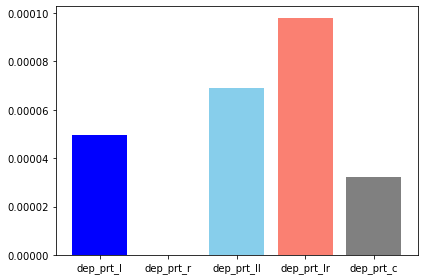

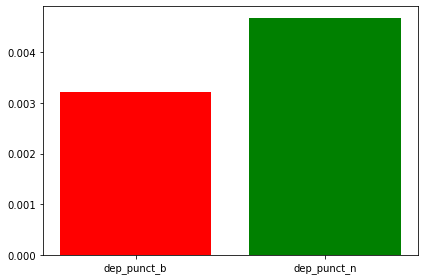

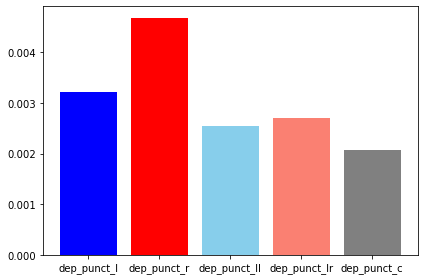

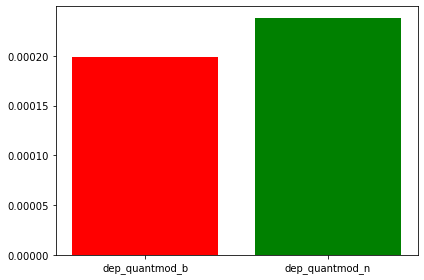

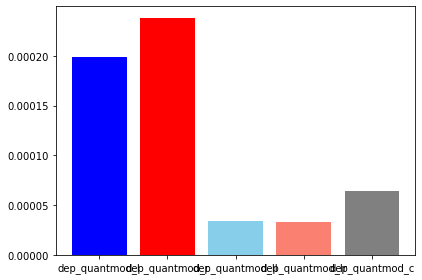

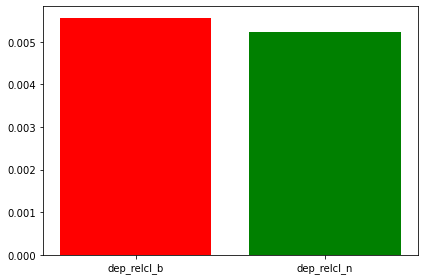

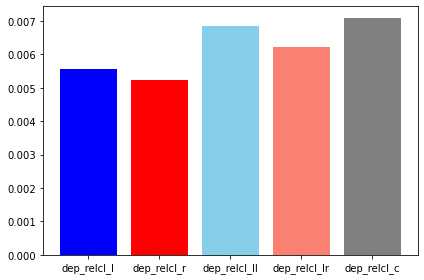

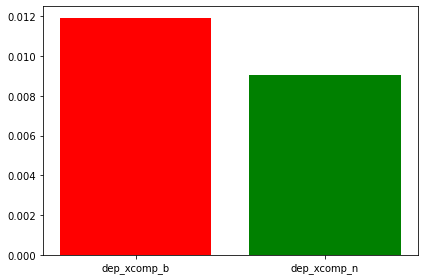

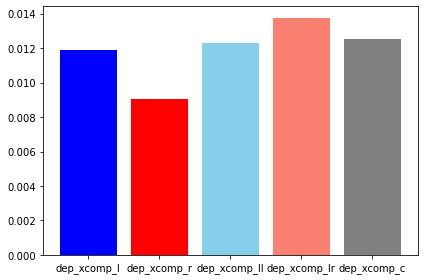

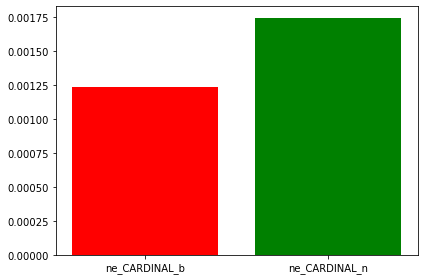

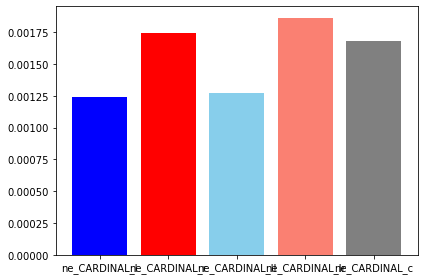

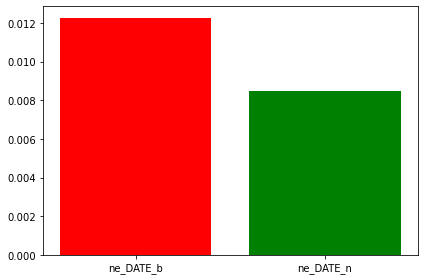

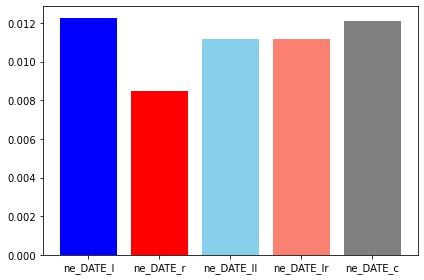

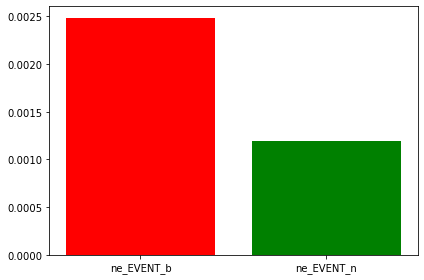

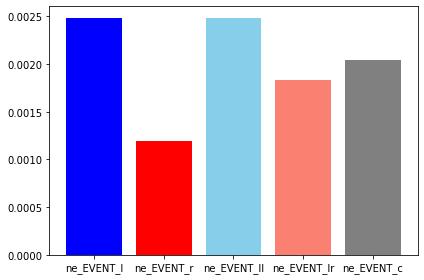

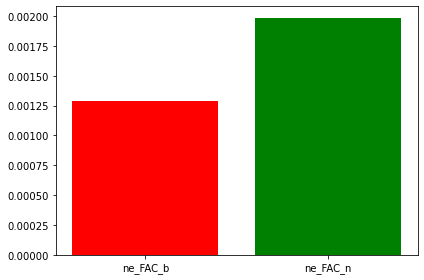

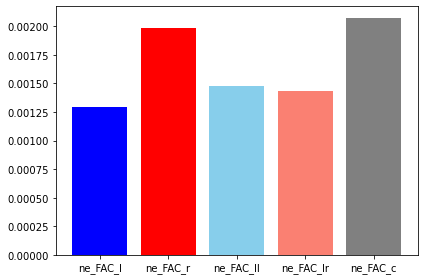

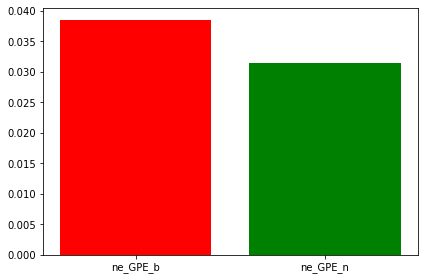

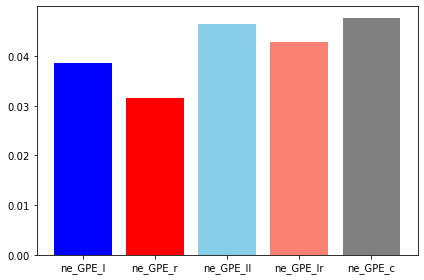

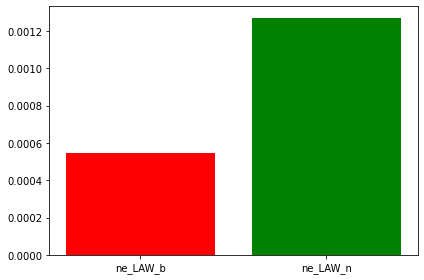

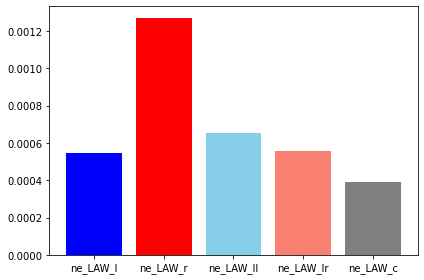

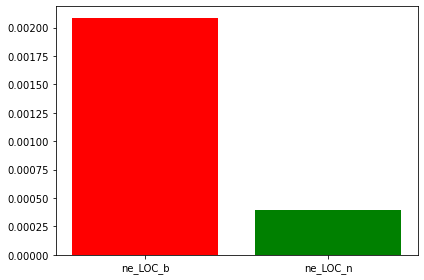

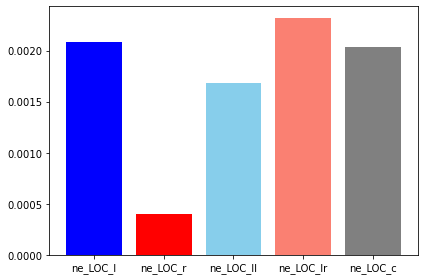

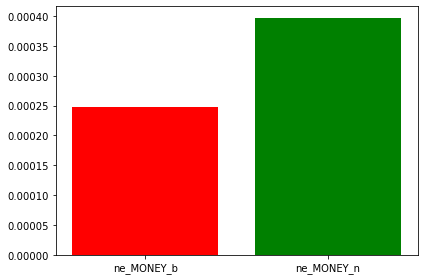

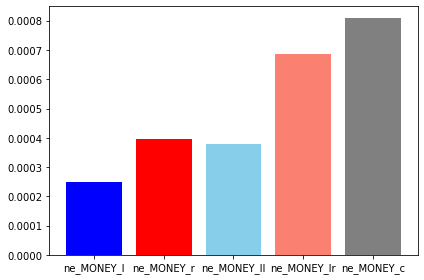

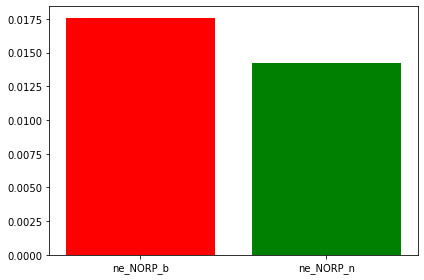

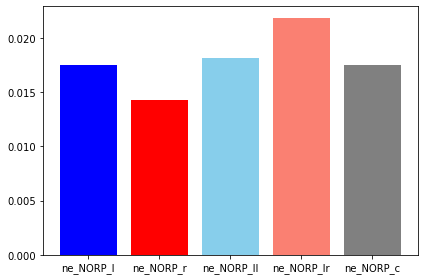

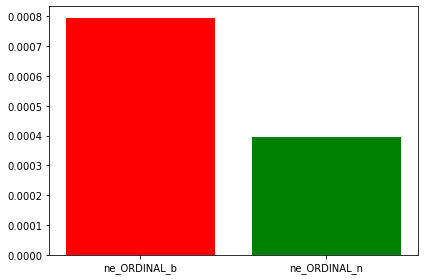

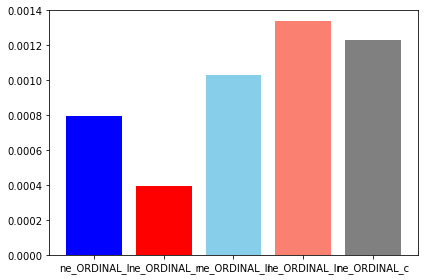

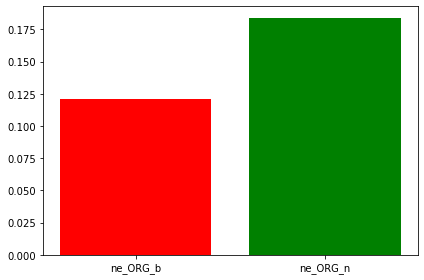

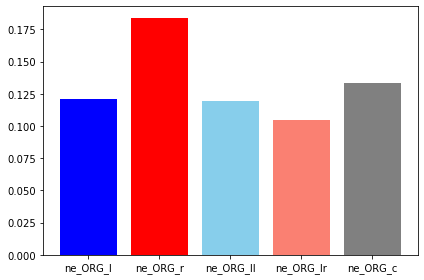

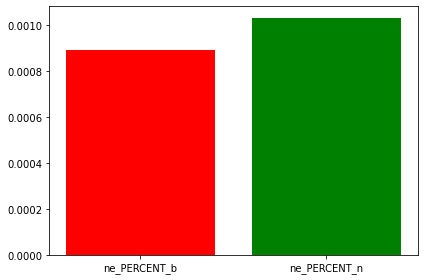

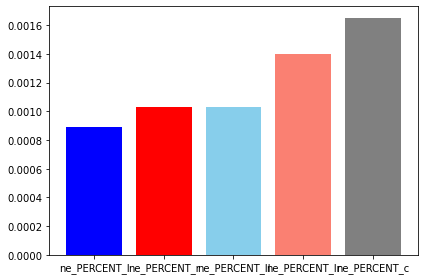

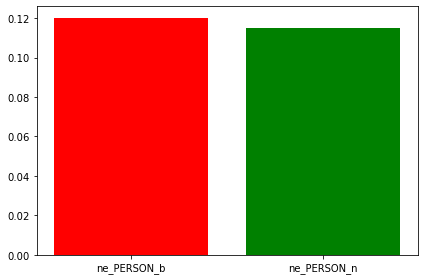

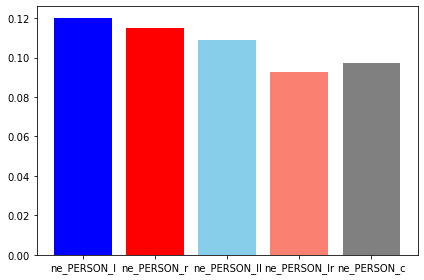

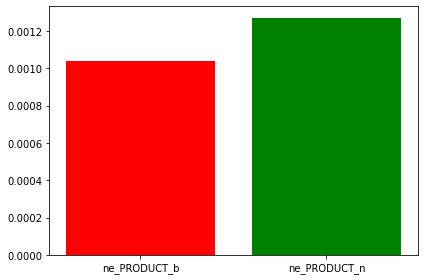

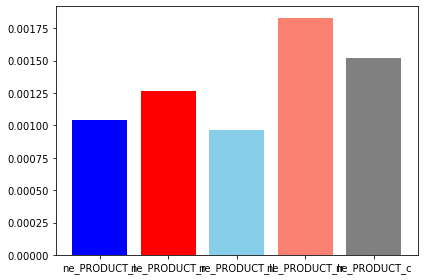

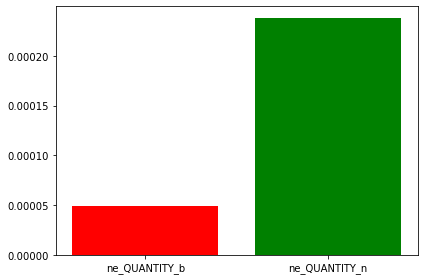

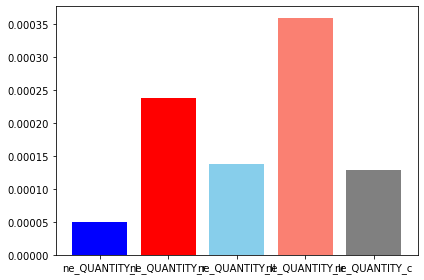

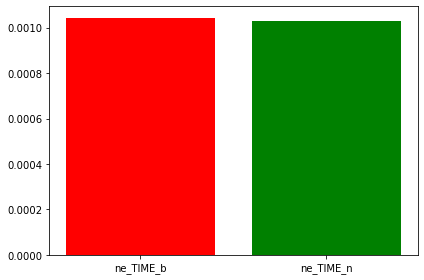

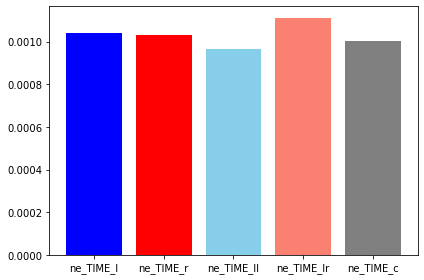

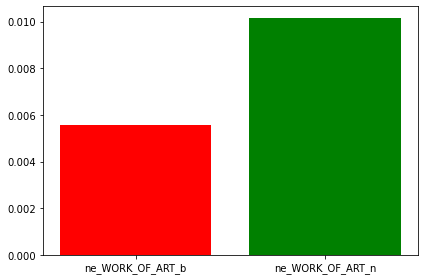

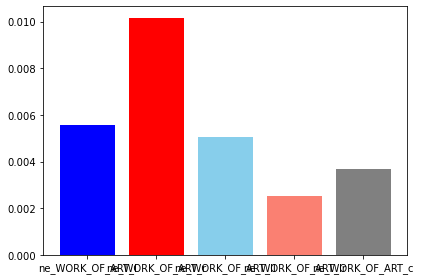

In [113]:
for i in binary_feats:
    temp_lis = [feats_avg_b[i + '_b'], feats_avg_n[i + '_n']]
    plt.figure(1)
    plt.bar(range(0,2), temp_lis, align='center', color=['red', 'green'])
    str_lis = [i + '_b', i + '_n']
    plt.xticks(range(len(temp_lis)), str_lis)
    plt.tight_layout()

    temp_lis = [feats_avg_l[i + '_l'], feats_avg_r[i + '_r'], feats_avg_ll[i + '_ll'], feats_avg_lr[i + '_lr'], feats_avg_c[i + '_c']]
    plt.figure(2)
    plt.bar(range(0,5), temp_lis, align='center', color=['blue', 'red', 'skyblue', 'salmon', 'gray'])
    str_lis = [i + '_l', i + '_r', i + '_ll', i + '_lr', i + '_c']
    plt.xticks(range(len(temp_lis)), str_lis)
    plt.tight_layout()

    plt.show()

In [109]:
def gimme_some_bar_plots_2(i):
    temp_lis = [feats_avg_b[i + '_b'], feats_avg_n[i + '_n']]
    plt.figure()
    plt.bar(range(0,2), temp_lis, align='center', color=['red', 'green'])
    str_lis = [i + '_b', i + '_n']
    plt.xticks(range(len(temp_lis)), str_lis)
    plt.tight_layout()
    plt.show

<ipython-input-109-dd746d5e30a5>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


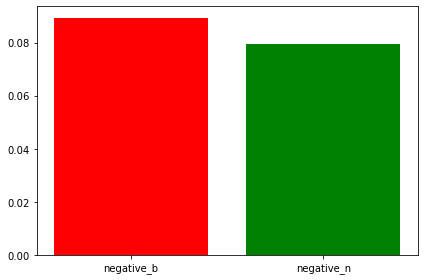

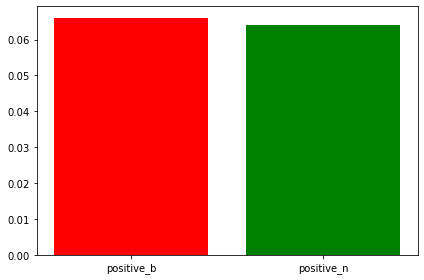

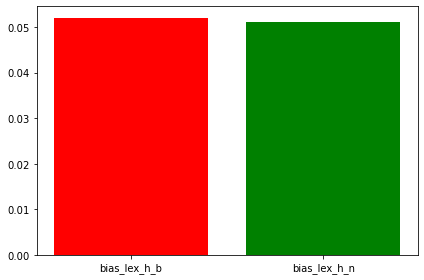

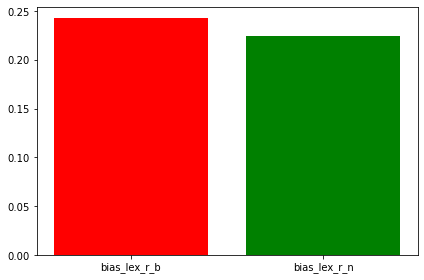

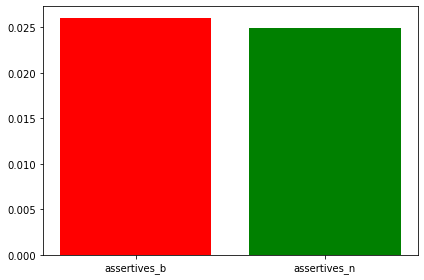

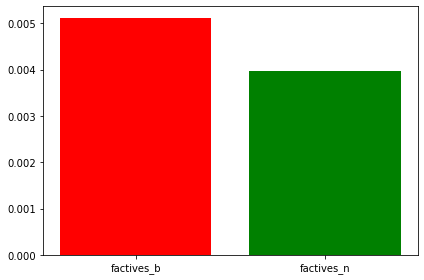

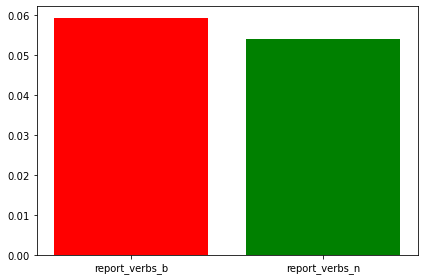

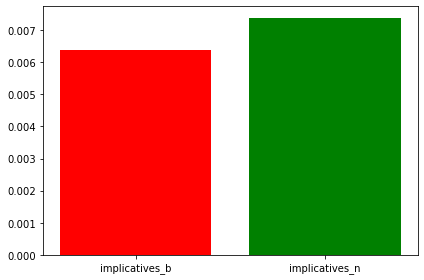

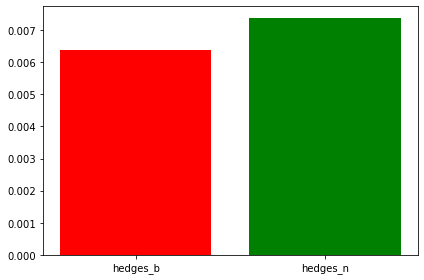

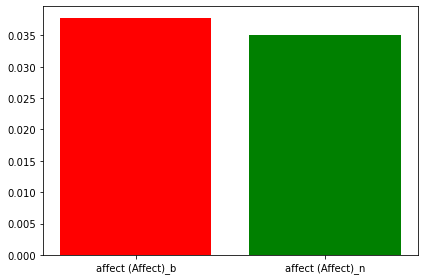

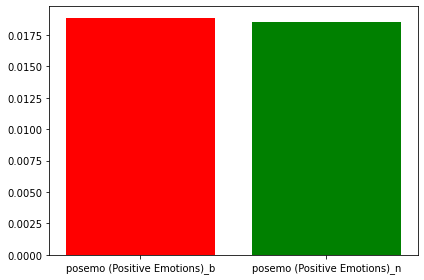

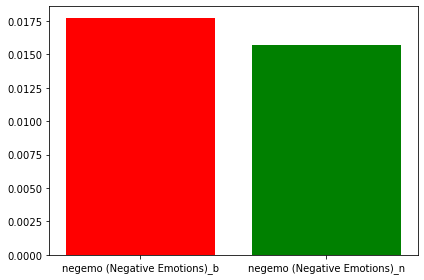

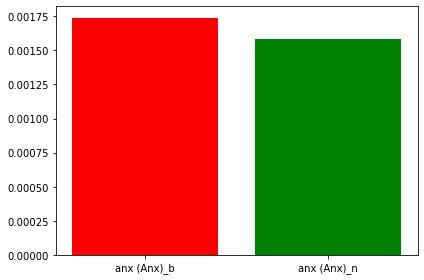

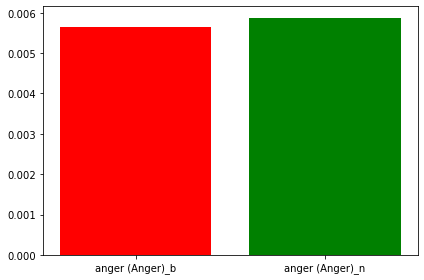

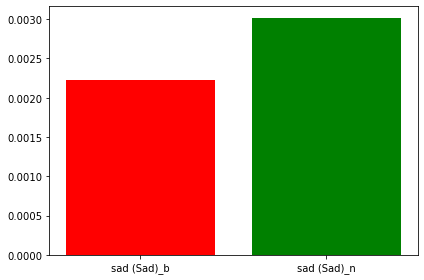

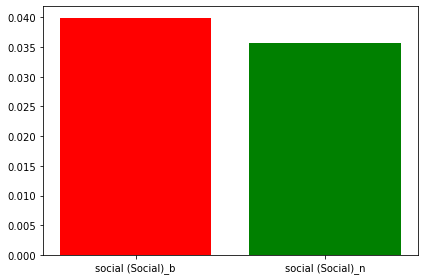

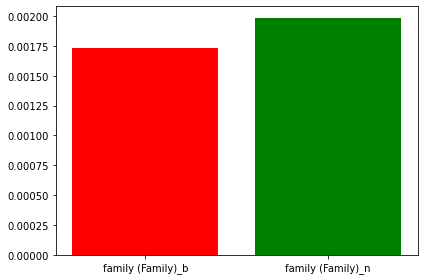

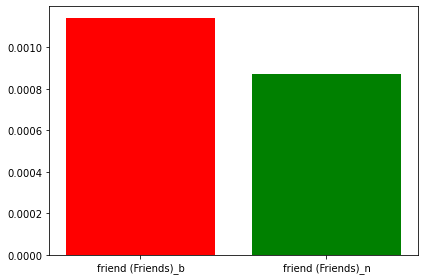

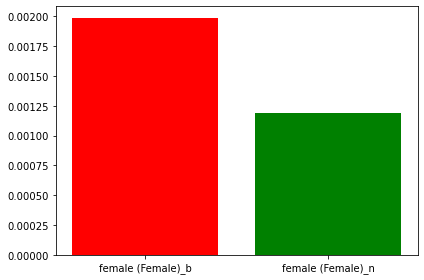

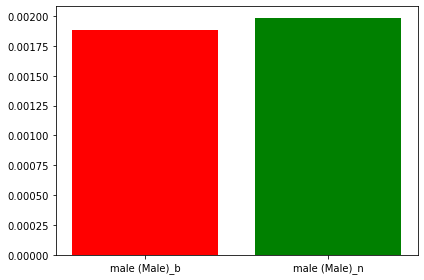

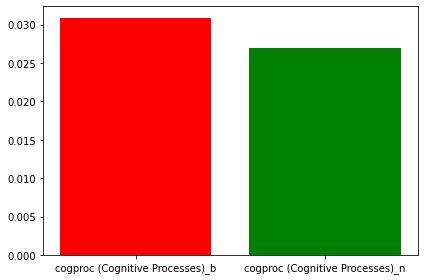

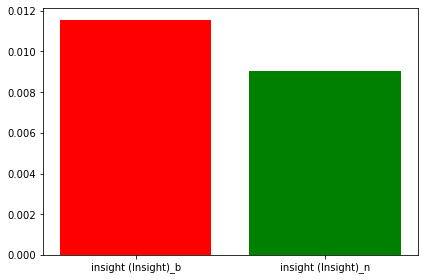

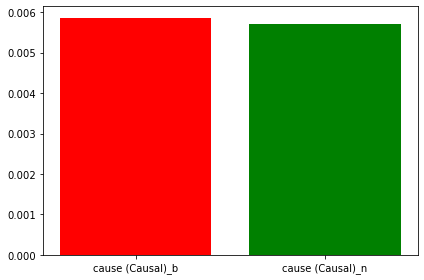

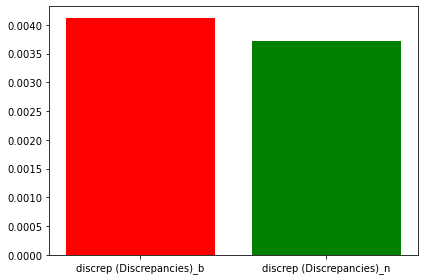

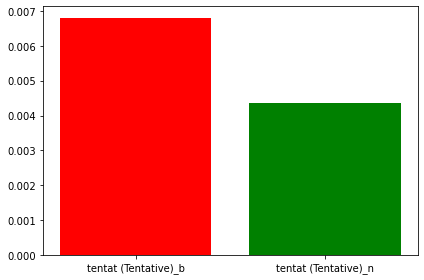

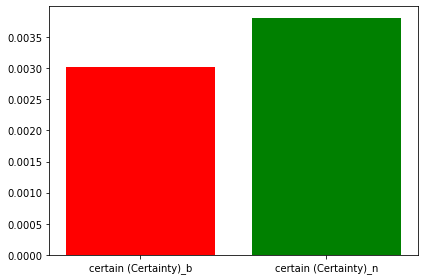

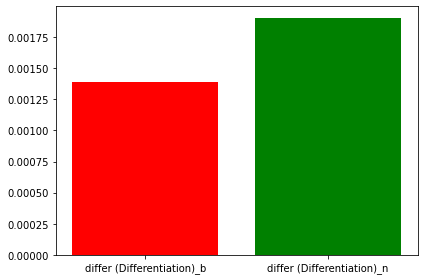

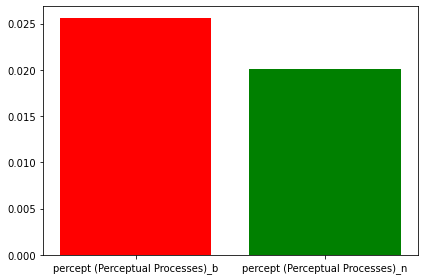

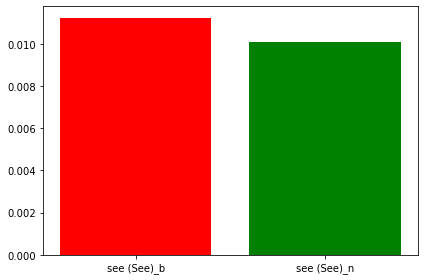

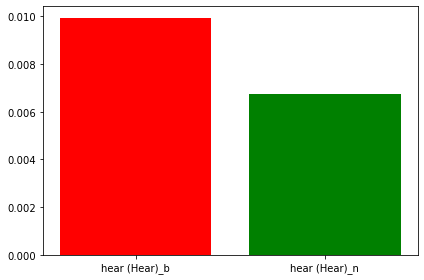

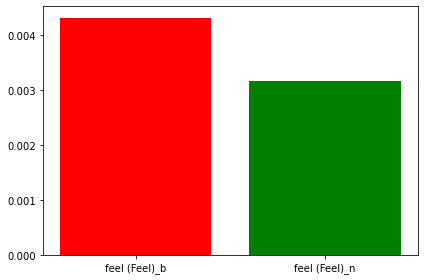

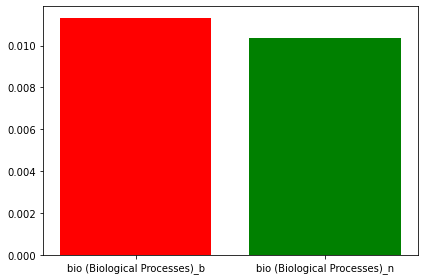

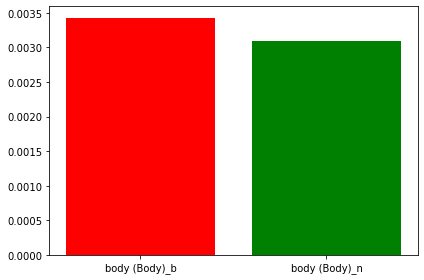

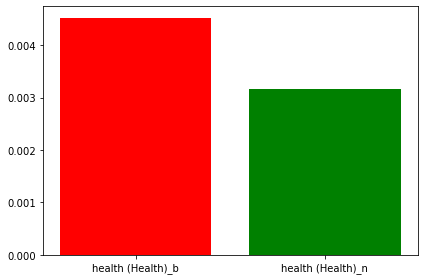

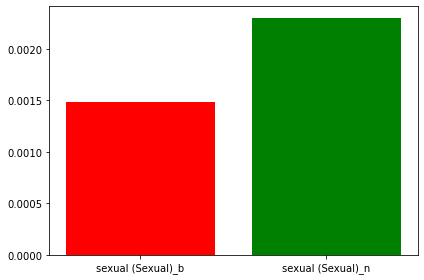

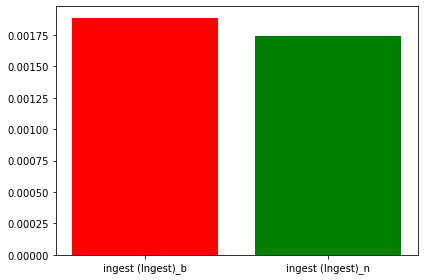

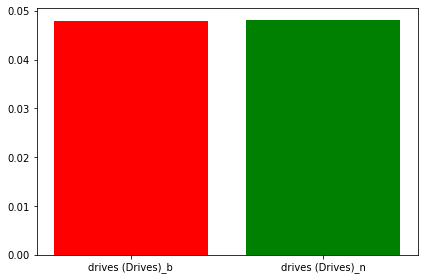

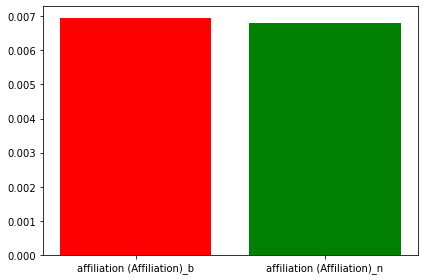

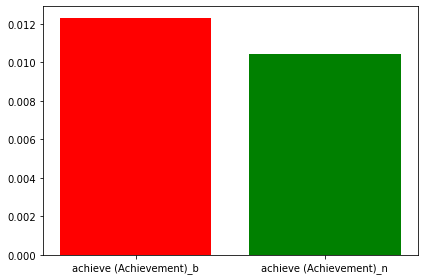

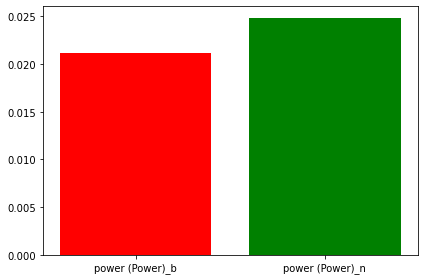

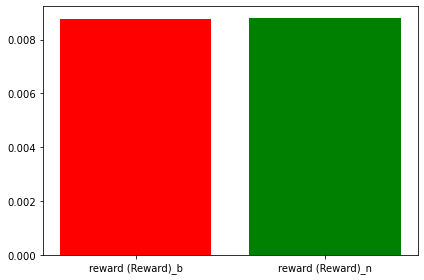

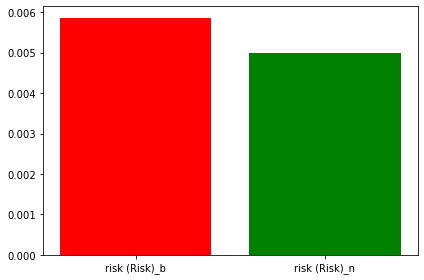

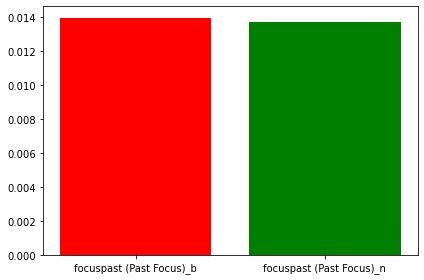

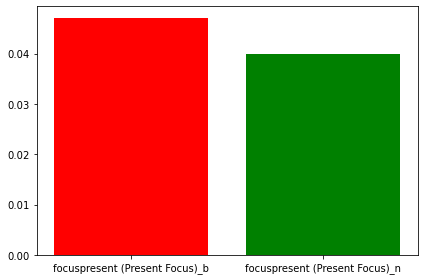

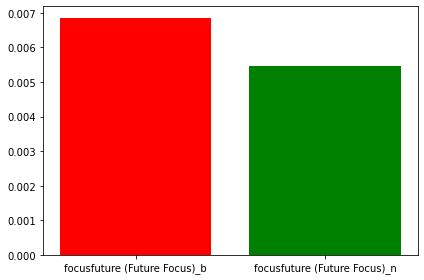

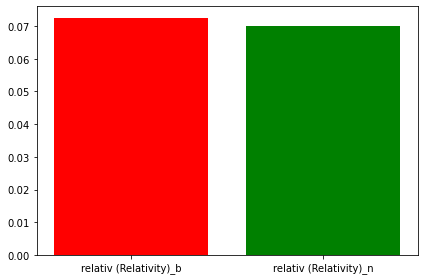

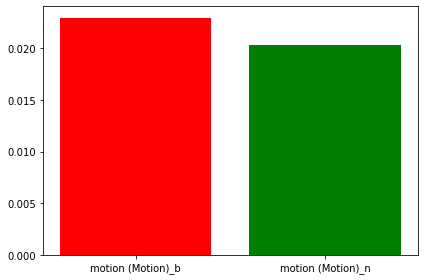

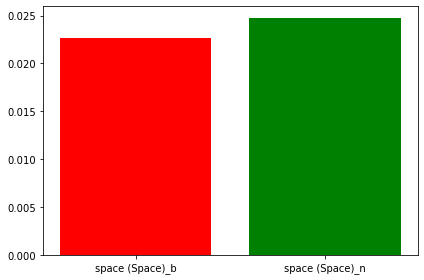

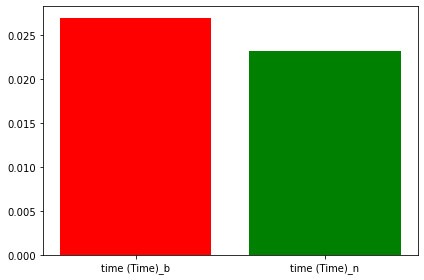

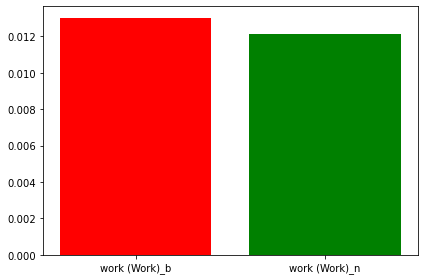

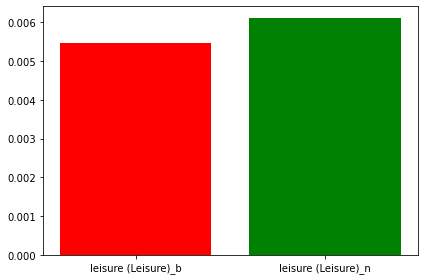

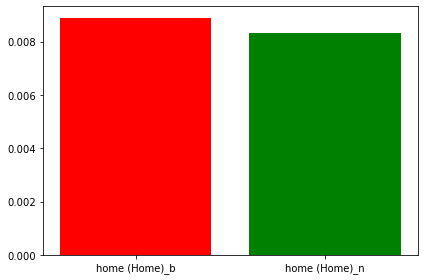

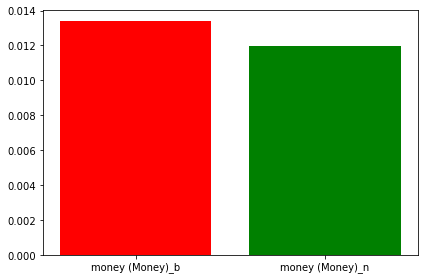

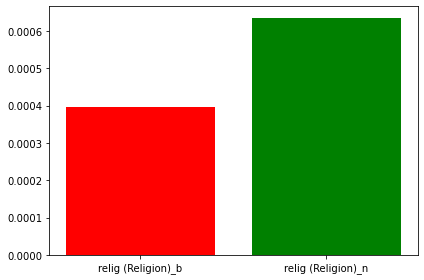

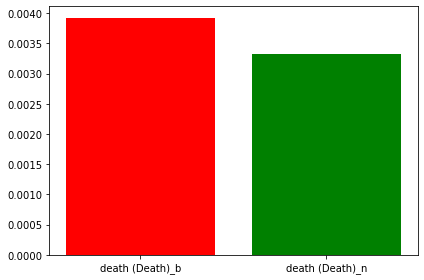

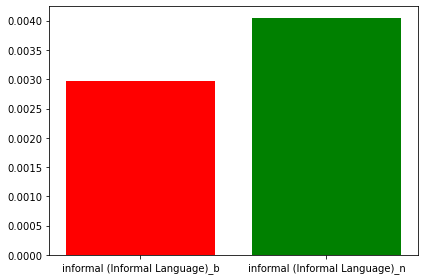

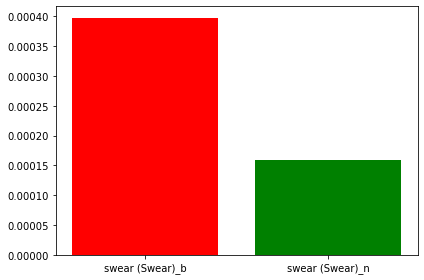

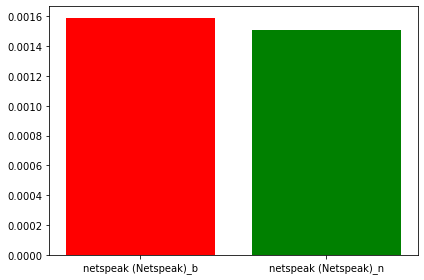

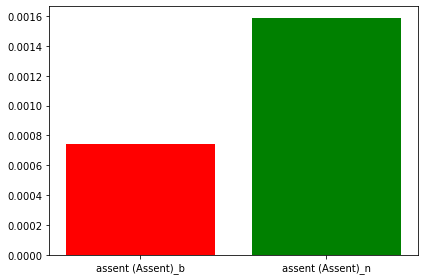

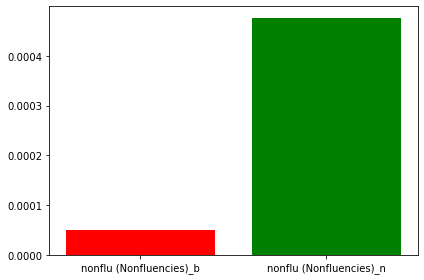

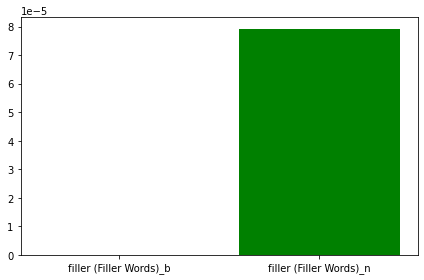

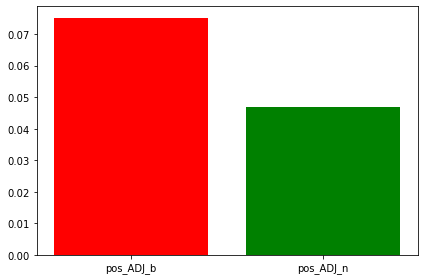

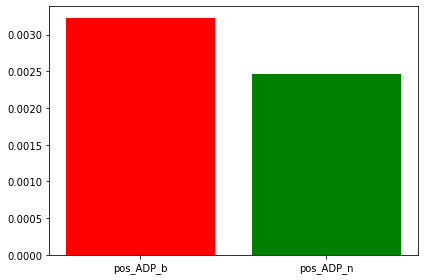

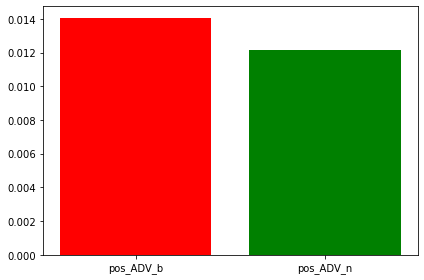

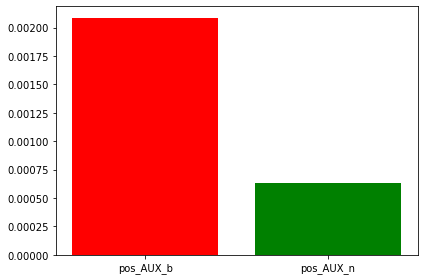

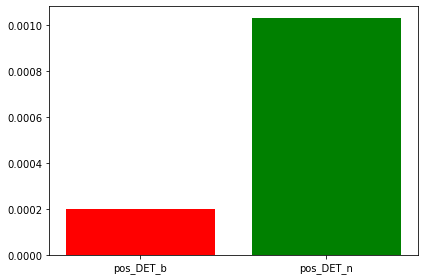

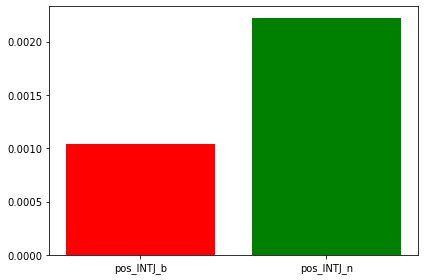

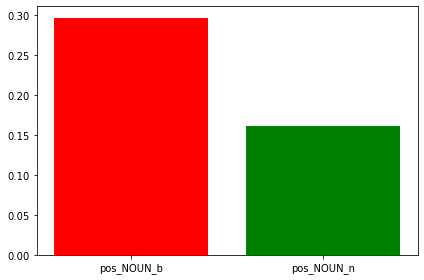

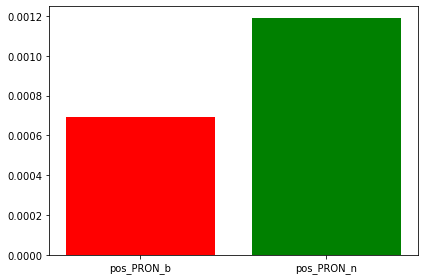

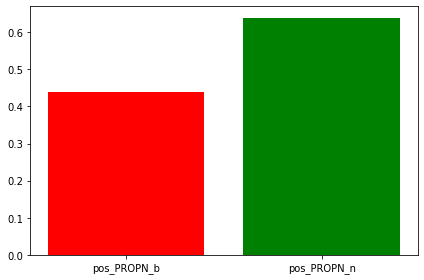

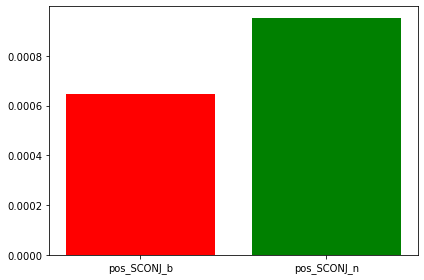

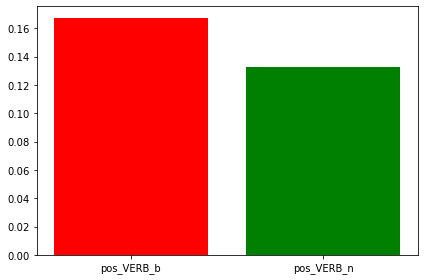

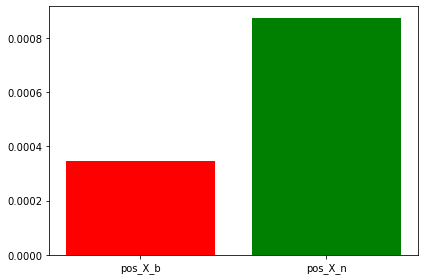

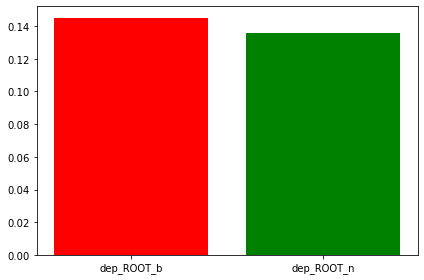

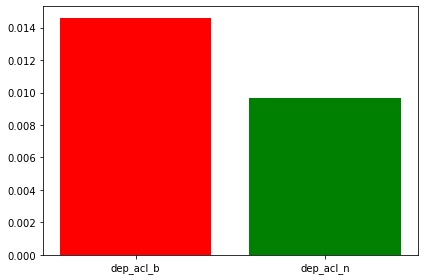

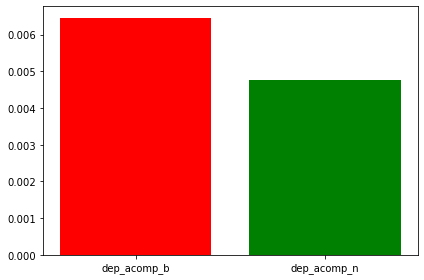

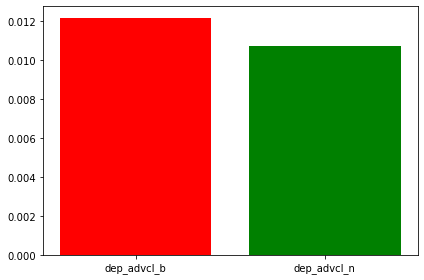

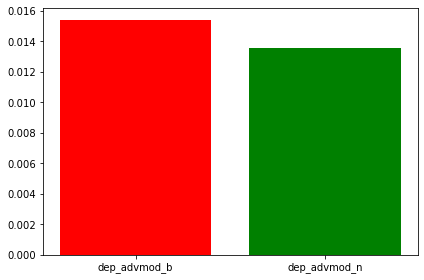

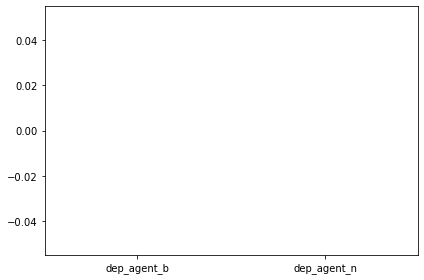

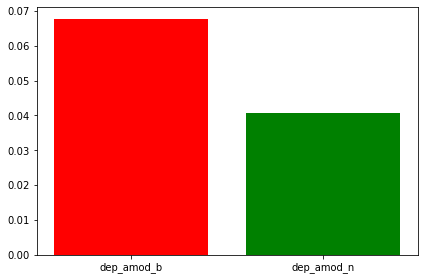

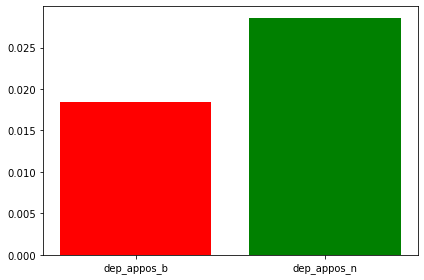

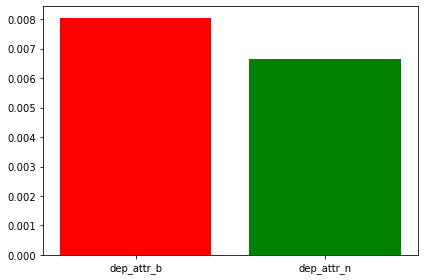

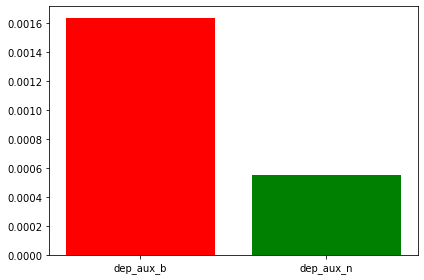

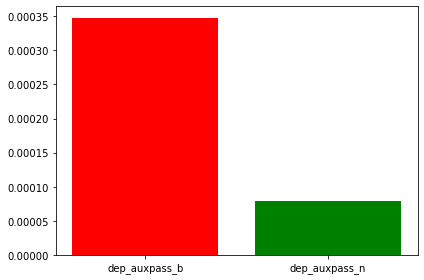

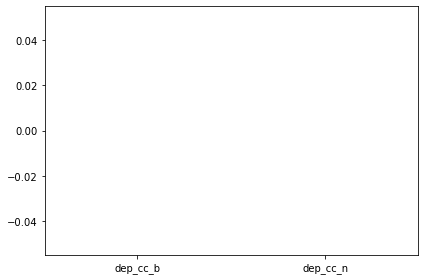

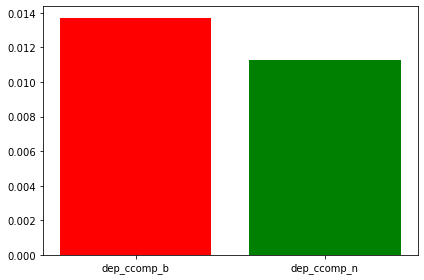

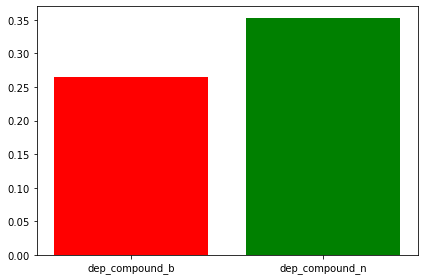

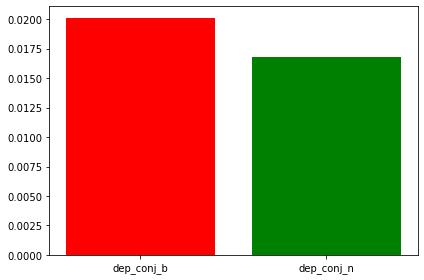

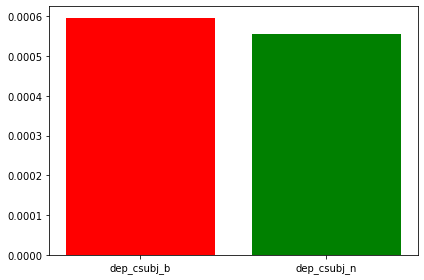

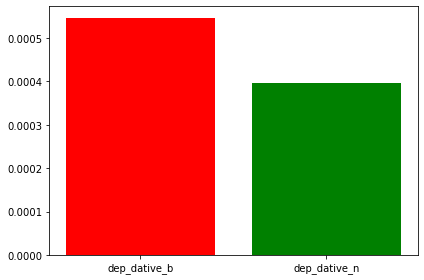

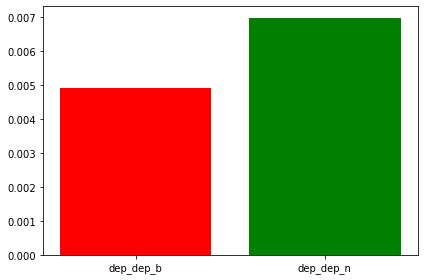

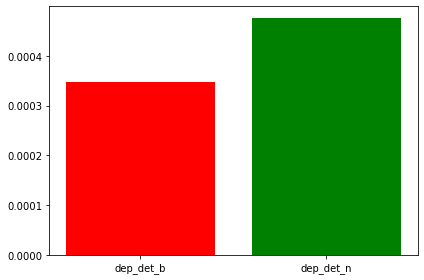

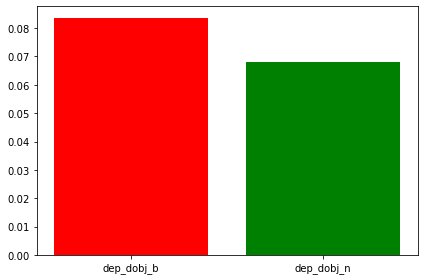

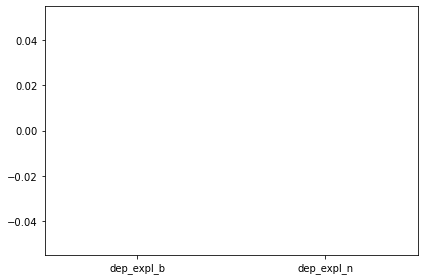

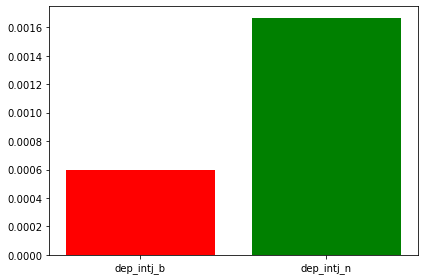

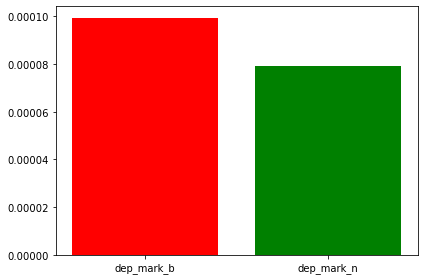

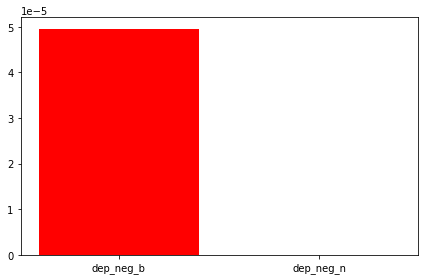

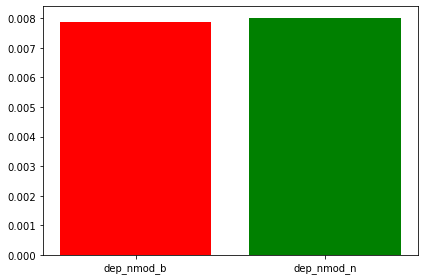

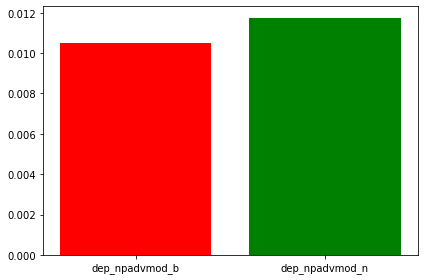

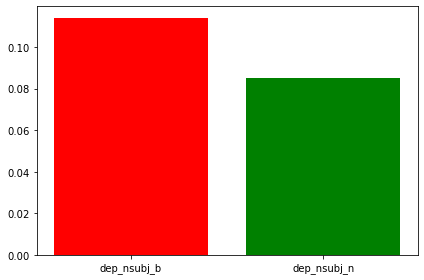

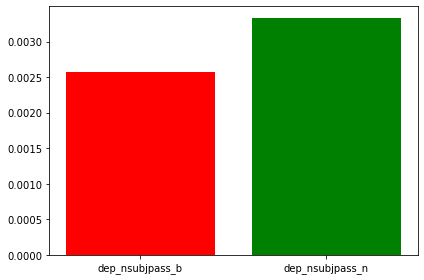

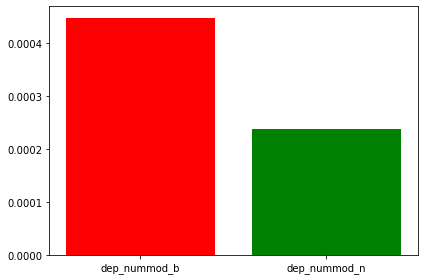

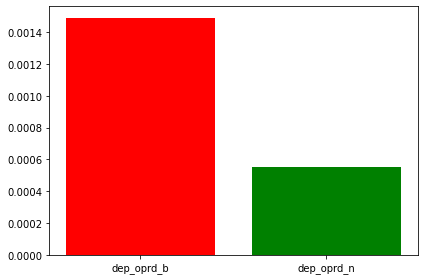

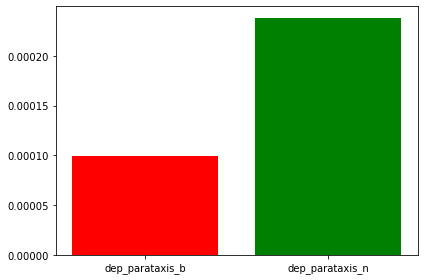

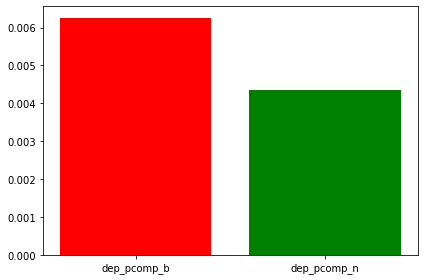

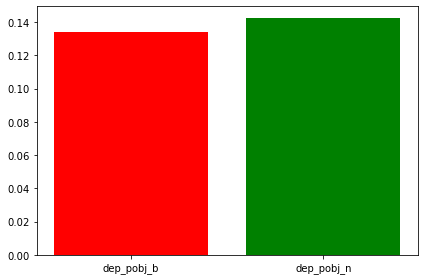

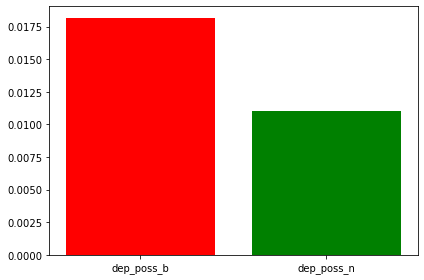

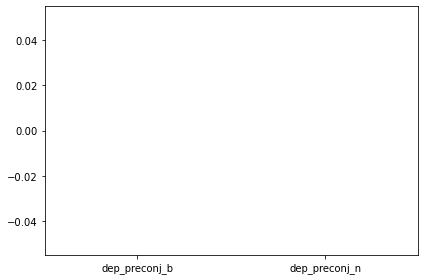

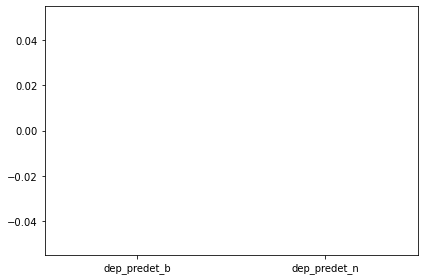

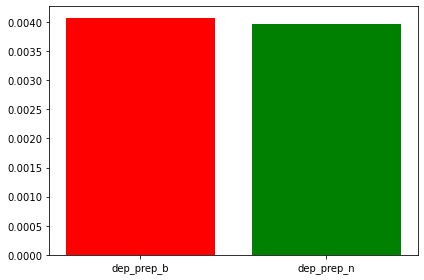

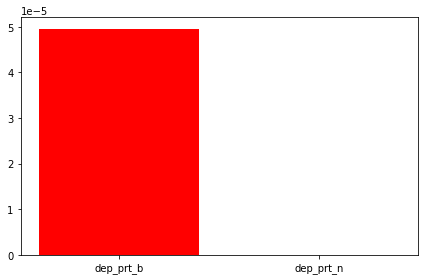

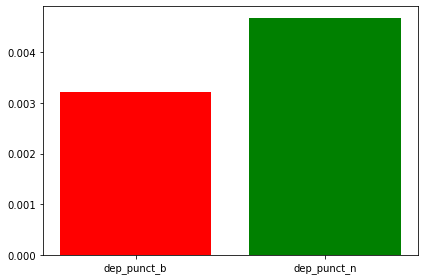

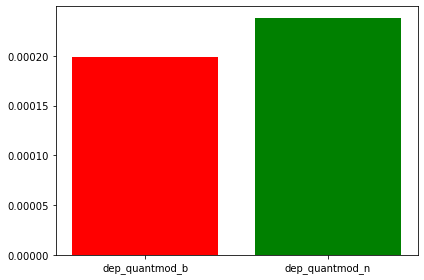

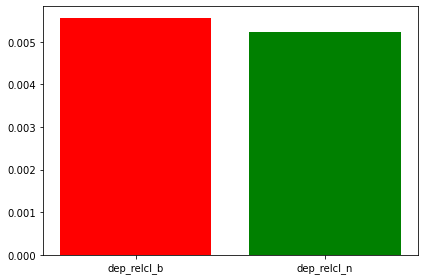

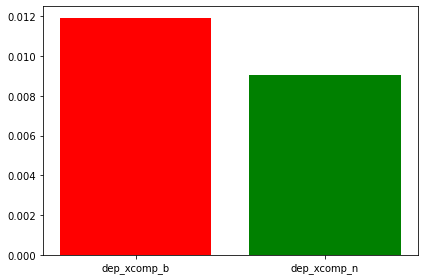

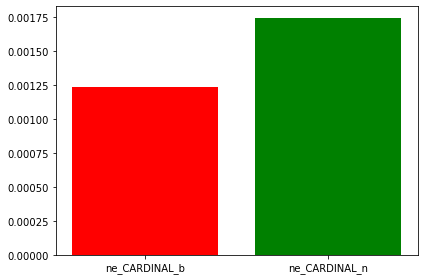

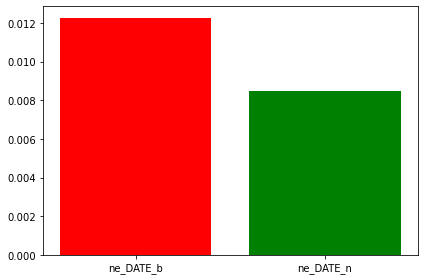

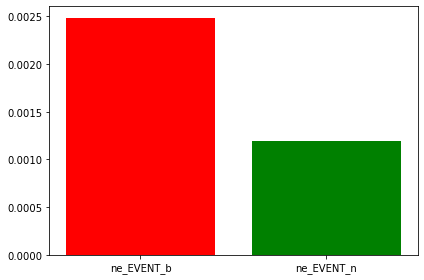

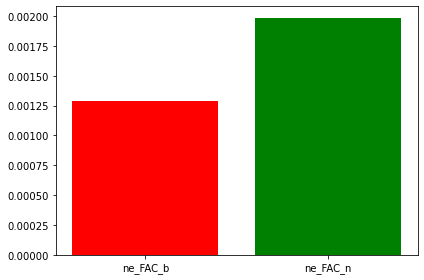

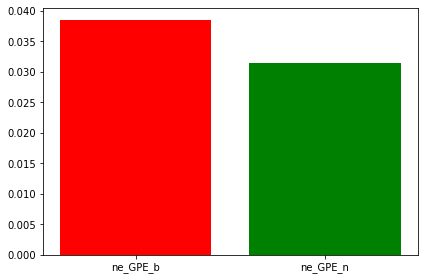

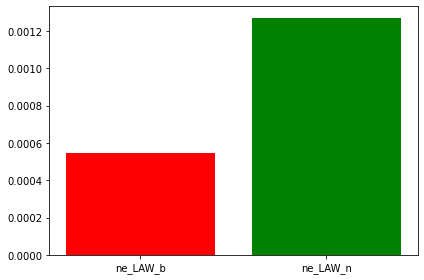

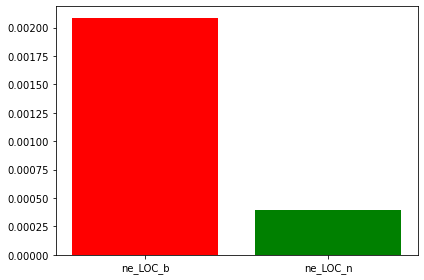

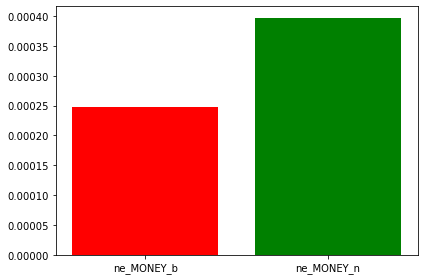

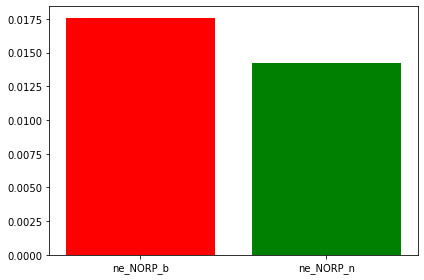

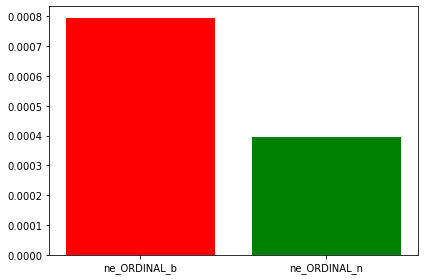

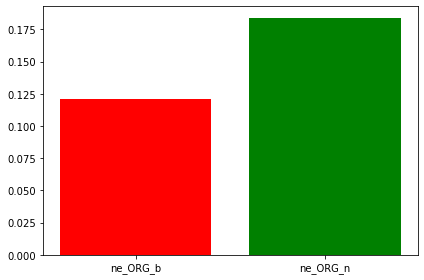

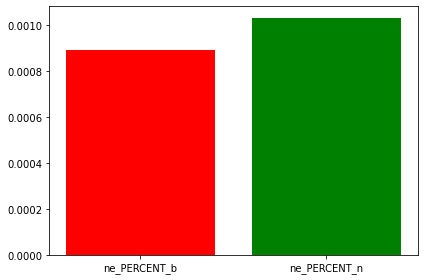

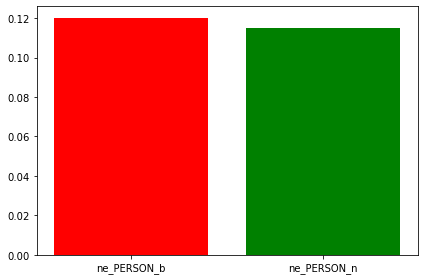

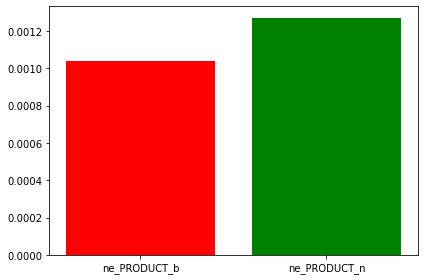

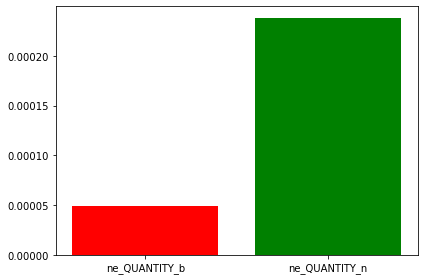

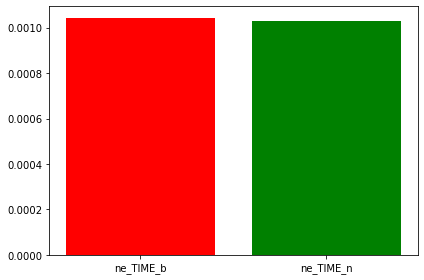

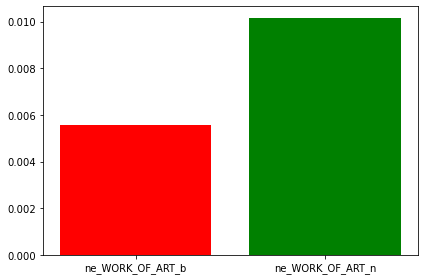

In [110]:
for i in binary_feats:
    gimme_some_bar_plots_2(i)

In [112]:
list(word_counter1)

['negative1',
 'negative0',
 'positive1',
 'positive0',
 'bias_lex_h1',
 'bias_lex_h0',
 'bias_lex_r1',
 'bias_lex_r0']

In [84]:
import matplotlib.pyplot as plt

([<matplotlib.axis.XTick at 0x13837a453d0>,
 [Text(0, 0, 'negative1'),
  Text(0, 0, 'negative0'),
  Text(0, 0, 'positive1'),
  Text(0, 0, 'positive0'),
  Text(0, 0, 'bias_lex_h1'),
  Text(0, 0, 'bias_lex_h0'),
  Text(0, 0, 'bias_lex_r1'),
  Text(0, 0, 'bias_lex_r0')])

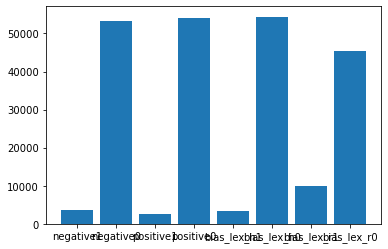

In [85]:
plt.bar(range(len(word_counter1)), list(word_counter1.values()), align='center')
plt.xticks(range(len(word_counter1)), list(word_counter1.keys()))

([<matplotlib.axis.XTick at 0x13837a88280>,
 [Text(0, 0, 'negative1'),
  Text(0, 0, 'negative0'),
  Text(0, 0, 'positive1'),
  Text(0, 0, 'positive0'),
  Text(0, 0, 'bias_lex_h1'),
  Text(0, 0, 'bias_lex_h0'),
  Text(0, 0, 'bias_lex_r1'),
  Text(0, 0, 'bias_lex_r0')])

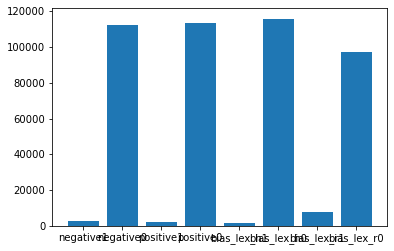

In [86]:
plt.bar(range(len(word_counter2)), list(word_counter2.values()), align='center')
plt.xticks(range(len(word_counter2)), list(word_counter2.keys()))

In [125]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

In [128]:
pairwise_similarities=np.dot(tf_idf,tf_idf.T)
pairwise_differences=euclidean_distances(tf_idf)

In [131]:
babe.head()

index                                               text  \
0      0  "Orange Is the New Black" star Yael Stone is r...   
1      1  "We have one beautiful law," Trump recently sa...   
2      2  ...immigrants as criminals and eugenics, all o...   
3      3  ...we sounded the alarm in the early months of...   
4      4  [Black Lives Matter] is essentially a non-fals...   

                                           news_link     outlet  \
0  https://www.foxnews.com/entertainment/australi...   Fox News   
1  https://www.alternet.org/2020/06/law-and-order...   Alternet   
2  https://www.nbcnews.com/news/latino/after-step...      MSNBC   
3  https://www.alternet.org/2019/07/fox-news-has-...   Alternet   
4  http://feedproxy.google.com/~r/breitbart/~3/-v...  Breitbart   

               topic   type  label_bias  \
0        environment  right  Non-biased   
1        gun control   left      Biased   
2  white-nationalism   left      Biased   
3  white-nationalism   left      Biased   
4  marriage-equality    NaN      Biased   

                           label_opinion                        biased_words  \
0                       Entirely factual                                  []   
1  Somewhat factual but also opinionated   ['bizarre', 'characteristically']   
2             Expresses writer’s opinion  ['criminals', 'fringe', 'extreme']   
3  Somewhat factual but also opinionated                                  []   
4             Expresses writer’s opinion                            ['cult']   

   Label                                      spacy_lg_dict  \
0      0  [{'text': 'Orange', 'text_low': 'orange', 'pos...   
1      1  [{'text': 'We', 'text_low': 'we', 'pos': 'PRON...   
2      1  [{'text': 'immigrants', 'text_low': 'immigrant...   
3      1  [{'text': 'we', 'text_low': 'we', 'pos': 'PRON...   
4      1  [{'text': 'Black', 'text_low': 'black', 'pos':...   

                                            spacy_lg  
0  (", Orange, Is, the, New, Black, ", star, Yael...  
1  (", We, have, one, beautiful, law, ,, ", Trump...  
2  (..., immigrants, as, criminals, and, eugenics...  
3  (..., we, sounded, the, alarm, in, the, early,...  
4  ([, Black, Lives, Matter, ], is, essentially, ...

In [141]:
bias_lis

index                                               text  \
1         1  "We have one beautiful law," Trump recently sa...   
2         2  ...immigrants as criminals and eugenics, all o...   
3         3  ...we sounded the alarm in the early months of...   
4         4  [Black Lives Matter] is essentially a non-fals...   
5         5  [Democrats employ] their full arsenal to deleg...   
...     ...                                                ...   
3667   3669  You’ve heard of Jim Crow and Southern Segregat...   
3668   3670  Young female athletes’ dreams and accomplishme...   
3669   3671  Young white men, reacting to social and educat...   
3670   3672  Young women taking part in high school and col...   
3671   3673  YouTube is making clear there will be no “birt...   

                                              news_link      outlet  \
1     https://www.alternet.org/2020/06/law-and-order...    Alternet   
2     https://www.nbcnews.com/news/latino/after-step...       MSNBC   
3     https://www.alternet.org/2019/07/fox-news-has-...    Alternet   
4     http://feedproxy.google.com/~r/breitbart/~3/-v...   Breitbart   
5     https://thefederalist.com/2020/09/22/democrats...  Federalist   
...                                                 ...         ...   
3667  http://feedproxy.google.com/~r/breitbart/~3/ei...   Breitbart   
3668  http://feedproxy.google.com/~r/breitbart/~3/eW...   Breitbart   
3669  https://thefederalist.com/2016/05/23/how-anti-...  Federalist   
3670                                                NaN   Breitbart   
3671  https://eu.usatoday.com/story/tech/2020/02/03/...   USA Today   

                  topic    type label_bias  \
1           gun control    left     Biased   
2     white-nationalism    left     Biased   
3     white-nationalism    left     Biased   
4     marriage-equality     NaN     Biased   
5               vaccine     NaN     Biased   
...                 ...     ...        ...   
3667  marriage-equality     NaN     Biased   
3668  marriage-equality     NaN     Biased   
3669  white-nationalism   right     Biased   
3670              sport   right     Biased   
3671     elections-2020  center     Biased   

                              label_opinion  \
1     Somewhat factual but also opinionated   
2                Expresses writer’s opinion   
3     Somewhat factual but also opinionated   
4                Expresses writer’s opinion   
5                Expresses writer’s opinion   
...                                     ...   
3667             Expresses writer’s opinion   
3668             Expresses writer’s opinion   
3669             Expresses writer’s opinion   
3670  Somewhat factual but also opinionated   
3671                       Entirely factual   

                            biased_words  Label  \
1      ['bizarre', 'characteristically']      1   
2     ['criminals', 'fringe', 'extreme']      1   
3                                     []      1   
4                               ['cult']      1   
5                  ['apparent', 'crime']      1   
...                                  ...    ...   
3667                             ['ALL']      1   
3668            ['dashed', '"identify"']      1   
3669                   ['evil', 'white']      1   
3670            ['dashed', '"identify"']      1   
3671                      ['birtherism']      1   

                                          spacy_lg_dict  \
1     [{'text': 'We', 'text_low': 'we', 'pos': 'PRON...   
2     [{'text': 'immigrants', 'text_low': 'immigrant...   
3     [{'text': 'we', 'text_low': 'we', 'pos': 'PRON...   
4     [{'text': 'Black', 'text_low': 'black', 'pos':...   
5     [{'text': 'Democrats', 'text_low': 'democrats'...   
...                                                 ...   
3667  [{'text': 'You', 'text_low': 'you', 'pos': 'PR...   
3668  [{'text': 'Young', 'text_low': 'young', 'pos':...   
3669  [{'text': 'Young', 'text_low': 'young', 'pos':...   
3670  [{'text': 'Young', 'text_low': 'y

In [149]:
babe

level_0  index                                               text  \
0           0      0  "Orange Is the New Black" star Yael Stone is r...   
1           1      1  "We have one beautiful law," Trump recently sa...   
2           2      2  ...immigrants as criminals and eugenics, all o...   
3           3      3  ...we sounded the alarm in the early months of...   
4           4      4  [Black Lives Matter] is essentially a non-fals...   
...       ...    ...                                                ...   
3667     3667   3669  You’ve heard of Jim Crow and Southern Segregat...   
3668     3668   3670  Young female athletes’ dreams and accomplishme...   
3669     3669   3671  Young white men, reacting to social and educat...   
3670     3670   3672  Young women taking part in high school and col...   
3671     3671   3673  YouTube is making clear there will be no “birt...   

                                              news_link      outlet  \
0     https://www.foxnews.com/entertainment/australi...    Fox News   
1     https://www.alternet.org/2020/06/law-and-order...    Alternet   
2     https://www.nbcnews.com/news/latino/after-step...       MSNBC   
3     https://www.alternet.org/2019/07/fox-news-has-...    Alternet   
4     http://feedproxy.google.com/~r/breitbart/~3/-v...   Breitbart   
...                                                 ...         ...   
3667  http://feedproxy.google.com/~r/breitbart/~3/ei...   Breitbart   
3668  http://feedproxy.google.com/~r/breitbart/~3/eW...   Breitbart   
3669  https://thefederalist.com/2016/05/23/how-anti-...  Federalist   
3670                                                NaN   Breitbart   
3671  https://eu.usatoday.com/story/tech/2020/02/03/...   USA Today   

                  topic    type  label_bias  \
0           environment   right  Non-biased   
1           gun control    left      Biased   
2     white-nationalism    left      Biased   
3     white-nationalism    left      Biased   
4     marriage-equality     NaN      Biased   
...                 ...     ...         ...   
3667  marriage-equality     NaN      Biased   
3668  marriage-equality     NaN      Biased   
3669  white-nationalism   right      Biased   
3670              sport   right      Biased   
3671     elections-2020  center      Biased   

                              label_opinion  \
0                          Entirely factual   
1     Somewhat factual but also opinionated   
2                Expresses writer’s opinion   
3     Somewhat factual but also opinionated   
4                Expresses writer’s opinion   
...                                     ...   
3667             Expresses writer’s opinion   
3668             Expresses writer’s opinion   
3669             Expresses writer’s opinion   
3670  Somewhat factual but also opinionated   
3671                       Entirely factual   

                            biased_words  Label  \
0                                     []      0   
1      ['bizarre', 'characteristically']      1   
2     ['criminals', 'fringe', 'extreme']      1   
3                                     []      1   
4                               ['cult']      1   
...                                  ...    ...   
3667                             ['ALL']      1   
3668            ['dashed', '"identify"']      1   
3669                   ['evil', 'white']      1   
3670            ['dashed', '"identify"']      1   
3671                      ['birtherism']      1   

                                          spacy_lg_dict  \
0     [{'text': 'Orange', 'text_low': 'orange', 'pos...   
1     [{'text': 'We', 'text_low': 'we', 'pos': 'PRON...   
2     [{'text': 'immigrants', 'text_low': 'immigrant...   
3     [{'text': 'we', 'text_low': 'we', 'pos': 'PRON...   
4     [{'text': 'Black', 'text_low': 'black', 'pos':...   
...                                                 ...   
3667  [{'text': 'You', 'text_low': 'you', 'pos': 'PR...   
3668  [{'text': 'Young', 'text_low': 

In [165]:
temp_df = df[["Label", "Headline"]]
temp_babe = babe[["Label", "text"]]

temp_df = temp_df.rename(columns = {"Label": "Label", "Headline": "text"})

temp_df["dataset"] = pd.Series([1 for x in range(len(temp_df.index))], index=temp_df.index)
temp_babe["dataset"] = pd.Series([0 for x in range(len(temp_babe.index))], index=temp_babe.index)
             
temp_df = temp_df.append(temp_babe)
temp_df = temp_df.reset_index()

<ipython-input-165-af1c5153a8fc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_babe["dataset"] = pd.Series([0 for x in range(len(temp_babe.index))], index=temp_babe.index)


In [171]:
temp_df

index  Label                                               text  \
0          0      0           COVID Deaths Continue to Decline in U.S.   
1          1      0  Vaccines Appear to Be Slowing Spread of Covid-...   
2          2      0      Pandemic retreat signals vaccines are working   
3          3      0  NYT, Washington Post, NBC Retract Incorrect Re...   
4          4      0  New York Times, WaPo, NBC retract reports abou...   
...      ...    ...                                                ...   
19999   3667      1  You’ve heard of Jim Crow and Southern Segregat...   
20000   3668      1  Young female athletes’ dreams and accomplishme...   
20001   3669      1  Young white men, reacting to social and educat...   
20002   3670      1  Young women taking part in high school and col...   
20003   3671      1  YouTube is making clear there will be no “birt...   

       dataset  
0            1  
1            1  
2            1  
3            1  
4            1  
...        ...  
19999        0  
20000        0  
20001        0  
20002        0  
20003        0  

[20004 rows x 4 columns]

In [182]:
lis_babe = temp_df[temp_df["dataset"] == 0]
neutral_lis_babe = lis_babe[lis_babe["Label"] == 0]
bias_lis_babe = lis_babe[lis_babe["Label"] == 1]

lis_df = temp_df[temp_df["dataset"] == 1]
bias_lis_df = lis_df[lis_df["Label"] == 1]
neutral_lis_df = lis_df[lis_df["Label"] == 0]

In [183]:
bias_lis_df = bias_lis_df.reset_index()
neutral_lis_df = neutral_lis_df.reset_index()
bias_lis_babe = bias_lis_babe.reset_index()
neutral_lis_babe = neutral_lis_babe.reset_index()

In [184]:
bias_lis_babe

level_0  index  Label  \
0       16333      1      1   
1       16334      2      1   
2       16335      3      1   
3       16336      4      1   
4       16337      5      1   
...       ...    ...    ...   
1804    19999   3667      1   
1805    20000   3668      1   
1806    20001   3669      1   
1807    20002   3670      1   
1808    20003   3671      1   

                                                   text  dataset  
0     "We have one beautiful law," Trump recently sa...        0  
1     ...immigrants as criminals and eugenics, all o...        0  
2     ...we sounded the alarm in the early months of...        0  
3     [Black Lives Matter] is essentially a non-fals...        0  
4     [Democrats employ] their full arsenal to deleg...        0  
...                                                 ...      ...  
1804  You’ve heard of Jim Crow and Southern Segregat...        0  
1805  Young female athletes’ dreams and accomplishme...        0  
1806  Young white men, reacting to social and educat...        0  
1807  Young women taking part in high school and col...        0  
1808  YouTube is making clear there will be no “birt...        0  

[1809 rows x 5 columns]

In [188]:
vec = TfidfVectorizer(token_pattern = r"(?u)\b\w+\b")
vec.fit(temp_df["text"])
tf_idf = pd.DataFrame(vec.transform(temp_df['text']).toarray(), columns = sorted(vec.vocabulary_.keys()))

pairwise_similarities=np.dot(tf_idf,tf_idf.T)
pairwise_differences=euclidean_distances(tf_idf)

In [189]:

bias_babe = []
neutral_babe = []
bias_df = []
neutral_df = []



for i in temp_df.index:
    a = 0.0
    b = 0.0
    c = 0.0
    d = 0.0
    for j in bias_lis_babe['level_0']:
        if i == j:
            continue
        a += pairwise_similarities[i][j]
    for j in neutral_lis_babe['level_0']:
        if i == j:
            continue
        b += pairwise_similarities[i][j]
    for j in bias_lis_df['level_0']:
        if i == j:
            continue
        c += pairwise_similarities[i][j]
    for j in neutral_lis_df['level_0']:
        if i == j:
            continue
        d += pairwise_similarities[i][j]
            
   
     
    avg_a = a/len(bias_lis_babe['level_0'])
    bias_babe.append(avg_a)
    avg_b = b/len(neutral_lis_babe['level_0'])
    neutral_babe.append(avg_b)
    avg_c = c/len(bias_lis_df['level_0'])
    bias_df.append(avg_c)
    avg_d = d/len(neutral_lis_df['level_0'])
    neutral_df.append(avg_d)

temp_df["BabeBiasSimil"] = bias_babe
temp_df["BabeNeutralSimil"] = neutral_babe
temp_df["DfBiasSimil"] = bias_df
temp_df["DfNeutralSimil"] = neutral_df

In [190]:
temp_df.head()

index  Label                                               text  dataset  \
0      0      0           COVID Deaths Continue to Decline in U.S.        1   
1      1      0  Vaccines Appear to Be Slowing Spread of Covid-...        1   
2      2      0      Pandemic retreat signals vaccines are working        1   
3      3      0  NYT, Washington Post, NBC Retract Incorrect Re...        1   
4      4      0  New York Times, WaPo, NBC retract reports abou...        1   

   BabeBiasSimil  BabeNeutralSimil  DfBiasSimil  DfNeutralSimil  
0       0.021961          0.027439     0.015769        0.018084  
1       0.019054          0.019958     0.008061        0.009871  
2       0.009710          0.007214     0.002427        0.002389  
3       0.009581          0.011180     0.008187        0.008470  
4       0.012117          0.011702     0.009910        0.009429

In [200]:
print(temp_df["BabeBiasSimil"][(temp_df.Label == 0) & (temp_df.dataset == 1)].mean())
print(temp_df["BabeBiasSimil"][(temp_df.Label == 1) & (temp_df.dataset == 1)].mean())
print(temp_df["BabeBiasSimil"][(temp_df.Label == 0) & (temp_df.dataset == 0)].mean())
print(temp_df["BabeBiasSimil"][(temp_df.Label == 1) & (temp_df.dataset == 0)].mean())

0.01513424223367135
0.01654825642086717
0.04451633905480959
0.04499069374112622


In [201]:
print(temp_df["DfBiasSimil"][(temp_df.Label == 0) & (temp_df.dataset == 1)].mean())
print(temp_df["DfBiasSimil"][(temp_df.Label == 1) & (temp_df.dataset == 1)].mean())
print(temp_df["DfBiasSimil"][(temp_df.Label == 0) & (temp_df.dataset == 0)].mean())
print(temp_df["DfBiasSimil"][(temp_df.Label == 1) & (temp_df.dataset == 0)].mean())

0.00992065701067457
0.010126639214840645
0.016877558353692014
0.016548256420867224


In [ ]:
bias_lis = babe[babe["Label"] == 1]
neutral_lis = babe[babe["Label"] == 0]
simil_lis = []


for i in babe['level_0']:
    b = 0.0
    if babe.iloc[i]["Label"] == 1:
        
        for j in bias_lis['level_0']:
            if i == j:
                continue
            b += pairwise_similarities[i][j]
    else:
        for j in neutral_lis['level_0']:
            if i == j:
                continue
            b += pairwise_similarities[i][j]
    avg = b/len(bias_lis['level_0'])
    simil_lis.append(avg)

In [ ]:
bias_lis = babe[babe["Label"] == 1]
neutral_lis = babe[babe["Label"] == 0]
simil_lis = []


for i in babe['level_0']:
    b = 0.0
    if babe.iloc[i]["Label"] == 1:
        
        for j in bias_lis['level_0']:
            if i == j:
                continue
            b += pairwise_similarities[i][j]
    else:
        for j in neutral_lis['level_0']:
            if i == j:
                continue
            b += pairwise_similarities[i][j]
    avg = b/len(bias_lis['level_0'])
    simil_lis.append(avg)

In [153]:
babe["Simil_score"] = simil_lis

In [155]:
babe["Simil_score"][babe["Label"]==0].mean()

0.03146343634383534

In [156]:
babe["Simil_score"][babe["Label"]==1].mean()

0.029148105830684702

In [135]:
def most_similar(doc_id,similarity_matrix,matrix):
    print (f'Document: {babe.iloc[doc_id]["text"]}')
    print ('\n')
    print ('Similar Documents:')
    if matrix=='Cosine Similarity':
        similar_ix=np.argsort(similarity_matrix[doc_id])[::-1]
    elif matrix=='Euclidean Distance':
        similar_ix=np.argsort(similarity_matrix[doc_id])
    for ix in similar_ix:
        if ix==doc_id:
            continue
        if 
        print('\n')
        print (f'Document: {babe.iloc[ix]["text"]}')
        print (f'{matrix} : {similarity_matrix[doc_id][ix]}')

most_similar(0,pairwise_similarities,'Cosine Similarity')
most_similar(0,pairwise_differences,'Euclidean Distance')  

Document: "Orange Is the New Black" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.


Similar Documents:


Document: While Omar is in no danger of being held accountable for her extremism, her ascent to rock-star status among Democrats and their media cheering section gives the lie to their claims to be standing up against hate and antisemitism.
Cosine Similarity : 0.15652812255584697


Document: A Guatemalan mom who says she sustained severe chemical burns and was sexually assaulted in front of her young daughter during a kidnapping in Mexico is asking the U.S. government to let her into the country while her asylum case plays out.
Cosine Similarity : 0.14842756020244613


Document: Experts warn that the extreme weather conditions that caused wildfireares in Australia are a mark of climate change.
Cosine Similarity : 0.14726000356075933


Document: Her call for a Green New Deal -- which would seek to focus on income

KeyboardInterrupt: 

In [ ]:
# tokenize and pad every document to make them of the same size
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer=Tokenizer()
tokenizer.fit_on_texts(documents_df.documents_cleaned)
tokenized_documents=tokenizer.texts_to_sequences(documents_df.documents_cleaned)
tokenized_paded_documents=pad_sequences(tokenized_documents,maxlen=64,padding='post')
vocab_size=len(tokenizer.word_index)+1
print (tokenized_paded_documents[0])

In [ ]:
# loading pre-trained embeddings, each word is represented as a 300 dimensional vector
import gensim
W2V_PATH="GoogleNews-vectors-negative300.bin.gz"
model_w2v = gensim.models.KeyedVectors.load_word2vec_format(W2V_PATH, binary=True)

In [ ]:
# creating embedding matrix, every row is a vector representation from the vocabulary indexed by the tokenizer index. 
embedding_matrix=np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    if word in model_w2v:
        embedding_matrix[i]=model_w2v[word]
# creating document-word embeddings
document_word_embeddings=np.zeros((len(tokenized_paded_documents),64,300))
for i in range(len(tokenized_paded_documents)):
    for j in range(len(tokenized_paded_documents[0])):
        document_word_embeddings[i][j]=embedding_matrix[tokenized_paded_documents[i][j]]
document_word_embeddings.shape

In [ ]:
document_embeddings=np.zeros((len(tokenized_paded_documents),300))
words=tfidfvectoriser.get_feature_names()
for i in range(len(document_word_embeddings)):
    for j in range(len(words)):
        document_embeddings[i]+=embedding_matrix[tokenizer.word_index[words[j]]]*tfidf_vectors[i][j]
print (document_embeddings.shape)
pairwise_similarities=cosine_similarity(document_embeddings)
pairwise_differences=euclidean_distances(document_embeddings)
most_similar(0,pairwise_similarities,'Cosine Similarity')
most_similar(0,pairwise_differences,'Euclidean Distance')

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

document_embeddings = sbert_model.encode(documents_df['documents_cleaned'])

pairwise_similarities=cosine_similarity(document_embeddings)
pairwise_differences=euclidean_distances(document_embeddings)

most_similar(0,pairwise_similarities,'Cosine Similarity')
most_similar(0,pairwise_differences,'Euclidean Distance')